# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)

## Class 09 — Bayesian takes on the "Hot Hand": effect, fallacy, and controversy

In sports (and many other domains), we talk about someone being "on fire," "in the zone," or having a "hot hand." The question is not whether streaks happen — they do — but whether **streaks contain predictive information** about what comes next.

This notebook treats the hot hand as a modeling problem: what would it even *mean* (statistically) for someone to be hot, and how do we learn that from finite, messy data?

This notebook is meant to work both for live teaching (first several sections), and for (much more...) independent study. It includes optional sections and appendices that go deeper than we can cover in a single class meeting.

![](images/hot_hand.png)

_______
## Big picture roadmap

We'll open with why the hot-hand question became controversial, then build tools to think about it carefully.

1. **Interlude: the controversy** — how a 1985 paper turned "hot hand" into a canonical example of misperceiving randomness, and why the debate re-opened decades later.
2. **Random streaks** — what streaks look like even when nothing "hot" is happening.
3. **Bayesian crash course** — Bayes' rule, priors/likelihoods/posteriors, and the Beta-Binomial workhorse.
4. **A Gelman-style Bayesian workflow** — effect sizes, heterogeneity, measurement error, and why model alignment matters.
5. **Hot hand definitions** — what we can (and cannot) learn from sequences of makes and misses.
6. **The streak selection bias** — why naive "after 3 makes" comparisons can be biased in finite samples.
7. **Permutation tests** — a clean, assumption-light way to calibrate "how surprising is this streakiness?"
8. **Simulation lab** — when there *is* a hot hand, can we detect it with the tools above?
9. **Real NBA shot logs** — evidence, confounds, and interpretation.
10. **Bayesian models** — Beta-Binomial conditional rates and a latent hot/cold hidden Markov model (HMM).

_______
## The hot hand controversy and why it lasted decades

If you've played (or watched) basketball, you've probably seen moments that *feel* undeniable: a shooter "can't miss," teammates look for them, defenders panic, and the broadcast starts counting. The controversy is that this intuition collided with a famous statistical claim!

In a celebrated paper, Gilovich, Vallone, and Tversky (1985) studied shooting sequences and also surveyed fans. Their conclusion (in the title!) was that what people perceive as a "hot hand" is often a misperception of randomness. The paper became one of the canonical examples in the psychology/behavioral-econ canon: people see patterns in noise and overreact to streaks.

Then the story got messier:

- Many researchers argued that the statistical tests had low power and used estimators with subtle small-sample bias.
- New data (controlled shooting studies, richer shot logs, tracking data) started to suggest that *some* short-term predictability exists.
- A major turning point came from Miller & Sanjurjo (2018), who showed that the most common "hot hand" statistic is biased downward in finite sequences even when shots are independent. After correction, some classic "no hot hand" conclusions weaken or reverse.

> The controversy is not just "Is there a hot hand?" 
> It is "Which *definition* of hot hand do we mean, and which *estimand* can our data actually identify?"

### What the 1985 paper actually did

Gilovich, Vallone, and Tversky (1985) is often summarized as "they found no hot hand." For teaching, it helps to be more concrete about *what was measured*:

- **Study 1 (beliefs):** 100 basketball fans answered questions about whether makes and misses are positively dependent. For a hypothetical 50% shooter, the *average* belief was about **61% after a make** versus **42% after a miss** (and essentially everyone reported the "after a make" number as larger). The survey also suggested that these beliefs affected strategy (e.g., who you pass to).


- **Study 2 (NBA field goals):** shot-by-shot field goal sequences for nine major players from the 1980-81 Philadelphia 76ers (48 home games). They reported conditional shooting percentages (after 1, 2, or 3 hits vs. after 1, 2, or 3 misses) and serial correlations.


- **Study 3 (NBA free throws):** pairs of free throws from Boston Celtics players (a cleaner setting because the location is fixed and defense is absent). Again they reported conditional rates for the second free throw given the first.


- **Study 4 (controlled shooting):** Cornell varsity players took shots in a controlled design. Players' *predictions* responded to prior makes/misses, but performance did not show a consistent dependence.


Two subtle methodological points that are easy to miss:

1. The paper explicitly distinguishes "belief in hot hand" (a psychological claim) from "hot hand in the data" (a statistical claim).
2. The authors note that **pooling across players can be misleading** because better shooters contribute more observations to "after make" groups than worse shooters do.

The rest of the literature—and the later controversy—largely lives inside these two points.


_______
### A compressed timeline

| Era | Representative contribution | What it changed |
|---:|---|---|
| 1985 | Gilovich, Vallone & Tversky | Popularized "hot hand fallacy" using game data + controlled tasks; became a touchstone for "misperception of randomness." |
| 2006 | Bar‑Eli, Avugos & Raab (review) | Catalogued mixed evidence and emphasized that definitions + test statistics vary across studies. |
| 2018 | Miller & Sanjurjo | Identified a finite-sample bias in common streak-conditioned estimators; re-opened conclusions from earlier analyses. |
| 2020 | Ötting et al. (darts) | Used latent-state models to argue for short-lived hot/cold structure in a controlled skill task. |
| 2022 | Pelechrinis & Winston (NBA tracking) | Found heterogeneity: some players show evidence of streakiness, while league averages can still show regression. |
| 2025 | Calvo, Armero & Spezia | Built Bayesian hidden Markov models with covariates and random effects for basketball sequences. |


### What we'll do differently in this notebook

...we'll still learn the classic hot-hand statistics, because they're historically important and because they teach general lessons about conditioning, selection, and bias. But we'll also take a Bayesian modeling stance:

- Treat shot outcomes as noisy measurements of an underlying (possibly time-varying) success probability.
- Make the estimand explicit (what quantity are we trying to learn?).
- Use simulation and posterior predictive checks to understand when a statistic works and when it fails.
- Expect heterogeneity across players and contexts, and use partial pooling when appropriate.


This framing aligns with the way e.g. [Andrew Gelman](https://sites.stat.columbia.edu/gelman/) has written about the hot-hand debate: focus on effect sizes, variation, and model adequacy rather than a single binary "exists / doesn't exist" verdict.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CNET5442_COLORS = ["#1B5776", "#B5832C", "#2C7980", "#AE4A35",
                   "#D8BC7A", "#7B5E7F", "#4C6C5B", "#D4A28A",
                   "#7F9272", "#CB7566", "#82A3C6", "#494949"]

from scipy import stats
from scipy.special import expit, logit

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import statsmodels.api as sm

np.random.seed(5442)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 60)

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Working Definitions

We observe a sequence of attempts:

- $Y_t = 1$ if the shot/attempt at time $t$ is a **success**  
- $Y_t = 0$ if it is a **failure**

Two different ideas often get mixed together:

### 🔥 Heating Up (short-term predictive effect)
After a recent success, the **next attempt** is *slightly more likely* to succeed.

- Typical tools: conditional probabilities, logistic regression, permutation tests


### ⭐ Star Mode (latent "mode switch")
Sometimes the player is in a **hot state** (higher success probability), sometimes in a **normal/cold state**, and those states can **persist** over time.

- Typical tools: state-space / HMM-type thinking, uncertainty quantification (often Bayesian)

In this notebook we'll keep everything as simple and toy-ish as possible.

__________
## Trap #1 — Streaks happen under randomness

Let's say our baseline null model is this:

$$Y_t \sim \text{Bernoulli}(p) \quad \text{i.i.d.}$$

Even when outcomes are independent and $p$ is constant:
- you still see **clusters**
- you still see **long runs** (e.g., 5 makes in a row)

#### Quick note: Cluster vs. long run (what's the difference?)

When I say "randomness is lumpy," I mean you can see *apparent* streakiness even when the shots are truly i.i.d.

There are two related (but different) patterns people often mix up:

**A long run** is a *consecutive* streak of the same outcome. So, for makes ($Y_t = 1$), a run of length $k$ means there are $k$ makes in a row:
$$
Y_t = Y_{t+1} = \cdots = Y_{t+k-1} = 1.
$$
The longest run in a sequence is just the biggest such $k$ anywhere in the data. This only cares about *back-to-back* events.

**A cluster** is a more informal "packed together" idea. It means makes are *concentrated in a short stretch of time*, even if they aren't all consecutive. For example:

- Sequence A (long run **and** cluster): `1 1 1 1 1 0 0 ...`  
  Here the longest run is 5.

- Sequence B (cluster but not a long run): `1 0 1 1 0 1 0 1 1 ...`  
  Here makes are "bunched up," but the longest run might be only 2.

A clean way to measure clustering (one option) is to pick a window size $w$ and count how many makes occur inside each length-$w$ window:
$$
C_w = \max_t \sum_{i=t}^{t+w-1} Y_i.
$$
This detects local concentration even if there are misses in between.

**Key takeaway:**  
A long run is a specific, well-defined thing ("$k$ in a row").  
A cluster is broader ("many makes close together").  
You can have clustering without long runs, and under i.i.d. randomness you should expect to see *some* of both.

_________

In [2]:
def longest_run_length(y):
    """Length of the longest run of identical values in a binary sequence.

    Parameters
    ----------
    y : 1d array-like of 0/1
        Sequence of outcomes.

    Returns
    -------
    int
        The length of the longest streak of consecutive equal outcomes.
    """
    y = np.asarray(y).astype(int)
    if y.size == 0:
        return 0

    best = 1
    cur = 1
    for i in range(1, len(y)):
        if y[i] == y[i-1]:
            cur += 1
            best = max(best, cur)
        else:
            cur = 1
    return best

Let's simulate random sequences and look at how long the longest streak tends to be.

In [3]:
def simulate_iid_bernoulli(T, p):
    """Simulate an i.i.d. Bernoulli sequence of length T."""
    return (np.random.rand(T) < p).astype(int)

In [4]:
# Lil example: show one sequence
y = simulate_iid_bernoulli(T=50, p=0.5)
print("sequence:", y[:20])
print("mean:", y.mean())
print("longest run:",longest_run_length(y))

sequence: [0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1]
mean: 0.68
longest run: 10


In [5]:
# Distribution of the longest run under pure randomness
T = 100
p = 0.5
R = 1200

runs = np.array([longest_run_length(simulate_iid_bernoulli(T, p)) for _ in range(R)])

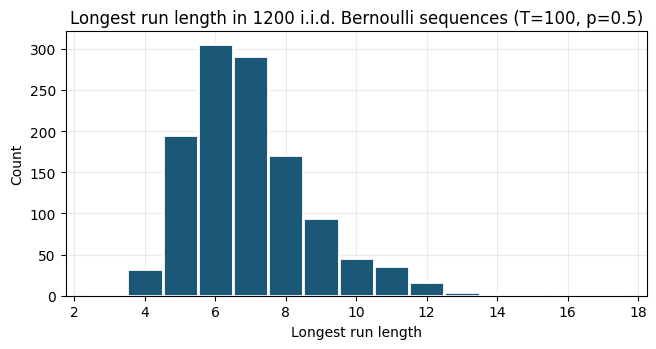

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(runs, bins=np.arange(runs.min()-0.5, runs.max()+1.5, 1),
        edgecolor='white', color=CNET5442_COLORS[0], lw=2)
ax.set_title(f'Longest run length in {R} i.i.d. Bernoulli sequences (T={T}, p={p})')
ax.set_xlabel('Longest run length')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)


plt.show()

A random sequence with $T=100$ often contains a longest run around, say, 6-9 (your exact histogram may differ slightly). That's already long enough to *feel* meaningful when you watch a game.

**Takeaway:** seeing a streak is not evidence of a hot hand.
To argue for a hot hand, we need a statistical definition that compares what we saw to what randomness predicts. So "I saw a streak" is not evidence by itself.  Evidence needs a comparison: *observed streakiness vs what the null predicts*.

____________
## Trap #2 — Shots are not "repeatable trials"

In real games, shots vary in difficulty and context, so a more realistic model is:

$$Y_t \sim \text{Bernoulli}(p_t)$$

where $p_t$ changes with:
- location, defense, fatigue, shot type
- **shot selection** (you might take harder shots after you make one!)

This can hide a real 🔥 effect... or create an illusory one.

Below is a toy simulation where:
- "easy" shots have higher make probability than "hard" shots (not for me... they're all easy when I'm shooting baskets)
- after a make, the player attempts harder shots more often

### Toy model of variable difficulty shots:

A simple way to model this is:

- each attempt $t$ has a difficulty (categoriacal: easy vs hard)
- the difficulty depends on what happened on the previous attempt
  - after a make, you might take a tougher shot (or get tighter defense)
  - after a miss, you might take an easier shot (or get more space)

So instead of $Y_t \sim \text{Bernoulli}(p)$ with constant $p$, we have:

$$
Y_t \sim \text{Bernoulli}(p_t),
\qquad p_t \in \{p_{\text{easy}}, p_{\text{hard}}\},
$$

and the probability of getting an easy shot can depend on $Y_{t-1}$.

Let's build a toy generator with two ingredients:

1) **Selection / context (difficulty changes):**  
   $P(\text{easy at }t \mid Y_{t-1}=1)$ can differ from  $P(\text{easy at }t \mid Y_{t-1}=0)$.

2) **Optional 🔥 effect:**  
   after a make, we optionally add a small boost $+\delta$ to $p_t$.

______
Goal: see how changes in difficulty can make "after a make" look better or worse, even when there is no true 🔥 effect.

### Case A

#### Step 0 — Choose parameters

- $p_{\text{easy}}$: probability of a make on an easy attempt  
- $p_{\text{hard}}$: probability of a make on a hard attempt  

Selection / context parameters:

- $\Pr(\text{easy} \mid \text{previous was make})$
- $\Pr(\text{easy} \mid \text{previous was miss})$

🔥 parameter (optional):

- `fire_delta`: how much we bump up $p_t$ *after a make*

We'll do two cases:
- Case A: `fire_delta = 0.0` (no 🔥, only selection)
- Case B: `fire_delta > 0` (small 🔥, same selection)

In [7]:
n = 200

# shot success probs
p_easy = 0.70
p_hard = 0.35

# selection / context: difficulty depends on previous outcome
prob_easy_after_make = 0.40
prob_easy_after_miss = 0.60

# 🔥 effect (none in Case A)
fire_delta = 0.0

#### Step 1 — Allocate arrays and initialize the first attempt

We'll store:

- `y[t]` in {0,1}: miss/make at time $t$
- `diff[t]` in {0,1}: hard/easy at time $t$ (1 = easy, 0 = hard)

We initialize difficulty at random for $t=0$, then draw the first make/miss.

In [8]:
y = np.zeros(n, dtype=int)
diff = np.zeros(n, dtype=int)  # 1 = easy, 0 = hard

# start difficulty at random
diff[0] = 1 if np.random.rand() < 0.5 else 0

# make probability depends on difficulty
p0 = p_easy if diff[0] == 1 else p_hard
y[0] = 1 if np.random.rand() < p0 else 0

y[:10], diff[:10]

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

#### Step 2 — Simulate time steps 1,2,...,n-1

At each time $t \ge 1$:

1) Choose difficulty based on the previous outcome:
   - if $Y_{t-1}=1$, use `prob_easy_after_make`
   - if $Y_{t-1}=0$, use `prob_easy_after_miss`

2) Convert difficulty to a baseline make probability:
   - easy $\rightarrow p_{\text{easy}}$
   - hard $\rightarrow p_{\text{hard}}$

3) Optionally add 🔥:
   - after a make, bump $p$ by `fire_delta`
   - (optional symmetric version: after a miss, subtract `fire_delta`)

In [9]:
for t in range(1, n):
    # 1) choose difficulty based on previous outcome
    if y[t-1] == 1:
        diff[t] = 1 if np.random.rand() < prob_easy_after_make else 0
    else:
        diff[t] = 1 if np.random.rand() < prob_easy_after_miss else 0

    # 2) baseline make probability from difficulty
    p_base = p_easy if diff[t] == 1 else p_hard

    # 3) optional 🔥 effect
    if y[t-1] == 1:
        p_make = np.clip(p_base + fire_delta, 0, 1)
    else:
        # simplest version: no change after a miss
        p_make = p_base

        # (optional symmetric version instead)
        # p_make = np.clip(p_base - fire_delta, 0, 1)

    y[t] = 1 if np.random.rand() < p_make else 0

#### Step 3 — Compute the "after a make" vs "after a miss" rates

We'll estimate:

$$
\hat p(1 \mid 1) = \text{mean of } Y_t \text{ over times where } Y_{t-1}=1,
\qquad
\hat p(1 \mid 0) = \text{mean of } Y_t \text{ over times where } Y_{t-1}=0.
$$

Then we'll also check *selection* directly:

$$
\Pr(\text{easy at }t \mid Y_{t-1}=1)
\quad \text{vs} \quad
\Pr(\text{easy at }t \mid Y_{t-1}=0).
$$

If those differ, then "after-make" comparisons are mixing together different kinds of shots.

In [10]:
lag = y[:-1]          # Y_{t-1}
y_next = y[1:]        # Y_t
diff_next = diff[1:]  # difficulty at time t (aligned with y_next)

p_after_make = y_next[lag == 1].mean()
p_after_miss = y_next[lag == 0].mean()

p_easy_after_make_emp = diff_next[lag == 1].mean()
p_easy_after_miss_emp = diff_next[lag == 0].mean()

In [11]:
print("Case A (no 🔥):")
print("  P(make | prev=make) =", round(p_after_make, 3))
print("  P(make | prev=miss) =", round(p_after_miss, 3))
print("  Difference (after-make minus after-miss) =", round(p_after_make - p_after_miss, 3))
print()
print("Selection check (difficulty mix):")
print("  P(easy | prev=make) =", round(p_easy_after_make_emp, 3))
print("  P(easy | prev=miss) =", round(p_easy_after_miss_emp, 3))

Case A (no 🔥):
  P(make | prev=make) = 0.477
  P(make | prev=miss) = 0.633
  Difference (after-make minus after-miss) = -0.156

Selection check (difficulty mix):
  P(easy | prev=make) = 0.413
  P(easy | prev=miss) = 0.622


##### Quick visualization — difficulty over time

This plot is not about makes/misses. It's about the **shot difficulty process** itself (easy vs hard) and how it can "clump" based on previous outcomes.

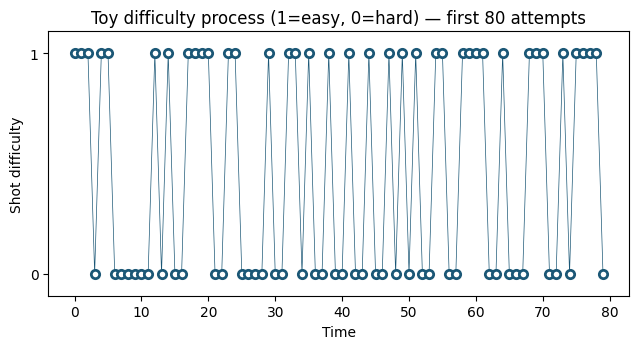

In [12]:
fig, ax = plt.subplots(1,1,figsize=(7.5,3.5),dpi=100)

ax.plot(diff[:80], marker="o", linestyle="-", color=CNET5442_COLORS[0], mfc='w', mew=2, lw=0.5)
ax.set_title("Toy difficulty process (1=easy, 0=hard) — first 80 attempts")
ax.set_xlabel("Time")
ax.set_ylabel("Shot difficulty")

ax.set_ylim(-0.1, 1.1)
ax.set_yticks([0,1])


plt.show()

### Case B — Same selection, but add a small 🔥 effect

Now we keep the *exact same* difficulty dynamics, but we add a small boost `fire_delta > 0`
after makes.

This lets us see something important:

- selection can **hide** a real 🔥 effect (if shots get harder after makes)
- selection can also **create** an illusory 🔥 effect (if shots get easier after makes)

Let's rerun with a small `fire_delta`.

In [13]:
fire_delta = 0.05  # small 🔥 boost after makes

yB = np.zeros(n, dtype=int)
diffB = np.zeros(n, dtype=int)

diffB[0] = 1 if np.random.rand() < 0.5 else 0
p0 = p_easy if diffB[0] == 1 else p_hard
yB[0] = 1 if np.random.rand() < p0 else 0

for t in range(1, n):
    if yB[t-1] == 1:
        diffB[t] = 1 if np.random.rand() < prob_easy_after_make else 0
    else:
        diffB[t] = 1 if np.random.rand() < prob_easy_after_miss else 0

    p_base = p_easy if diffB[t] == 1 else p_hard

    if yB[t-1] == 1:
        p_make = np.clip(p_base + fire_delta, 0, 1)
    else:
        p_make = p_base

    yB[t] = 1 if np.random.rand() < p_make else 0

In [14]:
lagB = yB[:-1]
yB_next = yB[1:]
diffB_next = diffB[1:]

pB_after_make = yB_next[lagB == 1].mean()
pB_after_miss = yB_next[lagB == 0].mean()

pB_easy_after_make_emp = diffB_next[lagB == 1].mean()
pB_easy_after_miss_emp = diffB_next[lagB == 0].mean()

print("Case B (small 🔥):")
print("  P(make | prev=make) =", round(pB_after_make, 3))
print("  P(make | prev=miss) =", round(pB_after_miss, 3))
print("  Difference (after-make minus after-miss) =", round(pB_after_make - pB_after_miss, 3))
print()
print("Selection check (difficulty mix):")
print("  P(easy | prev=make) =", round(pB_easy_after_make_emp, 3))
print("  P(easy | prev=miss) =", round(pB_easy_after_miss_emp, 3))

Case B (small 🔥):
  P(make | prev=make) = 0.544
  P(make | prev=miss) = 0.612
  Difference (after-make minus after-miss) = -0.068

Selection check (difficulty mix):
  P(easy | prev=make) = 0.43
  P(easy | prev=miss) = 0.588


### Mini "try this" (2 minutes)

1) Flip the selection pattern:
   - set `prob_easy_after_make = 0.60` and `prob_easy_after_miss = 0.40`
   - rerun Case A (no 🔥)

What happens to the sign of "after a make minus after a miss"?

2) Now keep that flipped selection, add `fire_delta = 0.05`, and rerun Case B.
Does selection amplify the 🔥 effect or wash it out?
_________
This is the core lesson of Trap #2:
**changes in difficulty/context can easily mimic (or hide) the hot hand.**

## Trap #3 — A common "after a make" estimator can be biased in finite sequences

A very common 🔥 statistic is the "after a make" rate:

$$
\hat p(1\mid 1)
= \frac{\#\{t: Y_{t-1}=1 \text{ and } Y_t=1\}}{\#\{t: Y_{t-1}=1\}}.
$$

In words: *look only at the times right after a make, and compute the fraction of those next shots that are makes.*


### Why this can be tricky (even under i.i.d.)

Even if shots are i.i.d. with a constant probability $p$ (no hot hand at all),

$$
Y_t \sim \text{Bernoulli}(p)\quad \text{i.i.d.},
$$

the estimator $\hat p(1\mid 1)$ can be biased in short sequences. What Miller & Sanjurjo (2018) [1] prove: in finite sequences, $\hat p_{1\mid 1}$ is generally **biased downward** under an i.i.d. Bernoulli null. The bias shrinks with sequence length $T$, but can be substantial for small $T$ and for longer streak conditioning. (And analogues of this issue show up in other "conditioning on streaks" statistics.)

Let's see the core idea in the smallest nontrivial example: $T=3$ fair coin flips.



[1] Miller, J. B., & Sanjurjo, A. (2018). Surprised by the hot hand fallacy? A truth in the law of small numbers. *Econometrica*, 86(6), 2019-2047.

### The smallest illustration: 3 fair coin flips

Let $1=\text{H}$ and $0=\text{T}$. We flip a fair coin 3 times, so the true $p=0.5$.

We'll enumerate all 8 sequences of length 3 and compute:

- $\#(1*)$: number of times the previous flip is 1 (i.e., number of "after-1 opportunities")
- $\#(11)$: number of adjacent "11" pairs
- $\hat p(1\mid 1) = \#(11)/\#(1*)$ (when defined)

In [15]:
from itertools import product

rows = []

for seq in product([0, 1], repeat=3):
    seq = np.array(seq, dtype=int)
    seq_str = "".join(map(str, seq))

    prev = seq[:-1]   # Y_{t-1} for t=1,2 (two positions)
    curr = seq[1:]    # Y_t      for t=1,2

    n1 = (prev == 1).sum()                     # #(1*)
    n11 = ((prev == 1) & (curr == 1)).sum()    # #(11)

    phat = (n11 / n1) if n1 > 0 else np.nan    # p̂(1|1)

    rows.append([seq_str, n1, n11, phat])

df = pd.DataFrame(rows, columns=["Sequence", "#(1*)", "#(11)", "p_hat(1|1)"])
df

,Sequence,#(1*),#(11),p_hat(1|1)
0,000,0,0,NaN
1,001,0,0,NaN
2,010,1,0,0.0
3,011,1,1,1.0
4,100,1,0,0.0
5,101,1,0,0.0
6,110,2,1,0.5
7,111,2,2,1.0


Now we compute the expected value of this estimator **over the sequences where it is defined** (i.e., where $\#(1*)>0$).


In [16]:
defined = df["p_hat(1|1)"].dropna()
defined.mean(), defined.mean() - 0.5

(0.4166666666666667, -0.08333333333333331)

In this case, you should see:

$$
\mathbb{E}\!\left[\hat p(1\mid 1)\ \middle|\ \#(1\ast)>0\right]
= \frac{5}{12} \approx 0.417.
$$

which is below the true $p=0.5$ for a fair coin.

### Intuition (what's causing the bias here?)

This is not coldness, per se. It's a finite-sample artifact.

In short sequences:
- sometimes there are very few** "after-1 opportunities" (small denominator)
- the estimator is a ratio**, and ratios behave weirdly when denominators vary a lot
- averaging these ratios over all possible short sequences ends up pulling the mean downward

So if you compute "after-make rate" in a short streak and get something below $0.5$, that is **not automatically evidence** of a cold hand.

## A clean fix: permutation (randomization) tests

Key idea:

Under a "no hot hand" null where the order should not matter, we can **shuffle** the sequence.

Shuffling:
- keeps the same total number of makes/misses
- destroys any serial dependence

So we can compare our observed 🔥 statistic to the distribution we’d get under many shuffles.
This handles a lot of finite-sample weirdness without heavy math.

In [17]:
# One "observed" sequence (here we just generate an i.i.d. example)
n = 60
p = 0.5
x = (np.random.rand(n) < p).astype(int)
x

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [18]:
# Observed statistic: p_after_make - p_after_miss
prev = x[:-1]
curr = x[1:]

p_after_make = curr[prev == 1].mean() if (prev == 1).sum() > 0 else np.nan
p_after_miss = curr[prev == 0].mean() if (prev == 0).sum() > 0 else np.nan
obs = p_after_make - p_after_miss

obs

0.11226851851851849

Now we build the permutation null distribution:

1. shuffle the sequence
2. recompute the same statistic
3. repeat many times

Then compute a two-sided p-value:

$$
p\text{-value} = \Pr\left(|T_{\text{null}}|\ge |T_{\text{obs}}|\right).
$$

In [19]:
n_perm = 7_500
null_stats = []

for _ in range(n_perm):
    x_perm = np.random.permutation(x)

    prev_p = x_perm[:-1]
    curr_p = x_perm[1:]

    # compute the same statistic on the permuted sequence
    if (prev_p == 1).sum() == 0 or (prev_p == 0).sum() == 0:
        continue  # very unlikely unless the sequence is all 0s or all 1s
    p_am = curr_p[prev_p == 1].mean()
    p_amis = curr_p[prev_p == 0].mean()
    null_stats.append(p_am - p_amis)

In [20]:
null_stats = np.array(null_stats)

pval_two_sided = np.mean(np.abs(null_stats) >= abs(obs))

print("Observed statistic (p_after_make - p_after_miss):", round(obs, 3))
print("Permutation p-value (two-sided):", round(pval_two_sided, 3))

Observed statistic (p_after_make - p_after_miss): 0.112
Permutation p-value (two-sided): 0.401


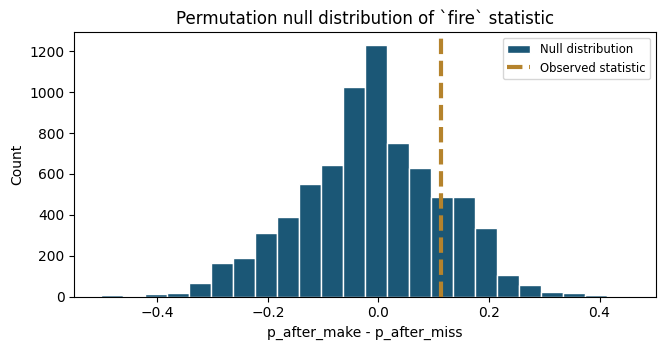

In [21]:
fig, ax = plt.subplots(1,1,figsize=(7.5,3.5),dpi=100)

ax.hist(null_stats, bins=24, edgecolor="w", color=CNET5442_COLORS[0], label='Null distribution')
ax.axvline(obs, linewidth=3, color=CNET5442_COLORS[1], ls='--', label='Observed statistic')
ax.legend(fontsize='small')
ax.set_title("Permutation null distribution of `fire` statistic")
ax.set_xlabel("p_after_make - p_after_miss")
ax.set_ylabel("Count")

plt.show()

#### Mini exercise

1) Change `n` from 60 down to 12 or 20 and rerun.
   - Does the null distribution get wider?
   - Do you see more “weird” observed values just from randomness?

2) Generate a sequence with a built-in 🔥 effect (later we’ll do this with a toy model), then see if the permutation test tends to give smaller $p$-values.

____________

## 🔥 Model: "Heating up" = a short-term predictive effect (lag-1)

According to our working definition, "Heating up" (🔥) means:

> after recent success, the *next* attempt is slightly more likely to succeed.

i.e., knowing the most recent outcome $Y_{t-1}$ tells you something about the next one $Y_t$. 

This means that knowing the most recent outcome $Y_{t-1}$ tells you something about the next one $Y_t$.

We'll work with a binary sequence:

- $Y_t = 1$ means "make"
- $Y_t = 0$ means "miss"

and we will build a toy model where only the immediately previous shot matters (a "lag-1" effect).

### Two equivalent ways to express 🔥

#### (A) Conditional-probability view

Pick a baseline make-rate $p_{\text{base}}$, then "nudge" it depending on the previous shot:

$$
\Pr(Y_t = 1 \mid Y_{t-1} = 1) = p_{\text{base}} + \delta,
\qquad
\Pr(Y_t = 1 \mid Y_{t-1} = 0) = p_{\text{base}} - \delta.
$$

Here $\delta$ controls how strong the 🔥 effect is. The "after" difference is:

$$
\Pr(1 \mid 1) - \Pr(1 \mid 0)
= (p_{\text{base}} + \delta) - (p_{\text{base}} - \delta)
= 2\delta.
$$

So if $\delta = 0.06$, the true difference is $2\delta = 0.12$.

#### (B) Regression view

In real data, we typically estimate effects using a regression model. The simplest "hot hand" regression is a one-predictor logistic regression:

$$
\Pr(Y_t = 1 \mid Y_{t-1}) = \sigma(\alpha + \beta Y_{t-1}),
\qquad
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

- If $\beta > 0$, the model predicts a higher make probability right after a make (🔥).
- $\exp(\beta)$ is an odds ratio: how the odds change when $Y_{t-1}$ goes from 0 to 1.

Below:
1) Simulate a 🔥 sequence (simple loop).  
2) Compute "after make" vs "after miss" rates by hand.  
3) Fit the lag-1 logistic regression and interpret $\beta$.

#### Step 0 — Choose toy parameters

- `n` = number of attempts
- `p_base` = baseline make probability
- `delta` = 🔥 strength

In this toy model the "ground truth" is:

$$
\Pr(1\mid 1)=p_{\text{base}}+\delta,\qquad \Pr(1\mid 0)=p_{\text{base}}-\delta,
$$

so the true after-difference is exactly $2\delta$.

In [22]:
n = 400
p_base = 0.50
delta = 0.06

print("P(make | last was make) =", p_base + delta)
print("P(make | last was miss) =", p_base - delta)
print("True after-difference (2*delta) =", 2 * delta)

P(make | last was make) = 0.56
P(make | last was miss) = 0.44
True after-difference (2*delta) = 0.12


#### Step 1 — Simulate a 🔥 sequence (lag-1 dependence)

We'll generate $Y_0, Y_1, \dots, Y_{n-1}$. Then:

- Draw the first outcome $Y_0$ using the baseline probability $p_{\text{base}}$.
- For each later time $t=1,2,\dots,n-1$:
  - If $Y_{t-1}=1$, set $p_t=p_{\text{base}}+\delta$.
  - If $Y_{t-1}=0$, set $p_t=p_{\text{base}}-\delta$.
  - Clip $p_t$ into a safe range (just in case).
  - Draw $Y_t \sim \text{Bernoulli}(p_t)$.

We'll also store the probability sequence $p_t$ so we can visualize what the model is doing.

In [23]:
y_fire = np.zeros(n, dtype=int)
p_series = np.zeros(n, dtype=float)

# First attempt: baseline probability
p_series[0] = p_base
y_fire[0] = 1 if np.random.rand() < p_series[0] else 0

print("Initialized first attempt:")
print("  y_fire[0]   =", y_fire[0])
print("  p_series[0] =", p_series[0])

Initialized first attempt:
  y_fire[0]   = 1
  p_series[0] = 0.5


In [24]:
for t in range(1, n):
    if y_fire[t-1] == 1:
        p_t = p_base + delta
    else:
        p_t = p_base - delta

    p_t = np.clip(p_t, 0.01, 0.99)  # keep it safely in (0,1)
    p_series[t] = p_t

    y_fire[t] = 1 if np.random.rand() < p_t else 0

In [25]:
print("First 10 outcomes:", y_fire[:10])
print("First 10 probabilities:", p_series[:10])

First 10 outcomes: [1 0 0 0 0 0 1 1 1 1]
First 10 probabilities: [0.5  0.56 0.44 0.44 0.44 0.44 0.44 0.56 0.56 0.56]


- The first few outcomes should look like a random 0/1 sequence.
- The overall make rate should be in a reasonable range (it will not equal $p_{\text{base}}$ exactly in a finite sample).
- The probability sequence $p_t$ should flip between two levels: $p_{\text{base}}+\delta$ and $p_{\text{base}}-\delta$.

In [26]:
print("First 30 outcomes:", y_fire[:30])
print("Overall make rate:", round(y_fire.mean(), 3))
print("Unique values of p_t in this run:", np.unique(p_series))

First 30 outcomes: [1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
Overall make rate: 0.538
Unique values of p_t in this run: [0.44 0.5  0.56]


#### Visualize what's happening over time
Plotting:
- the probability level $p_t$ (a step-like sequence)
- the outcomes $Y_t$ (0/1 points)

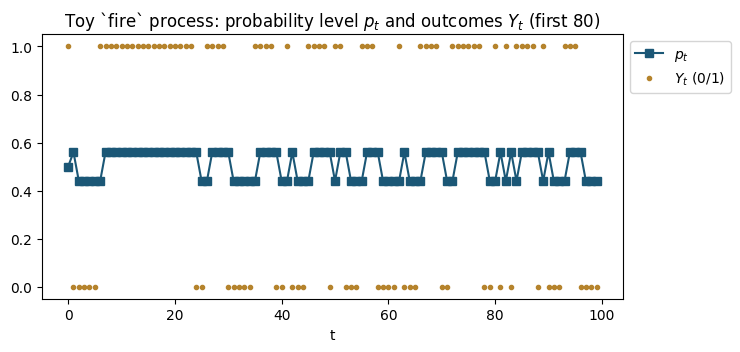

In [27]:
### T = 80  # just show the first 80 attempts

fig, ax = plt.subplots(1,1,figsize=(7.5,3.5),dpi=100)

ax.plot(p_series[:T], marker="s", linestyle="-", label=r"$p_t$", color=CNET5442_COLORS[0])
ax.plot(y_fire[:T], marker=".", lw=0, label=r"$Y_t$ (0/1)", color=CNET5442_COLORS[1])

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("t")

ax.set_title(r"Toy `fire` process: probability level $p_t$ and outcomes $Y_t$ (first 80)")

ax.legend(bbox_to_anchor=[1.0, 1.0], loc=2)

plt.show()

### Step 2 — Compute "after make" vs "after miss" rates by hand

The classic "hot hand" comparison is:

$$
\hat p(1\mid 1)
=
\frac{\#\{t: Y_{t-1}=1 \text{ and } Y_t=1\}}{\#\{t: Y_{t-1}=1\}},
\qquad
\hat p(1\mid 0)
=
\frac{\#\{t: Y_{t-1}=0 \text{ and } Y_t=1\}}{\#\{t: Y_{t-1}=0\}}.
$$

A direct way to compute this in code:

- `prev = y_fire[:-1]` is the lagged sequence $Y_{t-1}$
- `curr = y_fire[1:]` is the current sequence $Y_t$
- filter `curr` based on whether `prev` is 1 or 0, then take a mean

We'll also print the denominators, because finite denominators are the whole story behind Trap #3 later.

In [28]:
prev = y_fire[:-1]
curr = y_fire[1:]

mask_make = (prev == 1)
mask_miss = (prev == 0)

# denominators: number of "after-make" and "after-miss" opportunities
n_after_make = mask_make.sum()
n_after_miss = mask_miss.sum()

p_after_make = curr[mask_make].mean()
p_after_miss = curr[mask_miss].mean()

print("p_after_make =", round(p_after_make, 3), "( n =", n_after_make, ")")
print("p_after_miss =", round(p_after_miss, 3), "( n =", n_after_miss, ")")
print("difference   =", round(p_after_make - p_after_miss, 3))
print("true 2*delta =", round(2 * delta, 3))

p_after_make = 0.623 ( n = 215 )
p_after_miss = 0.435 ( n = 184 )
difference   = 0.188
true 2*delta = 0.12


### Interpreting the "after" difference

- In this toy model, the true after-difference is $2\delta$.
- In a finite sequence, the empirical difference will vary around $2\delta$ because of randomness.

A nice "stats intuition" add-on is to look at rough uncertainty. For a Bernoulli mean, a back-of-the-envelope standard error is:

$$
\text{SE}(\hat p) \approx \sqrt{\frac{\hat p(1-\hat p)}{n}}.
$$

We can apply this separately to "after make" and "after miss" groups. (Note: We are not doing serious inference here, just a sanity check about sampling noise.)

In [29]:
se_after_make = np.sqrt(p_after_make * (1 - p_after_make) / n_after_make)
se_after_miss = np.sqrt(p_after_miss * (1 - p_after_miss) / n_after_miss)

se_diff = np.sqrt(se_after_make**2 + se_after_miss**2)

print("Approx SE(p_after_make) =", round(se_after_make, 3))
print("Approx SE(p_after_miss) =", round(se_after_miss, 3))
print("Approx SE(difference)   =", round(se_diff, 3))

Approx SE(p_after_make) = 0.033
Approx SE(p_after_miss) = 0.037
Approx SE(difference)   = 0.049


### Step 3 — Fit the lag-1 logistic regression

Now we fit:

$$
\Pr(Y_t=1\mid Y_{t-1}) = \sigma(\alpha+\beta Y_{t-1}),
\qquad
\sigma(z)=\frac{1}{1+e^{-z}}.
$$

To fit it, we need a table where each row is a time $t$ that has a defined lag:

- `y` will be $Y_t$ for $t=1,\dots,n-1$
- `lag1` will be $Y_{t-1}$ for $t=1,\dots,n-1$

So we "drop" the first outcome because it has no previous shot.

In [30]:
df = pd.DataFrame({
    "y": y_fire[1:],
    "lag1": y_fire[:-1],
})
df

,y,lag1
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
394,1,1
395,1,1
396,1,1
397,1,1


### What do α and β mean?

The logistic regression model says:

$$
\log\left(\frac{p}{1-p}\right) = \alpha + \beta \cdot \text{lag1}.
$$


So:

- When `lag1 = 0` (after a miss), the log-odds are $\alpha$.
- When `lag1 = 1` (after a make), the log-odds are $\alpha+\beta$.


That means:

$$
\beta
=
\left[\log\left(\frac{p_{1}}{1-p_{1}}\right)\right]
-
\left[\log\left(\frac{p_{0}}{1-p_{0}}\right)\right],
$$

where $p_1=\Pr(Y_t=1\mid Y_{t-1}=1)$ and $p_0=\Pr(Y_t=1\mid Y_{t-1}=0)$.


Exponentiating turns this into an odds ratio:

$$
\exp(\beta)
=
\frac{\text{odds after make}}{\text{odds after miss}}
=
\frac{p_1/(1-p_1)}{p_0/(1-p_0)}.
$$

In plain language:
- if $\exp(\beta)=1$, no 🔥 effect
- if $\exp(\beta)>1$, odds are higher after a make (🔥)
- if $\exp(\beta)<1$, odds are lower after a make ("cold hand" pattern)

In [31]:
X = sm.add_constant(df["lag1"])  # adds intercept
logit_model = sm.Logit(df["y"], X).fit(disp=False)
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  399
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Feb 2026   Pseudo R-squ.:                 0.02583
Time:                        08:46:44   Log-Likelihood:                -268.40
converged:                       True   LL-Null:                       -275.51
Covariance Type:            nonrobust   LLR p-value:                 0.0001617
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2624      0.149     -1.764      0.078      -0.554       0.029
lag1           0.7658      0.205      3.740      0.000       0.364       1.167
==============================================================================
"""

### Reading the logistic regression output

This table is the standard `statsmodels` summary for a logistic regression. Our model is:

$$
\Pr(Y_t=1 \mid \text{lag1}) = \sigma(\alpha + \beta\,\text{lag1}),
\qquad
\sigma(z)=\frac{1}{1+e^{-z}},
$$

where `lag1 = Y_{t-1}` is 0 after a miss and 1 after a make.


#### What the top block means

- **Dep. Variable: y**  
  The outcome we are predicting is `y`, which here is the current shot $Y_t$ (0/1).

- **No. Observations: 399**  
  We have 399 rows because the first shot has no previous shot, so we model times $t=1,\dots,n-1$.

- **Df Model: 1**  
  There is 1 predictor (`lag1`).  
  **Df Residuals: 397** is basically $399 - 2$ because we estimate two parameters: the intercept and `lag1`.

- **Method: MLE**  
  Logistic regression is fit by maximum likelihood estimation.

- **Log-Likelihood** and **LL-Null**  
  `LL-Null` is the log-likelihood of a baseline model with only an intercept (no `lag1`).  
  `Log-Likelihood` is the log-likelihood with `lag1` included.  
  If including `lag1` helps, the log-likelihood should improve (be less negative).

- **LLR p-value**  
  This is the p-value for a likelihood-ratio test comparing the model with `lag1` to the intercept-only model.  
  A small value suggests `lag1` improves prediction beyond an intercept.

- **Pseudo R-squ.**  
  A logistic-regression analog of $R^2$ (not the same as linear regression). Small values are common even when an effect is real.

#### What the coefficient table means

Each row is a parameter estimate:

- **const** is $\hat\alpha$ (the intercept).  
  It is the log-odds of a make when `lag1 = 0` (after a miss).

- **lag1** is $\hat\beta$.  
  It is the change in log-odds when `lag1` goes from 0 to 1 (after a make vs after a miss).

The columns:

- **coef**: the estimate (e.g., $\hat\beta = 0.5957$)
- **std err**: standard error of the estimate
- **z**: test statistic $\hat\beta / \text{SE}(\hat\beta)$
- **P>|z|**: p-value for testing $H_0:\beta=0$
- **[0.025, 0.975]**: a 95% confidence interval for the parameter


#### Interpreting the key number here: `lag1 = 0.5957`

Because $\beta$ is in log-odds units, a useful translation is the odds ratio:

$$
\exp(\hat\beta)=\exp(0.5957)\approx 1.81.
$$

So in this toy run, the model says the **odds** of a make are about **1.8 times higher** right after a make than right after a miss.

(We also convert this to probabilities below using $\sigma(\hat\alpha)$ and $\sigma(\hat\alpha+\hat\beta)$.)

### Convert the fitted model into predicted probabilities

The model's predicted probabilities are:

$$
\hat p(\text{make}\mid \text{lag1}=0)=\sigma(\hat\alpha),
\qquad
\hat p(\text{make}\mid \text{lag1}=1)=\sigma(\hat\alpha+\hat\beta).
$$


We'll compute:

- $\hat\beta$ (log-odds effect)
- $\exp(\hat\beta)$ (odds ratio)
- predicted probabilities for `lag1=0` and `lag1=1`


Then we'll compare the model's predictions to the empirical "after" rates. With a single binary predictor, logistic regression is essentially learning two group probabilities (on the log-odds scale), so the numbers should be very close.

In [32]:
alpha = logit_model.params["const"]
beta = logit_model.params["lag1"]

odds_ratio = np.exp(beta)

p_hat_after_miss = 1 / (1 + np.exp(-alpha))
p_hat_after_make = 1 / (1 + np.exp(-(alpha + beta)))

print("beta (log-odds):", round(beta, 3))
print("odds ratio exp(beta):", round(odds_ratio, 3))
print("Model P(make | lag1=0):", round(p_hat_after_miss, 3))
print("Model P(make | lag1=1):", round(p_hat_after_make, 3))
print("Model difference:", round(p_hat_after_make - p_hat_after_miss, 3))
print()
print("Empirical p_after_miss:", round(p_after_miss, 3))
print("Empirical p_after_make:", round(p_after_make, 3))

beta (log-odds): 0.766
odds ratio exp(beta): 2.151
Model P(make | lag1=0): 0.435
Model P(make | lag1=1): 0.623
Model difference: 0.188

Empirical p_after_miss: 0.435
Empirical p_after_make: 0.623


### Visualize: empirical vs model-predicted probabilities

Let's plot two bars for each condition:

- empirical rates from Step 2
- model-predicted probabilities from Step 3

This makes it easy to see that the regression is capturing the same "after" pattern, just in a form that scales to real-world covariates later.

In [33]:
labels = ["after miss (lag1=0)", "after make (lag1=1)"]

empirical = [p_after_miss, p_after_make]
model_pred = [p_hat_after_miss, p_hat_after_make]


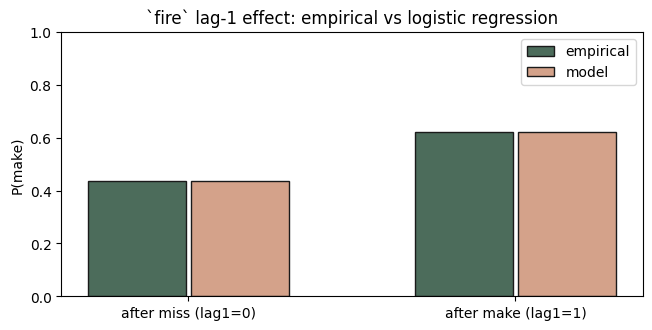

In [34]:
fig, ax = plt.subplots(1,1,figsize=(7.5,3.5), dpi=100)

x = np.arange(len(labels))
width = 0.30

ax.bar(x - 1.05*width/2, empirical, width, label="empirical", color=CNET5442_COLORS[6], ec='.1')
ax.bar(x + 1.05*width/2, model_pred, width, label="model", color=CNET5442_COLORS[7], ec='.1')

ax.set_xticks(x, labels, rotation=0)
ax.set_ylim(0, 1)
ax.set_ylabel("P(make)")
ax.set_title("`fire` lag-1 effect: empirical vs logistic regression")
ax.legend()

plt.show()

#### (Bonus/Optional) What is the long-run average make rate in this toy model?

Because this model makes $Y_t$ depend on $Y_{t-1}$, it is a simple 2-state Markov chain.

Let:

$$
p_1=\Pr(Y_t=1\mid Y_{t-1}=1)=p_{\text{base}}+\delta,
\qquad
p_0=\Pr(Y_t=1\mid Y_{t-1}=0)=p_{\text{base}}-\delta.
$$

If $\pi$ is the long-run fraction of 1s (makes), then stationarity means:

$$
\pi = \pi p_1 + (1-\pi)p_0.
$$

Solving gives:

$$
\pi = \frac{p_0}{1 - (p_1 - p_0)} = \frac{p_{\text{base}}-\delta}{1-2\delta}.
$$

For $p_{\text{base}}=0.5$, this simplifies to $\pi=0.5$ (so the long-run average matches 0.5).
But for other values, the long-run mean can shift a bit.

This is not essential for the hot-hand idea, but it's a useful reminder:
when you introduce dependence, "baseline" parameters do not always equal unconditional averages.

In [35]:
p1 = p_base + delta
p0 = p_base - delta

pi_stationary = (p0) / (1 - (p1 - p0))  # algebra from the markdown
print("p1 = P(1|1) =", p1)
print("p0 = P(1|0) =", p0)
print(r"Stationary fraction of 1s ($\pi$) =", round(pi_stationary, 3))

p1 = P(1|1) = 0.56
p0 = P(1|0) = 0.44
Stationary fraction of 1s ($\pi$) = 0.5


#### Mini "try this"

1) Change `delta` (try 0.00, 0.03, 0.10) and rerun Steps 1–3.
   - Does the empirical after-difference roughly track $2\delta$?
   - Does $\hat\beta$ increase as `delta` increases?

2) Change `p_base` (try 0.40 or 0.60) and rerun.
   - Do the predicted probabilities move in the direction you expect?
   - Does the optional stationary calculation change?

3) (For intuition) Set `delta=0.0`.
   - What should happen to the after-difference and to $\hat\beta$?
   - What do you actually see in a finite sample?

____________

## ⭐ Model: "Star mode" as a persistent latent state

The 🔥 model treated "heating up" as a *short-term predictive effect* of the last outcome.

The ⭐ model is a different story. It says "streakiness" can happen because the player enters a *persistent mode* that lasts for a while. The key idea is that there is a hidden state $S_t \in \{0,1\}$ that we do not observe directly:

- $S_t = 0$ means "normal" mode
- $S_t = 1$ means "star" mode

The state is persistent:

- $\Pr(S_t = 0 \mid S_{t-1} = 0)$ is high (you tend to stay normal)
- $\Pr(S_t = 1 \mid S_{t-1} = 1)$ is high (you tend to stay in star mode)

Outcomes come from the state:

$$
\Pr(Y_t = 1 \mid S_t = 0) = p_{\text{cold}},
\qquad
\Pr(Y_t = 1 \mid S_t = 1) = p_{\text{hot}}.
$$

This is a two-state hidden Markov model (HMM). We are not going to fit it here. We will just simulate it and use it as a toy comparison against 🔥.

In [36]:
# Toy parameters for the ⭐ model
n = 200

p_cold = 0.45
p_hot  = 0.70

stay_cold = 0.92   # P(S_t=0 | S_{t-1}=0)
stay_hot  = 0.85   # P(S_t=1 | S_{t-1}=1)

print("p_cold =", p_cold, "\t\t p_hot =", p_hot)
print("stay_cold =", stay_cold, "\t stay_hot =", stay_hot)

p_cold = 0.45 		 p_hot = 0.7
stay_cold = 0.92 	 stay_hot = 0.85


#### Step 1 — Simulate the hidden state sequence $S_t$

We will create two arrays:

- `s_star[t]` is the hidden state $S_t$ (0 or 1)
- `y_star[t]` is the observed outcome $Y_t$ (0 or 1)

We'll start in the normal state ($S_0=0$). Then for each $t\ge 1$:

- if $S_{t-1}=0$, we stay at 0 with probability `stay_cold`, otherwise switch to 1
- if $S_{t-1}=1$, we stay at 1 with probability `stay_hot`, otherwise switch to 0

In [37]:
s_star = np.zeros(n, dtype=int)  # hidden state
y_star = np.zeros(n, dtype=int)  # observed outcome

# Start in normal mode
s_star[0] = 0
s_star[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
for t in range(1, n):
    if s_star[t-1] == 0:
        # stay cold with prob stay_cold, otherwise switch to hot
        s_star[t] = 0 if np.random.rand() < stay_cold else 1
    else:
        # stay hot with prob stay_hot, otherwise switch to cold
        s_star[t] = 1 if np.random.rand() < stay_hot else 0

s_star[:30]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1])

#### Step 2 — Generate outcomes from the state

Now we generate $Y_t$ given $S_t$:

- if $S_t=0$, use $p_{\text{cold}}$
- if $S_t=1$, use $p_{\text{hot}}$

This is the entire "star mode" idea: the player makes more shots while in state 1, and the state tends to persist.

In [39]:
for t in range(n):
    p_t = p_hot if s_star[t] == 1 else p_cold
    y_star[t] = 1 if np.random.rand() < p_t else 0

print("First 30 outcomes:", y_star[:30])
print("Overall make rate:", round(y_star.mean(), 3))

First 30 outcomes: [0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
Overall make rate: 0.53


#### Step 3 — Sanity checks

Because we simulated the hidden state, we can directly check two things:

1) How often we were in star mode:
$$
\hat \pi_{\text{hot}} = \frac{1}{n}\sum_{t=0}^{n-1}\mathbb{1}\{S_t=1\}.
$$

2) Whether the make rate is higher in star mode than normal mode:
$$
\hat p_{\text{hot}} = \Pr(Y=1 \mid S=1), \qquad \hat p_{\text{cold}} = \Pr(Y=1 \mid S=0).
$$

In [40]:
frac_hot = s_star.mean()

p_emp_hot = y_star[s_star == 1].mean()
p_emp_cold = y_star[s_star == 0].mean()

print("Fraction of time in star state:", round(frac_hot, 3))
print("Empirical P(make | S=1):", round(p_emp_hot, 3))
print("Empirical P(make | S=0):", round(p_emp_cold, 3))

Fraction of time in star state: 0.4
Empirical P(make | S=1): 0.725
Empirical P(make | S=0): 0.4


### Optional: what fraction of time should be hot "in the long run"?

This two-state Markov chain has a stationary hot probability:

Let
$$
a = \Pr(0 \to 1) = 1-\text{stay_cold}, \qquad b = \Pr(1 \to 0) = 1-\text{stay_hot}.
$$

Then the stationary fraction hot is:

$$
\pi_{\text{hot}} = \frac{a}{a+b}.
$$

This is useful because it lets us predict the long-run average make rate:

$$
\Pr(Y=1) = \pi_{\text{hot}}\,p_{\text{hot}} + (1-\pi_{\text{hot}})\,p_{\text{cold}}.
$$

In [41]:
a = 1 - stay_cold
b = 1 - stay_hot

pi_hot = a / (a + b)
p_longrun = pi_hot * p_hot + (1 - pi_hot) * p_cold

print("Stationary hot fraction pi_hot:", round(pi_hot, 3))
print("Predicted long-run P(make):", round(p_longrun, 3))

Stationary hot fraction pi_hot: 0.348
Predicted long-run P(make): 0.537


### Visualize the first part of the sequence

We'll plot:

- outcomes $Y_t$ for the first $T$ attempts
- the hidden state $S_t$ for the first $T$ attempts

We will not include emoji characters in titles/labels to avoid font warnings from matplotlib.

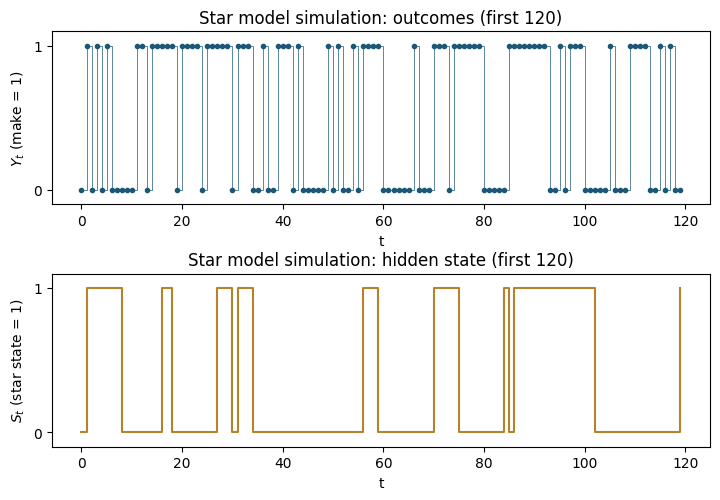

In [42]:
T = 120

fig, ax = plt.subplots(2, 1, figsize=(8.5, 5.5), dpi=100, facecolor="white")
plt.subplots_adjust(hspace=0.4)

ax[0].plot(y_star[:T], drawstyle="steps-post",
        color=CNET5442_COLORS[0], marker='.', lw=0.5)

ax[0].set_title("Star model simulation: outcomes (first 120)")
ax[0].set_xlabel("t")
ax[0].set_ylabel(r"$Y_t$ (make = 1)")
ax[0].set_yticks([0,1])
ax[0].set_ylim(-0.1, 1.1)


ax[1].plot(s_star[:T], drawstyle="steps-post",
        color=CNET5442_COLORS[1] if "CNET5442_COLORS" in globals() else None)

ax[1].set_title("Star model simulation: hidden state (first 120)")
ax[1].set_xlabel("t")
ax[1].set_ylabel(r"$S_t$ (star state = 1)")
ax[1].set_yticks([0,1])
ax[1].set_ylim(-0.1, 1.1)


plt.show()

## A first comparison: the lag-1 "after" statistic on ⭐ data

A natural question is: if we take ⭐ data and compute the classic lag-1 statistic,

$$
\hat p(1\mid 1) - \hat p(1\mid 0),
$$

do we automatically see a big effect?

...

Not necessarily!

In the ⭐ model, the next shot is driven by the hidden state $S_t$, not directly by the last outcome $Y_{t-1}$.

The last outcome *contains some information* about the state, but it is a noisy signal. In many parameter settings, the lag-1 difference can be modest, even when star mode is real.

In [43]:
prev = y_star[:-1]
curr = y_star[1:]

mask_make = (prev == 1)
mask_miss = (prev == 0)

p_after_make = curr[mask_make].mean() if mask_make.sum() > 0 else np.nan
p_after_miss = curr[mask_miss].mean() if mask_miss.sum() > 0 else np.nan

print("Star model:")
print("  p_after_make =", round(p_after_make, 3), "(n =", mask_make.sum(), ")")
print("  p_after_miss =", round(p_after_miss, 3), "(n =", mask_miss.sum(), ")")
print("  difference   =", round(p_after_make - p_after_miss, 3))

Star model:
  p_after_make = 0.61 (n = 105 )
  p_after_miss = 0.447 (n = 94 )
  difference   = 0.163


____
## 🔥 vs ⭐: conditioning on longer streaks

A simple diagnostic that separates these toy stories is to ask: "How does the probability of the next make change as the current streak gets longer?"

Define the conditional probability:

$$
\Pr\left(Y_t = 1 \mid Y_{t-1}=1, Y_{t-2}=1, \dots, Y_{t-k}=1\right).
$$

In a pure 🔥 lag-1 model, once you condition on $Y_{t-1}=1$, conditioning on $Y_{t-2}, Y_{t-3}, \dots$ should not add much. The model only "looks back" one step. In a ⭐ model, longer streaks are more informative because they provide stronger evidence that the hidden state is currently hot.

We'll estimate these "after $k$ makes" rates for both models on long simulated sequences.

In [44]:
n_long = 4000

# 🔥 parameters (reuse the same values as earlier, or change them)
p_base = 0.50
delta = 0.06

# ⭐ parameters (reuse the same values as above)
p_cold = 0.45
p_hot  = 0.70
stay_cold = 0.92
stay_hot  = 0.85

#### Step 1 — Simulate a long 🔥 sequence

Same model as before:

- after a make: $p_t = p_{\text{base}}+\delta$
- after a miss: $p_t = p_{\text{base}}-\delta$

In [45]:
y_fire_long = np.zeros(n_long, dtype=int)

# first outcome
y_fire_long[0] = 1 if np.random.rand() < p_base else 0

# lag-1 dependence
for t in range(1, n_long):
    p_t = p_base + delta if y_fire_long[t-1] == 1 else p_base - delta
    p_t = np.clip(p_t, 0.01, 0.99)
    y_fire_long[t] = 1 if np.random.rand() < p_t else 0

print("Fire long-run make rate:", round(y_fire_long.mean(), 3))

Fire long-run make rate: 0.5


#### Step 2 — Simulate a long ⭐ sequence

Same star-mode generator as above, but longer.

In [46]:
s_star_long = np.zeros(n_long, dtype=int)
y_star_long = np.zeros(n_long, dtype=int)

s_star_long[0] = 0

for t in range(1, n_long):
    if s_star_long[t-1] == 0:
        s_star_long[t] = 0 if np.random.rand() < stay_cold else 1
    else:
        s_star_long[t] = 1 if np.random.rand() < stay_hot else 0

for t in range(n_long):
    p_t = p_hot if s_star_long[t] == 1 else p_cold
    y_star_long[t] = 1 if np.random.rand() < p_t else 0

print("Star long-run make rate:", round(y_star_long.mean(), 3))
print("Star fraction hot:", round(s_star_long.mean(), 3))

Star long-run make rate: 0.546
Star fraction hot: 0.363


#### Step 3 — Estimate $P(\text{next make} \mid \text{last k makes})$

For each $k=1,2,\dots,k_{\max}$:

- scan across time $t=k,k+1,\dots$
- whenever the last $k$ outcomes are all 1, record the next outcome
- the estimate is successes / opportunities

We also print the number of opportunities, because as $k$ increases you naturally get fewer examples.

In [47]:
k_max = 6

fire_rates, fire_counts = [], []
for k in range(1, k_max + 1):
    count, success = 0, 0
    for t in range(k, len(y_fire_long)):
        if np.all(y_fire_long[t-k:t] == 1):
            count += 1
            success += y_fire_long[t]
    fire_rates.append(success / count if count > 0 else np.nan)
    fire_counts.append(count)

In [48]:
star_rates, star_counts = [], []
for k in range(1, k_max + 1):
    count, success = 0, 0
    for t in range(k, len(y_star_long)):
        if np.all(y_star_long[t-k:t] == 1):
            count += 1
            success += y_star_long[t]
    star_rates.append(success / count if count > 0 else np.nan)
    star_counts.append(count)

In [49]:
df_k = pd.DataFrame({
    "k": np.arange(1, k_max + 1),
    "P(next make | last k makes) - fire": fire_rates,
    "opportunities - fire": fire_counts,
    "P(next make | last k makes) - star": star_rates,
    "opportunities - star": star_counts
})
df_k

,k,P(next make | last k makes) - fire,opportunities - fire,P(next make | last k makes) - star,opportunities - star
0,1,0.563718,2001,0.566850,2184
1,2,0.560781,1127,0.589329,1237
2,3,0.564184,631,0.593407,728
3,4,0.542135,356,0.584687,431
4,5,0.575130,193,0.581673,251
5,6,0.585586,111,0.595890,146


#### Step 4 — Plot the k-dependent rates

What you should expect in this toy setup:

- Fire tends to show a bump mostly at $k=1$ (because only the last shot matters).
- Star can climb more with $k$ (because longer streaks are evidence the state is hot).

In real data, selection and context complicate this a lot, but this is the core intuition.

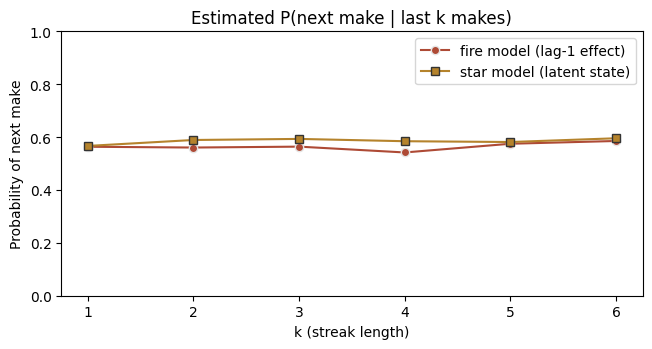

In [50]:
k = np.arange(1, k_max + 1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100, facecolor="white")

ax.plot(k, fire_rates, marker="o", mec='.9',
        label="fire model (lag-1 effect)",
        color=CNET5442_COLORS[3])

ax.plot(k, star_rates, marker="s", mec='.2',
        label="star model (latent state)",
        color=CNET5442_COLORS[1])

ax.set_title("Estimated P(next make | last k makes)")
ax.set_xlabel("k (streak length)")
ax.set_ylabel("Probability of next make")
ax.set_ylim(0, 1)
ax.legend()


plt.show()

## Optional: inferring "how hot" someone is over time with a simple Bayes filter

In the ⭐ model, the state $S_t$ is hidden. We only observe outcomes $Y_t$. If we assume we already know the model parameters (transition probabilities and make rates), we can compute:

$$
\Pr(S_t=1 \mid Y_0, Y_1, \dots, Y_t)
$$

for each time step $t$.

This is not fitting the model. It is only "given the parameters, what does the model think is the probability we are currently in star mode?"

Filtering has two repeated steps:

1. Predict step: move the current belief through the Markov transition.
2. Update step: adjust the belief using the new observation $Y_t$ via Bayes' rule.

We'll compute the posterior probability of star mode as a time series.

In [51]:
# We'll filter the shorter simulation y_star / s_star from above
y = y_star
s = s_star

prior_hot = 0.10  # P(S_0 = 1) before seeing any outcomes

post_hot = np.zeros(len(y))
p_hot_t = prior_hot

In [52]:
for t in range(len(y)):
    # 1) Predict: apply the state transition
    if t > 0:
        # P(S_t=1) = P(S_{t-1}=1)*stay_hot + P(S_{t-1}=0)*(1-stay_cold)
        p_hot_t = p_hot_t * stay_hot + (1 - p_hot_t) * (1 - stay_cold)

    # 2) Update: incorporate the observation y[t]
    if y[t] == 1:
        like_hot = p_hot
        like_cold = p_cold
    else:
        like_hot = 1 - p_hot
        like_cold = 1 - p_cold

    numer = p_hot_t * like_hot
    denom = numer + (1 - p_hot_t) * like_cold
    p_hot_t = numer / denom

    post_hot[t] = p_hot_t

In [53]:
post_hot[:10]

array([0.05714286, 0.18045738, 0.13262811, 0.25727265, 0.17364062,
       0.29714864, 0.19594237, 0.14069744, 0.11234707, 0.09825886])

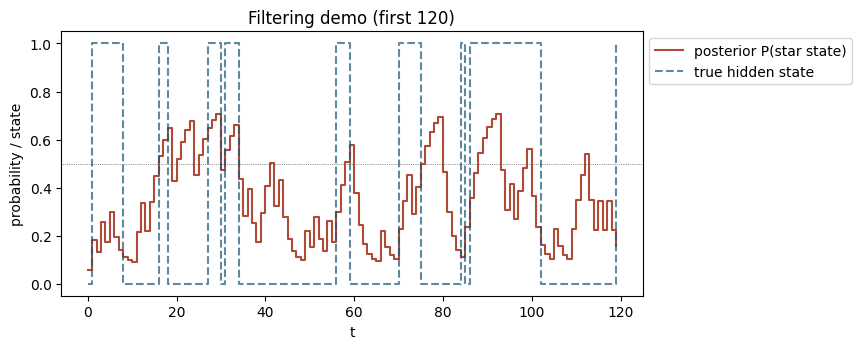

In [54]:
T = 120

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100, facecolor="white")
ax.set_facecolor("white")

ax.plot(post_hot[:T], drawstyle="steps-post", label="posterior P(star state)",
        color=CNET5442_COLORS[3])

ax.plot(s_star[:T], drawstyle="steps-post", label="true hidden state",
        color=CNET5442_COLORS[0], alpha=0.7, ls='--')

ax.axhline(0.5, color='k', zorder=0, lw=0.5, alpha=0.8, ls=':')

ax.set_title("Filtering demo (first 120)")
ax.set_xlabel("t")
ax.set_ylabel("probability / state")
ax.set_ylim(-0.05, 1.05)
ax.legend(loc=2, bbox_to_anchor=[1,1])

plt.show()

### What to take away from the ⭐ model

The fire story and the star story can both generate streaks, but they emphasize different mechanisms:

- 🔥: a short-term bump tied to the last outcome.
- ⭐️: a persistent hidden mode that lasts for a while.

The k-streak diagnostic is a simple way to put that difference on the table: if longer streaks keep increasing your predicted probability of the next make, that is more consistent with a persistent state story than a pure lag-1 story.

____________

## Fire vs star diagnostic (toy)

In a toy world, we can summarize a 0/1 sequence with a couple quick numbers that try to separate two stories:


### Summary 1: lag-1 effect (more "fire"-ish)

This is the classic "after" difference:

$$
\widehat{\Delta}_{\text{lag1}} = \hat p(1\mid 1) - \hat p(1\mid 0).
$$

If the process is truly lag-1 (the fire story), this number tends to be positive.


### Summary 2: extra "streak length" boost (more "star"-ish)

Now compare the next-shot probability after a long streak versus after a single make:

$$
\widehat{\Delta}_{\text{streak}} = \hat p(\text{next make} \mid \text{last 4 makes}) - \hat p(\text{next make} \mid \text{last 1 make}).
$$


Intuition:

- In a pure lag-1 fire model, once you know the last shot was a make, knowing that the last *four* were makes should not add much.
- In a star-state model, longer streaks are stronger evidence that the hidden state is currently "hot", so this can be positive.

This is not a real inference procedure. It is a toy diagnostic meant to build intuition.

### Plan

1) Simulate many sequences from the fire model and compute the two summaries.  
2) Simulate many sequences from the star model and compute the same summaries.  
3) Plot the summaries against each other and compare where the simulations tend to land.

We'll also compute one extra descriptive number for each sequence: the longest run of 1s (just to see if one model tends to generate longer streaks).

In [55]:
np.random.seed(21)

n_sims = 400
n = 200

# fire parameters
p_base = 0.50
delta = 0.06

# star parameters
p_cold = 0.45
p_hot  = 0.70
stay_cold = 0.92
stay_hot  = 0.85

In [56]:
print("n_sims =", n_sims, ", n =", n)
print("fire: p_base =", p_base, ", delta =", delta)
print("star: p_cold =", p_cold, ", p_hot =", p_hot, ", stay_cold =", stay_cold, ", stay_hot =", stay_hot)

n_sims = 400 , n = 200
fire: p_base = 0.5 , delta = 0.06
star: p_cold = 0.45 , p_hot = 0.7 , stay_cold = 0.92 , stay_hot = 0.85


#### Step 1 — Simulate many fire sequences

We'll store all simulations in an array of shape `(n_sims, n)` so we can compute features in a second step.

In [57]:
y_fire_sims = np.zeros((n_sims, n), dtype=int)

for i in range(n_sims):
    y = np.zeros(n, dtype=int)

    # first outcome
    y[0] = 1 if np.random.rand() < p_base else 0

    # lag-1 dependence
    for t in range(1, n):
        p_t = p_base + delta if y[t-1] == 1 else p_base - delta
        p_t = np.clip(p_t, 0.01, 0.99)
        y[t] = 1 if np.random.rand() < p_t else 0

    y_fire_sims[i] = y

y_fire_sims.shape

(400, 200)

#### Step 2 — Compute features for each fire sequence

For each simulated sequence, compute:

1) $\widehat{\Delta}_{\text{lag1}} = \hat p(1\mid 1) - \hat p(1\mid 0)$

2) $\widehat{\Delta}_{\text{streak}} = \hat p(\text{next make} \mid \text{last 4 makes}) - \hat p(\text{next make} \mid \text{last 1 make})$

3) Longest run of 1s

Notes:

- $\hat p(\text{next make} \mid \text{last 1 make})$ is essentially $\hat p(1\mid 1)$, but we will compute it using the same "scan the sequence" method we use for $k=4$, so the logic is uniform.
- For $k=4$, there might be sequences with zero opportunities. In that case the estimate is undefined and we'll record `np.nan`.

In [58]:
fire_lag1 = np.zeros(n_sims, dtype=float)
fire_streak_boost = np.zeros(n_sims, dtype=float)
fire_longest_run = np.zeros(n_sims, dtype=float)

In [59]:
for i in range(n_sims):
    y = y_fire_sims[i].astype(int)

    # ---- (1) lag-1 effect: p(1|1) - p(1|0)
    prev = y[:-1]
    curr = y[1:]

    mask1 = (prev == 1)
    mask0 = (prev == 0)

    if mask1.sum() == 0 or mask0.sum() == 0:
        fire_lag1[i] = np.nan
    else:
        p11 = curr[mask1].mean()
        p10 = curr[mask0].mean()
        fire_lag1[i] = p11 - p10

    # ---- (2) streak probabilities: P(next make | last k makes) for k=1 and k=4
    # k = 1
    count1, succ1 = 0, 0
    for t in range(1, len(y)):
        if y[t-1:t].sum() == 1:  # last 1 is a make
            count1 += 1
            succ1 += y[t]
    p_k1 = succ1 / count1 if count1 > 0 else np.nan

    # k = 4
    k = 4
    count4, succ4 = 0, 0
    for t in range(k, len(y)):
        if np.all(y[t-k:t] == 1):
            count4 += 1
            succ4 += y[t]
    p_k4 = succ4 / count4 if count4 > 0 else np.nan

    fire_streak_boost[i] = p_k4 - p_k1 if (not np.isnan(p_k4) and not np.isnan(p_k1)) else np.nan

    # ---- (3) longest run of 1s
    longest = 0
    current = 0
    for val in y:
        if val == 1:
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    fire_longest_run[i] = longest

fire_lag1[:5], fire_streak_boost[:5], fire_longest_run[:5]

(array([0.12527783, 0.1959596 , 0.10235342, 0.15660097, 0.12555556]),
 array([ 0.15486194,  0.0040404 , -0.19354839, -0.00275482,  0.05555556]),
 array([ 9.,  7.,  5., 10.,  7.]))

#### Step 3 — Simulate many star sequences

Each simulation has a hidden state $S_t$ that persists.
We will only store the observed outcomes $Y_t$ for this mini-lab, since the features are computed from the observed sequence.

In [60]:
y_star_sims = np.zeros((n_sims, n), dtype=int)

for i in range(n_sims):
    s = np.zeros(n, dtype=int)
    y = np.zeros(n, dtype=int)

    # start normal
    s[0] = 0

    # simulate hidden state
    for t in range(1, n):
        if s[t-1] == 0:
            s[t] = 0 if np.random.rand() < stay_cold else 1
        else:
            s[t] = 1 if np.random.rand() < stay_hot else 0

    # emit outcomes from the state
    for t in range(n):
        p_t = p_hot if s[t] == 1 else p_cold
        y[t] = 1 if np.random.rand() < p_t else 0

    y_star_sims[i] = y

y_star_sims.shape

(400, 200)

#### Step 4 — Compute features for each star sequence

Same three quantities as for fire:

- lag-1 effect
- streak boost (k=4 minus k=1)
- longest run of 1s

In [61]:
star_lag1 = np.zeros(n_sims, dtype=float)
star_streak_boost = np.zeros(n_sims, dtype=float)
star_longest_run = np.zeros(n_sims, dtype=float)

In [62]:
for i in range(n_sims):
    y = y_star_sims[i].astype(int)

    # ---- (1) lag-1 effect
    prev = y[:-1]
    curr = y[1:]

    mask1 = (prev == 1)
    mask0 = (prev == 0)

    if mask1.sum() == 0 or mask0.sum() == 0:
        star_lag1[i] = np.nan
    else:
        p11 = curr[mask1].mean()
        p10 = curr[mask0].mean()
        star_lag1[i] = p11 - p10

    # ---- (2) streak probabilities (k=1 and k=4)
    # k = 1
    count1, succ1 = 0, 0
    for t in range(1, len(y)):
        if y[t-1:t].sum() == 1:
            count1 += 1
            succ1 += y[t]
    p_k1 = succ1 / count1 if count1 > 0 else np.nan

    # k = 4
    k = 4
    count4, succ4 = 0, 0
    for t in range(k, len(y)):
        if np.all(y[t-k:t] == 1):
            count4 += 1
            succ4 += y[t]
    p_k4 = succ4 / count4 if count4 > 0 else np.nan

    star_streak_boost[i] = p_k4 - p_k1 if (not np.isnan(p_k4) and not np.isnan(p_k1)) else np.nan

    # ---- (3) longest run of 1s
    longest = 0
    current = 0
    for val in y:
        if val == 1:
            current += 1
            longest = max(longest, current)
        else:
            current = 0
    star_longest_run[i] = longest

star_lag1[:5], star_streak_boost[:5], star_longest_run[:5]

(array([-0.04192104,  0.06525253, -0.12793522, -0.0797502 ,  0.18380567]),
 array([-0.10185185,  0.03894737, -0.07719298, -0.07807808, -0.10175439]),
 array([ 6.,  9.,  5., 11.,  7.]))

#### Step 5 — Put everything in a table and summarize

We will also drop any simulations where the streak boost is undefined (usually because there were zero opportunities for 4 makes in a row).

In [63]:
df_feats = pd.DataFrame({
    "model": (["fire"] * n_sims) + (["star"] * n_sims),
    "lag1_effect": np.concatenate([fire_lag1, star_lag1]),
    "streak_boost": np.concatenate([fire_streak_boost, star_streak_boost]),
    "longest_run_ones": np.concatenate([fire_longest_run, star_longest_run]),
})

df_feats_clean = df_feats.dropna().reset_index(drop=True)

df_feats_clean.groupby("model")[["lag1_effect", "streak_boost", "longest_run_ones"]].mean().round(3)

,lag1_effect,streak_boost,longest_run_ones
model,,,
fire,0.122,-0.027,8.16
star,0.037,0.009,8.65


#### Step 6 — Scatter plot: lag-1 effect vs streak boost

Interpretation guide:

- The x-axis is "fire-like": does the last shot predict the next one?
- The y-axis is "star-like": do longer streaks add extra predictive power?

This is just a toy visualization, but it often makes the conceptual difference between the two stories feel concrete.

In [64]:
# split the clean dataframe
fire_df = df_feats_clean[df_feats_clean["model"] == "fire"]
star_df = df_feats_clean[df_feats_clean["model"] == "star"]

c_fire = CNET5442_COLORS[0]
c_star = CNET5442_COLORS[3]

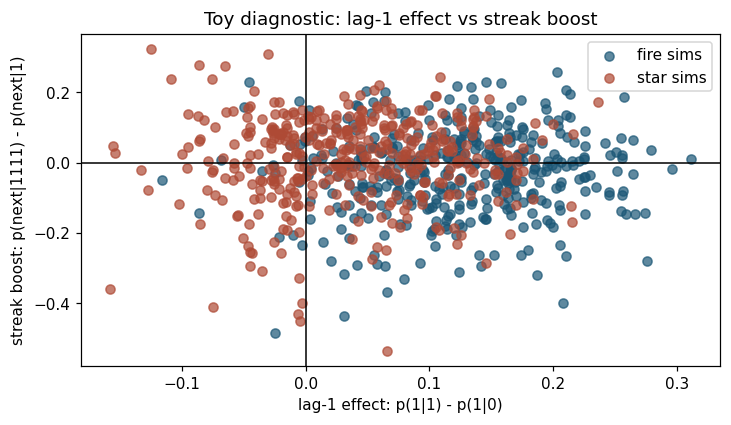

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4.0), dpi=110, facecolor="white")

ax.scatter(fire_df["lag1_effect"], fire_df["streak_boost"], alpha=0.7, label="fire sims", color=c_fire)
ax.scatter(star_df["lag1_effect"], star_df["streak_boost"], alpha=0.7, label="star sims", color=c_star)

ax.axhline(0, color="k", linewidth=1)
ax.axvline(0, color="k", linewidth=1)

ax.set_title("Toy diagnostic: lag-1 effect vs streak boost")
ax.set_xlabel("lag-1 effect: p(1|1) - p(1|0)")
ax.set_ylabel("streak boost: p(next|1111) - p(next|1)")
ax.legend()

plt.show()

### What you should see (in this toy setup)

You should usually see something like:

- Fire simulations tend to have a larger positive lag-1 effect.
- Star simulations can have a smaller lag-1 effect, but a more positive streak boost.
- Star simulations often have a slightly larger longest run of 1s on average (not guaranteed, but common under these parameters).

The most important lesson is not "this is a classifier". The lesson is:

Different mechanisms can produce streakiness, and you need diagnostics that map onto the mechanism you care about.

### Some exercises

1) Increase persistence in the star model (e.g., raise `stay_hot` from 0.85 to 0.95).  
   What happens to the streak boost?

2) Make the hot and cold probabilities closer together (e.g., change `p_hot` from 0.70 to 0.60).  
   Does the star cloud move closer to the fire cloud?

3) Change `n` from 200 down to 80.  
   Do both clouds get noisier? Do you see more undefined streak boosts because 4-long streaks are rarer?

## Quick Bayes!

Up to now, we have been treating conditional make rates like ordinary sample averages. That is fine for point estimates, but it does not tell us how uncertain those estimates are.

A simple Bayesian way to represent uncertainty for a probability is:

1) Put a Beta prior on an unknown probability $\theta$.  
2) Observe Binomial data (successes and failures).  
3) Get a Beta posterior (conjugacy).


If
$$
\theta \sim \text{Beta}(a,b),
$$
and we observe $s$ successes and $f$ failures, then
$$
\theta \mid \text{data} \sim \text{Beta}(a+s, b+f).
$$


We'll apply this to the two conditional probabilities we have been using all class:

$$
p_1 = \Pr(Y_t=1 \mid Y_{t-1}=1),
\qquad
p_0 = \Pr(Y_t=1 \mid Y_{t-1}=0).
$$


Then we will compute a Bayesian probability statement:
$$
\Pr(p_1 > p_0 \mid \text{data}).
$$


This is not a full model of shot difficulty or selection (Trap #2 still exists). This is just a clean way to quantify uncertainty for the basic conditional rates.

In [66]:
from scipy import stats

#### Step 1 — Turn a 0/1 sequence into counts

Choose any 0/1 sequence `y` (for example, the `y_fire` sequence from the 🔥 section).

We will compute:

- After-make group (prev = 1):
  - $s_1$ = number of successes (next shot = 1)
  - $f_1$ = number of failures  (next shot = 0)

- After-miss group (prev = 0):
  - $s_0$ = number of successes
  - $f_0$ = number of failures

These are exactly the inputs the Beta-Binomial update needs.

In [67]:
# Pick the sequence you want to analyze
# (This assumes you already created y_fire earlier. You can swap in y_star, real data, etc.)
y = y_fire

y = np.asarray(y).astype(int)
prev = y[:-1]
curr = y[1:]

mask1 = (prev == 1)  # after-make opportunities
mask0 = (prev == 0)  # after-miss opportunities

s1 = int(curr[mask1].sum())
f1 = int(mask1.sum() - s1)

s0 = int(curr[mask0].sum())
f0 = int(mask0.sum() - s0)

print("Counts:")
print("  after make: successes s1 =", s1, ", failures f1 =", f1, ", total =", s1 + f1)
print("  after miss: successes s0 =", s0, ", failures f0 =", f0, ", total =", s0 + f0)

Counts:
  after make: successes s1 = 134 , failures f1 = 81 , total = 215
  after miss: successes s0 = 80 , failures f0 = 104 , total = 184


#### Step 2 — Choose a Beta prior and compute the posterior

We'll use a simple "uniform" prior:

$$
p_1 \sim \text{Beta}(a,b),\qquad p_0 \sim \text{Beta}(a,b)
$$

with $a=b=1$.

Then the posteriors are:

$$
p_1 \mid \text{data} \sim \text{Beta}(a+s_1, b+f_1),
\qquad
p_0 \mid \text{data} \sim \text{Beta}(a+s_0, b+f_0).
$$

We'll summarize each posterior with a 95% credible interval.

In [68]:
a = 1
b = 1

a1 = a + s1
b1 = b + f1

a0 = a + s0
b0 = b + f0

ci1 = stats.beta.ppf([0.025, 0.975], a1, b1)
ci0 = stats.beta.ppf([0.025, 0.975], a0, b0)

print("Posterior Beta parameters:")
print("  p1 | data ~ Beta(a1, b1) =", (a1, b1))
print("  p0 | data ~ Beta(a0, b0) =", (a0, b0))
print()
print("95% credible intervals:")
print("  p1 = P(make | prev make):", np.round(ci1, 3))
print("  p0 = P(make | prev miss):", np.round(ci0, 3))

Posterior Beta parameters:
  p1 | data ~ Beta(a1, b1) = (135, 82)
  p0 | data ~ Beta(a0, b0) = (81, 105)

95% credible intervals:
  p1 = P(make | prev make): [0.557 0.685]
  p0 = P(make | prev miss): [0.365 0.507]


#### Step 3 — Compute a posterior probability statement: $P(p_1 > p_0 \mid \text{data})$

A nice thing about Bayes is that it lets us make a direct probability statement like:

$$
\Pr(p_1 > p_0 \mid \text{data}).
$$

We will approximate it by Monte Carlo:

1) sample many draws from the posterior of $p_1$  
2) sample many draws from the posterior of $p_0$  
3) compute the fraction of draws where $p_1 > p_0$

In [69]:
draws = 200_000

p1_samps = np.random.beta(a1, b1, size=draws)
p0_samps = np.random.beta(a0, b0, size=draws)

post_prob = np.mean(p1_samps > p0_samps)

print("Posterior P(p1 > p0) =", round(float(post_prob), 3))

Posterior P(p1 > p0) = 1.0


#### Optional: visualize the two posterior distributions

This plot shows how uncertain we are about $p_1$ and $p_0$.

A common reading is:
- more separation between the curves suggests stronger evidence that $p_1$ and $p_0$ differ
- heavy overlap suggests we do not know much from the data alone

This is still about the simple conditional rates. It does not fix selection effects (Trap #2).

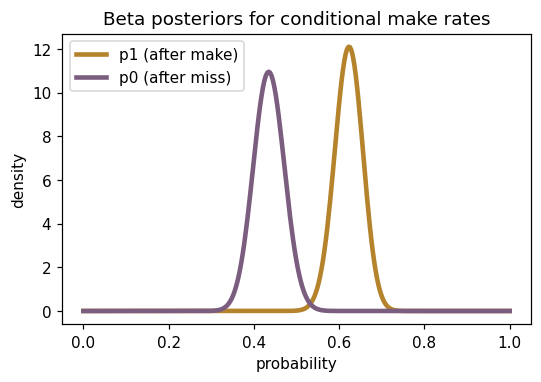

In [70]:
xs = np.linspace(0, 1, 300)

pdf1 = stats.beta.pdf(xs, a1, b1)
pdf0 = stats.beta.pdf(xs, a0, b0)

c1 = CNET5442_COLORS[1]
c0 = CNET5442_COLORS[5]

fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5), dpi=110, facecolor="white")

ax.plot(xs, pdf1, label="p1 (after make)", color=c1, lw=3)
ax.plot(xs, pdf0, label="p0 (after miss)", color=c0, lw=3)

ax.set_title("Beta posteriors for conditional make rates")
ax.set_xlabel("probability")
ax.set_ylabel("density")
ax.legend()

plt.show()

# PART II: MUCH MORE INVOLVED, HOPEFULLY THIS IS USEFUL

_______
## A cleaner setting: professional darts (replicating Ötting et al., JRSS-A 2020)


Darts is a useful "stress test" for the hot-hand debate because it is closer to the **repeatable-trials** ideal than basketball:

- A dart throw has **almost no defense** and relatively stable geometry (standard board, standard distance).
- Players throw in **fixed 3-dart turns**, which gives a natural within-turn vs across-turn comparison.
- The main remaining confounds are still real (fatigue, pressure, target choice), but they are often **smaller** than in basketball.


![](images/data_darts.png)

Ötting et al. (2020) use this setting to ask a sharp question:

> Is there evidence that a player's success probability is *serially correlated* beyond what we expect from player skill + dart position?

This section does two things:

1. Replicates the descriptive tables and diagnostics in the paper using the provided dataset.
2. Uses darts as a conceptual bridge to our 🔥 vs ⭐️ framing:
   - 🔥: short-run predictability like $P(y_t=1\mid y_{t-1}=1)$
   - ⭐️: a latent *form/state* process that shifts the baseline success probability for multiple throws


In [71]:
import re
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, BoundaryNorm


# ============================================================
# Style (muted rings; slightly greyer black wedges)
# ============================================================
RING_RED = "#AE4A35"      # muted brick
RING_GREEN = "#4C6C5B"    # muted green
WEDGE_DARK = "#2E2E2E"    # greyer than pure black
WEDGE_LIGHT = "#F2F2F2"   # light wedge


# ============================================================
# Dartboard geometry (standard numbering + approximate ring radii)
# ============================================================
# Standard dartboard number order (clockwise, starting at 20 on top)
_DART_ORDER = [20, 1, 18, 4, 13, 6, 10, 15, 2, 17, 3, 19, 7, 16, 8, 11, 14, 9, 12, 5]
_NUM_TO_IDX = {n: i for i, n in enumerate(_DART_ORDER)}
_WEDGE = 2 * np.pi / 20

# Radii are normalized (0=center, 1=outer edge). Approximate but looks good.
_RINGS = {
    "inner_bull": (0.00, 0.05),
    "outer_bull": (0.05, 0.10),
    "inner_single": (0.10, 0.58),
    "triple": (0.58, 0.65),
    "outer_single": (0.65, 0.93),
    "double": (0.93, 1.00),
}


# ============================================================
# Data helpers
# ============================================================
def darts_derive_segment(d: pd.DataFrame) -> np.ndarray:
    """
    Map each row to the segment label (string-ish) for that throw.

    The dataset stores three label columns (t1,t2,t3) and an 'ind' column
    indicating which dart within the turn produced this row.
    """
    return np.select(
        [d["ind"].eq("t1pt"), d["ind"].eq("t2pt"), d["ind"].eq("t3pt")],
        [d["t1"], d["t2"], d["t3"]],
        default=np.nan,
    )


def add_derived_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds convenient columns if missing:
      - _row_id: stable row id (used to define within-leg order)
      - row_in_inner: within (name, TSID) order
      - segment: scored segment for each throw
      - remaining_after: remaining points after the throw

    Safe to call multiple times.
    """
    df = df.copy()

    # stable row id (if you call this right after read_csv, it locks in file order)
    if "_row_id" not in df.columns:
        df["_row_id"] = np.arange(len(df), dtype=int)

    # within-leg order (uses _row_id so it stays stable even if you sort later)
    if "row_in_inner" not in df.columns:
        order = df.sort_values(["name", "TSID", "_row_id"])
        row_in_inner = order.groupby(["name", "TSID"], sort=False).cumcount() + 1
        df["row_in_inner"] = row_in_inner.sort_index()

    if "segment" not in df.columns:
        df["segment"] = darts_derive_segment(df)

    if "remaining_after" not in df.columns:
        df["remaining_after"] = df["pbt"].astype(float) - df["points"].astype(float)

    return df


def select_leg(df: pd.DataFrame, name: str = None, TSID: int = None) -> pd.DataFrame:
    """
    Select a single player-leg (sequence of throws) grouped by (name, TSID).
    If (name, TSID) are provided, select that group.
    Otherwise pick a leg whose final remaining_after is small (nice for visualization).
    """
    df = add_derived_columns(df)

    if (name is not None) and (TSID is not None):
        d = df[(df["name"] == name) & (df["TSID"] == TSID)].copy()
        if len(d) == 0:
            raise ValueError("No rows matched the provided (name, TSID).")
        return d.sort_values("row_in_inner").reset_index(drop=True)

    gcols = ["name", "TSID"]
    df_sorted = df.sort_values(gcols + ["row_in_inner"]).copy()
    last_rows = df_sorted.groupby(gcols, as_index=False).tail(1).copy()
    last_rows["abs_rem"] = last_rows["remaining_after"].abs()

    best = last_rows.sort_values("abs_rem").iloc[0]
    pick = (best["name"], best["TSID"])
    d = df_sorted[(df_sorted["name"] == pick[0]) & (df_sorted["TSID"] == pick[1])].copy()
    return d.reset_index(drop=True)


# ============================================================
# Segment parsing + fake XY placement on a dartboard
# ============================================================
def _parse_segment(seg):
    """
    Convert a segment label into a (ring, num) pair:
      - ring in {"single","double","triple","bull","outer_bull","miss","unknown"}
      - num is the wedge number when relevant (e.g. 20)

    Supports: "T20", "D19", "20", "Bullseye", "Bull", "50", "25", "Bounce out".
    """
    if seg is None or (isinstance(seg, float) and np.isnan(seg)):
        return ("unknown", None)

    s = str(seg).strip()

    # common miss labels
    if s.lower() in {"bounce out", "bounceout", "miss", "0", "out"}:
        return ("miss", None)

    # bulls
    if s.lower() in {"bullseye", "bull", "db", "50"}:
        return ("bull", None)
    if s.lower() in {"25", "outer bull", "outerbull"}:
        return ("outer_bull", None)

    # doubles/triples like "D20" / "T19"
    m = re.fullmatch(r"([DT])\s*(\d+)", s)
    if m:
        return ("triple" if m.group(1) == "T" else "double", int(m.group(2)))

    # singles like "20"
    if re.fullmatch(r"\d+", s):
        return ("single", int(s))

    return ("unknown", s)


def _segment_to_xy(seg, rng, jitter=True):
    """
    Map a segment label to a plausible (x,y) point on a normalized dartboard.

    Because we do not have true (x,y) coordinates, this places each dart at a random
    location inside the correct wedge/ring when jitter=True.
    """
    ring, num = _parse_segment(seg)

    # numbered wedges
    if ring in {"single", "triple", "double"} and num in _NUM_TO_IDX:
        idx = _NUM_TO_IDX[num]
        center = np.pi / 2 - idx * _WEDGE  # 20 at top, clockwise
        theta = rng.uniform(center - 0.45 * _WEDGE, center + 0.45 * _WEDGE) if jitter else center

        if ring == "triple":
            r0, r1 = _RINGS["triple"]
        elif ring == "double":
            r0, r1 = _RINGS["double"]
        else:
            # dataset doesn't encode inner vs outer single; use outer single for viz
            r0, r1 = _RINGS["outer_single"]

        r = rng.uniform(r0, r1) if jitter else 0.5 * (r0 + r1)
        return r * np.cos(theta), r * np.sin(theta)

    # bulls
    if ring in {"bull", "outer_bull"}:
        theta = rng.uniform(0, 2 * np.pi)
        r0, r1 = (_RINGS["inner_bull"] if ring == "bull" else _RINGS["outer_bull"])
        # uniform-in-area sampling looks more natural
        r = np.sqrt(rng.uniform(r0**2, r1**2)) if jitter else 0.5 * (r0 + r1)
        return r * np.cos(theta), r * np.sin(theta)

    # misses/unknowns: place outside the board
    theta = rng.uniform(0, 2 * np.pi)
    r = rng.uniform(1.05, 1.20)
    return r * np.cos(theta), r * np.sin(theta)


# ============================================================
# Drawing the board
# ============================================================
def _draw_board(ax, show_numbers=True):
    """Draw a stylized dartboard on an axis."""
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    for i, num in enumerate(_DART_ORDER):
        center = np.pi / 2 - i * _WEDGE
        start = (center - _WEDGE / 2) * 180 / np.pi
        end = (center + _WEDGE / 2) * 180 / np.pi

        # alternating wedges + alternating ring colors
        single_color = WEDGE_DARK if i % 2 == 0 else WEDGE_LIGHT
        ring_color = RING_RED if i % 2 == 0 else RING_GREEN

        # inner single (outer bull -> triple start)
        r0 = _RINGS["outer_bull"][1]
        r1 = _RINGS["triple"][0]
        ax.add_patch(
            patches.Wedge(
                (0, 0), r1, start, end, width=r1 - r0,
                facecolor=single_color, edgecolor="k", linewidth=0.4
            )
        )

        # triple ring
        r0, r1 = _RINGS["triple"]
        ax.add_patch(
            patches.Wedge(
                (0, 0), r1, start, end, width=r1 - r0,
                facecolor=ring_color, edgecolor="k", linewidth=0.4
            )
        )

        # outer single (triple end -> double start)
        r0 = _RINGS["triple"][1]
        r1 = _RINGS["double"][0]
        ax.add_patch(
            patches.Wedge(
                (0, 0), r1, start, end, width=r1 - r0,
                facecolor=single_color, edgecolor="k", linewidth=0.4
            )
        )

        # double ring
        r0, r1 = _RINGS["double"]
        ax.add_patch(
            patches.Wedge(
                (0, 0), r1, start, end, width=r1 - r0,
                facecolor=ring_color, edgecolor="k", linewidth=0.4
            )
        )

        if show_numbers:
            ax.text(
                1.08 * np.cos(center), 1.08 * np.sin(center), str(num),
                ha="center", va="center", fontsize=8
            )

    # bulls
    ax.add_patch(
        patches.Circle((0, 0), _RINGS["outer_bull"][1],
                       facecolor=RING_GREEN, edgecolor="k", linewidth=0.6)
    )
    ax.add_patch(
        patches.Circle((0, 0), _RINGS["inner_bull"][1],
                       facecolor=RING_RED, edgecolor="k", linewidth=0.6)
    )

    ax.set_xlim(-1.25, 1.25)
    ax.set_ylim(-1.25, 1.25)


def _text_color_for_rgba(rgba, thresh=0.55):
    """Choose black/white text for readability on a colored marker."""
    r, g, b = rgba[:3]
    lum = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return "black" if lum > thresh else "white"


# ============================================================
# Main plotting function (board + trajectory + tall colorbar)
# ============================================================
def plot_dartboard_plus_trajectory(
    d,
    *,
    seed=7,
    jitter=True,
    cmap_name="viridis",
    max_throw_for_cmap=20,      # standardize colors across plots (throw #1..max_throw_for_cmap)
    traj_height_frac=0.86,      # shrink right subplot to match board circle visually
    cbar_yspan=(450, 50),       # colorbar spans this y-range on the trajectory axis (in data units)
    cbar_width_frac=0.12,
    cbar_pad_frac=0.06,
    s_board=150,
    s_traj=55,
    alpha=0.97,
    edgecolor=".9",
    linewidth=0.8,
    throw_fontsize=7,
    y_max=501,
    dpi=300,
):
    """
    Two-panel figure:
      Left: dartboard with numbered throws (1..n), colored by throw order.
      Right: remaining score after each throw, with a dashed connector line.

    Because we do not have true (x,y) coordinates, positions are jittered within
    the correct wedge/ring using a random seed.

    NOTE: This dataset is truncated to throws with pbt >= 180, so trajectories
    typically stop above 0.
    """
    d = add_derived_columns(pd.DataFrame(d))
    d = d.sort_values("row_in_inner").reset_index(drop=True)

    n = len(d)
    throw_order = np.arange(1, n + 1)

    # Standardize colors across different-length legs:
    throw_for_color = np.clip(throw_order, 1, max_throw_for_cmap)

    # Discrete colormap with fixed bins
    base = plt.get_cmap(cmap_name)
    discrete_colors = base(np.linspace(0, 1, max_throw_for_cmap))
    cmap = ListedColormap(discrete_colors, name=f"{cmap_name}_{max_throw_for_cmap}")
    bounds = np.arange(0.5, max_throw_for_cmap + 1.5, 1.0)
    norm = BoundaryNorm(bounds, max_throw_for_cmap)

    # Fake board positions (random within segment because you don't have real XY)
    rng = np.random.default_rng(seed)
    xy = np.array([_segment_to_xy(x, rng, jitter=jitter) for x in d["segment"]])

    # Remaining series: start + after each throw
    remaining_start = float(d["pbt"].iloc[0])
    remaining_after = d["remaining_after"].to_numpy(float)
    remaining = np.concatenate([[remaining_start], remaining_after])
    steps = np.arange(len(remaining))  # 0..n

    # Layout
    fig, (ax_board, ax_traj) = plt.subplots(
        ncols=2,
        figsize=(10, 7),
        dpi=dpi,
        gridspec_kw={"width_ratios": [4, 1], "wspace": 0.10},
    )

    # --- Left: board ---
    _draw_board(ax_board, show_numbers=True)

    ax_board.scatter(
        xy[:, 0], xy[:, 1],
        s=s_board,
        c=throw_for_color,
        cmap=cmap,
        norm=norm,
        alpha=alpha,
        edgecolors=edgecolor,
        linewidths=linewidth,
        zorder=5,
    )

    for k, (x, y) in enumerate(xy, start=1):
        kk = int(np.clip(k, 1, max_throw_for_cmap))
        rgba = cmap(norm(kk))
        ax_board.text(
            x, y, str(k),
            ha="center", va="center",
            fontsize=throw_fontsize,
            fontweight="bold",
            color=_text_color_for_rgba(rgba),
            zorder=6,
        )

    ax_board.set_title(
        f"{d['name'].iloc[0]}: board (colors standardized to throw #1-{max_throw_for_cmap})"
    )

    # --- Right: trajectory ---
    ax_traj.plot(steps, remaining, linewidth=1.2, color=".2", linestyle="--")

    ax_traj.scatter(
        throw_order, remaining_after,
        s=s_traj,
        c=throw_for_color,
        cmap=cmap,
        norm=norm,
        alpha=alpha,
        edgecolors=edgecolor,
        linewidths=linewidth,
        zorder=3,
    )

    ax_traj.set_title("remaining score", fontsize=10)
    ax_traj.set_xlabel("throw #", fontsize=9)
    ax_traj.set_ylabel("remaining", fontsize=9)
    ax_traj.tick_params(labelsize=8)
    ax_traj.grid(True, alpha=0.25)

    ax_traj.set_xlim(0, max(n + 1, 6))
    ax_traj.set_ylim(y_max, 0)  # inverted axis (bigger remaining lower on plot)

    # Make trajectory subplot shorter (match board circle visually)
    fig.canvas.draw()
    pos_board = ax_board.get_position()
    pos_traj = ax_traj.get_position()

    new_traj_h = pos_board.height * traj_height_frac
    new_traj_y0 = pos_board.y0 + (pos_board.height - new_traj_h) / 2
    ax_traj.set_position([pos_traj.x0, new_traj_y0, pos_traj.width, new_traj_h])

    # Manual colorbar axis so Matplotlib doesn't resize it on redraw
    pos_traj = ax_traj.get_position()  # updated after set_position()

    y0, y1 = ax_traj.get_ylim()  # (y_max, 0)
    def y_to_frac(y):
        return (y - y0) / (y1 - y0)

    y_low, y_high = cbar_yspan
    f0, f1 = sorted([y_to_frac(y_low), y_to_frac(y_high)])

    cax_y0 = pos_traj.y0 + f0 * pos_traj.height
    cax_h = (f1 - f0) * pos_traj.height

    cax_w = pos_traj.width * cbar_width_frac
    cax_pad = pos_traj.width * cbar_pad_frac
    cax_x0 = pos_traj.x1 + cax_pad

    cax = fig.add_axes([cax_x0, cax_y0, cax_w, cax_h])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ticks = np.arange(1, max_throw_for_cmap + 1)
    cbar = fig.colorbar(sm, cax=cax, boundaries=bounds, ticks=ticks)
    cbar.set_label("throw #", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    return fig, (ax_board, ax_traj, cax)


### Data (paper Section 2)

The dataset is already preprocessed in the paper's style:

- Each row is one throw.
- The sample is truncated to throws with remaining score $\ge 180$ (early/mid-leg), to keep targets comparable.
- A binary "success" variable is defined as hitting
  $$H = \{T11, T12, \dots, T20, \text{Bullseye}\}.$$

In words: *high triples or the bull*, while the leg is still in a phase where players mostly pursue high-scoring targets.

We'll load `data/darts/data/data_df.csv` and verify a few key facts (counts, players, truncation).


In [72]:
darts_path = 'data/darts/data/data_df.csv'
darts_raw = pd.read_csv(darts_path)
print("Loaded:", darts_path)
darts_raw.shape

Loaded: data/darts/data/data_df.csv


(167492, 13)

In [73]:
darts_raw.head()

,name,pbt1,t1,pbt2,t2,pbt3,t3,points,ind,pbt,wonprevious,triple,TSID
0,Gary Anderson,501,20,481,T5,466,T20,20,t1pt,501,0,0,1
1,Gary Anderson,501,20,481,T5,466,T20,15,t2pt,481,0,0,1
2,Gary Anderson,501,20,481,T5,466,T20,60,t3pt,466,0,1,1
3,Gary Anderson,406,5,401,T20,341,T19,5,t1pt,406,0,0,1
4,Gary Anderson,406,5,401,T20,341,T19,60,t2pt,401,0,1,1


### A quick visual: a dartboard + a leg trajectory (for intuition)

One pedagogical annoyance with darts data is that we typically have **scored segments** (`T20`, `D19`, `Bullseye`, …), not true $(x,y)$ coordinates.

So the visualization below does something *honest but approximate*:

- Each throw is plotted at a random point inside the correct wedge/ring (jittered).
- The purpose is pattern intuition, not spatial inference.

We'll pick one player-leg (one `name, TSID` pair) and plot:

- Left: where the darts landed (color = throw number).
- Right: remaining score after each throw (we only observe throws while remaining score before the throw is $\ge 180$).


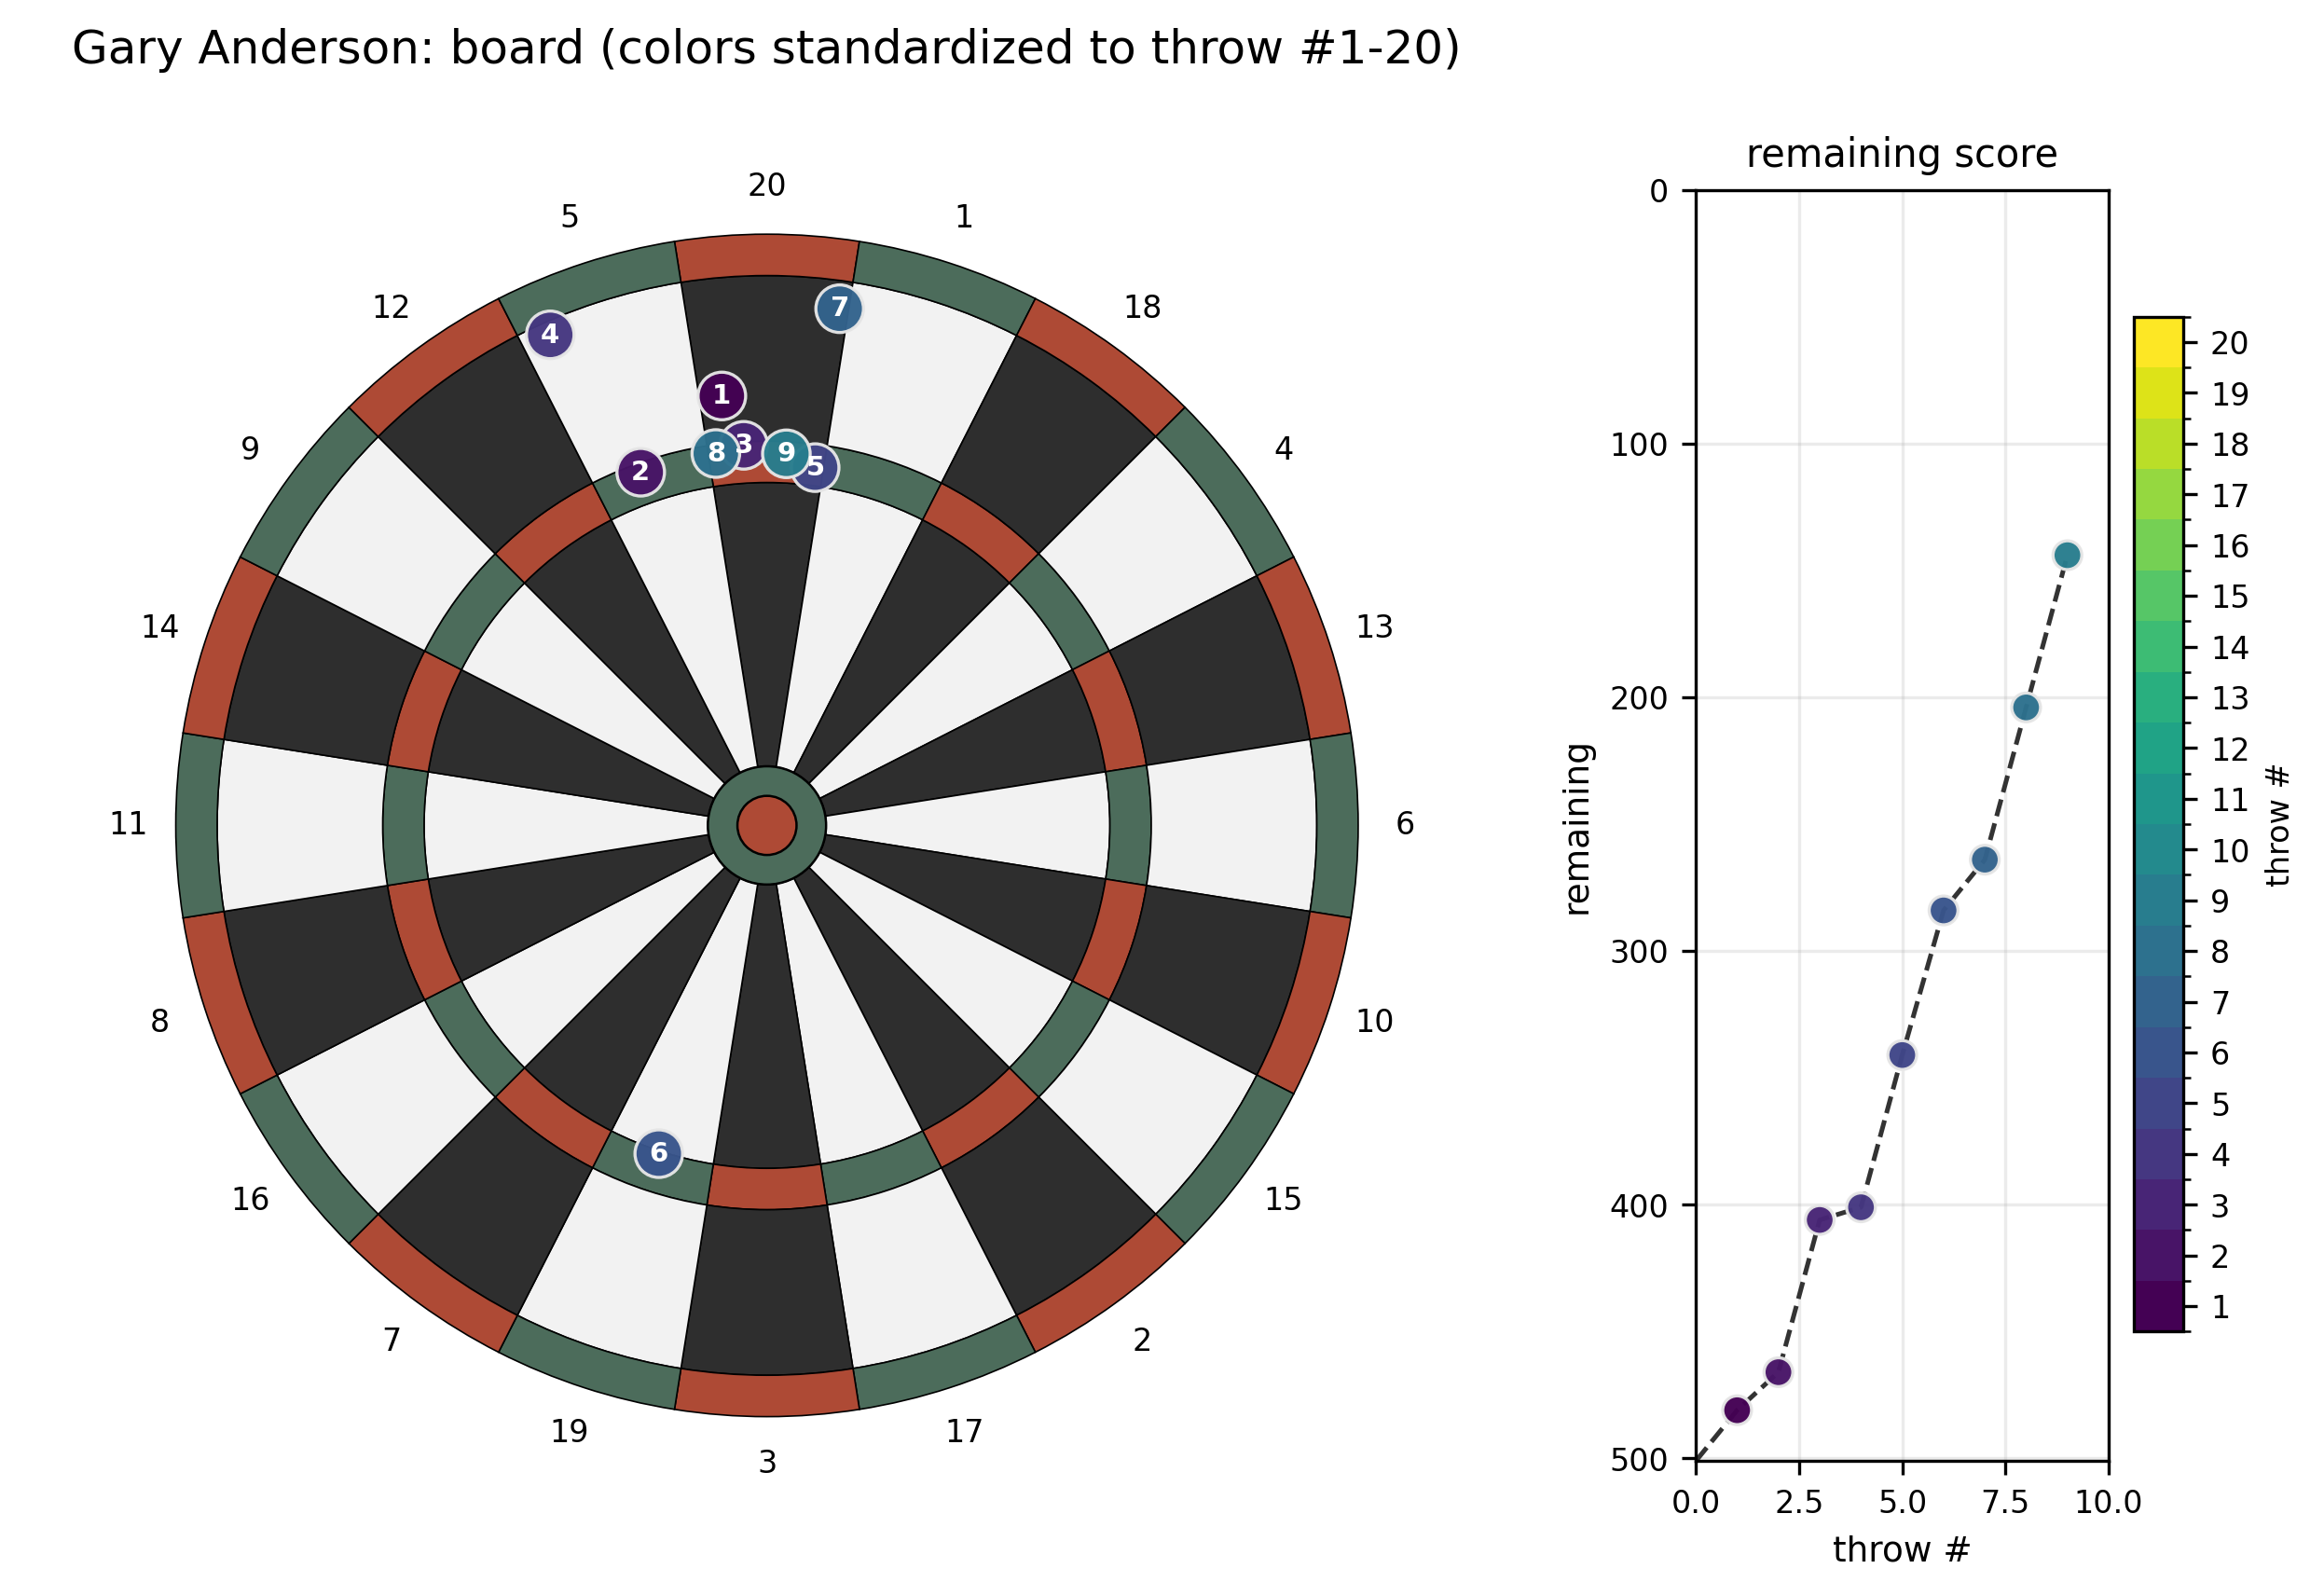

In [74]:
darts_for_plot = add_derived_columns(darts_raw)
leg = select_leg(darts_for_plot, name="Gary Anderson", TSID=1)

fig, axes = plot_dartboard_plus_trajectory(leg, seed=9, jitter=True,
                                           max_throw_for_cmap=20, cbar_yspan=(450, 50),
                                           dpi=300)
plt.show()

In [75]:
# Sanity checks against the paper's description
n_throws = len(darts_raw)
n_players = darts_raw["name"].nunique()

print("Throws:", n_throws)
print("Players:", n_players)

# The truncation rule in the paper keeps throws with remaining score >= 180.
print("min(pbt):", darts_raw["pbt"].min())
print("fraction with pbt < 180:", float((darts_raw["pbt"] < 180).mean()))

assert n_players == 73, "Paper reports 73 players."
assert darts_raw["pbt"].min() >= 180, "This file should already be truncated at 180."

Throws: 167492
Players: 73
min(pbt): 180
fraction with pbt < 180: 0.0


### Replicating Table 1: how often do players hit each element of $H$?

The paper's Table 1 reports frequencies for **which target** in $H$ was hit (T11…T20, Bullseye).

To replicate it, we need one more derived variable:

- `segment`: the scored segment label for the throw (e.g., `"T20"`, `"19"`, `"Bullseye"`)

The file stores three throw-label columns `t1,t2,t3` and an indicator `ind ∈ {t1pt,t2pt,t3pt}` telling us which one applies for that row.


In [76]:
darts = add_derived_columns(darts_raw)

In [77]:
# Define the "success set" H = {T11,...,T20,Bullseye}
H = [f"T{i}" for i in range(11, 21)] + ["Bullseye"]

tab1 = (
    darts["segment"]
    .value_counts()
    .reindex(H, fill_value=0)
    .rename_axis("segment")
    .reset_index(name="count")
)
tab1["proportion"] = tab1["count"] / len(darts)


In [78]:
# Display in the same order as the paper (T11..T20, Bull)
tab1

,segment,count,proportion
0,T11,1,0.000006
1,T12,3,0.000018
2,T13,1,0.000006
3,T14,0,0.000000
4,T15,6,0.000036
5,T16,4,0.000024
6,T17,546,0.003260
7,T18,1709,0.010203
8,T19,9897,0.059089
9,T20,53509,0.319472


A good replication check: the largest mass should be on **T20** (most common high-scoring target).  
In this dataset, you should see `T20` around $0.32$ of *all throws* (not just hits in $H$), matching Table 1.

### A first "hot hand" sanity check: success rate by dart position (1st, 2nd, 3rd)

Before any time-series model, the paper emphasizes something simple and important:

- Darts **within a turn** are not identical.
- Darts 2 and 3 often have *higher* success probability than dart 1.

This can happen even without any psychological "hot hand."  
A plausible mechanism is a **marker dart**: the first dart provides information or a physical reference, affecting later darts.

Let's compute the raw success rate by `ind ∈ {t1pt,t2pt,t3pt}`.




In [79]:
# Map ind -> dart position {1,2,3}
darts["dart_in_turn"] = darts["ind"].map({"t1pt": 1, "t2pt": 2, "t3pt": 3}).astype(int)

pos_rates = (
    darts.groupby("dart_in_turn")["triple"]
    .mean()
    .rename("success_rate")
    .reset_index()
)
pos_rates

,dart_in_turn,success_rate
0,1,0.355188
1,2,0.408557
2,3,0.420110


If darts 2 and 3 have higher success rates than dart 1, that is *already* a form of within-turn dependence — but it's a dependence on **position** (a known covariate), not necessarily a latent "heating up" process.

This is exactly why we keep separating:

- 🔥 "after a make" effects (conditioning on $y_{t-1}$),
- ⭐️ latent-state effects (time-varying baseline), and
- plain covariate effects (like dart position or shot difficulty).


### Model 1 (paper Section 3.2): logistic regression with player effects + dart-position effects

Model 1 assumes conditional independence across throws:

$$
y_t \mid \pi_t \sim \text{Bernoulli}(\pi_t), \qquad
\text{logit}(\pi_t) = \beta_{0,p(t)} + \beta_1 \mathbb{I}\{\text{dart}=2\} + \beta_2 \mathbb{I}\{\text{dart}=3\}.
$$

Where:

- $y_t \in \{0,1\}$: success indicator for throw $t$ (our `triple` column).
- $p(t)$: which player took throw $t$ (our `name` column).
- $\beta_{0,p}$: a player-specific baseline log-odds (skill).
- $\beta_1,\beta_2$: log-odds shifts for darts 2 and 3 relative to dart 1.
- $\text{logit}(x)=\log\frac{x}{1-x}$.

Key assumption: **no hot hand** beyond player + position. So any serial correlation is explained away by these static effects.

We'll fit this using `statsmodels` (so we can easily read log-likelihood and AIC).

In [80]:
import statsmodels.formula.api as smf

# Keep a tidy subset of columns for modeling.
darts_m = darts[["name", "TSID", "row_in_inner", "ind", "dart_in_turn", "triple", "wonprevious"]].copy()

# Make sure ind is treated as categorical with a clear reference level.
darts_m["ind"] = pd.Categorical(darts_m["ind"], categories=["t1pt", "t2pt", "t3pt"], ordered=True)

# Model 1: player-specific intercepts + dart position effects.
# "0 + C(name)" gives one intercept per player (no global intercept).
model1 = smf.glm(
    formula="triple ~ 0 + C(name) + C(ind, Treatment(reference='t1pt'))",
    data=darts_m,
    family=sm.families.Binomial(),
).fit()

print(model1.summary().tables[1])

                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
C(name)[Adrian Lewis]                          -0.6237      0.039    -16.110      0.000      -0.700      -0.548
C(name)[Alan Norris]                           -0.6780      0.038    -17.797      0.000      -0.753      -0.603
C(name)[Andy Boulton]                          -0.6869      0.086     -7.982      0.000      -0.856      -0.518
C(name)[Benito van de Pas]                     -0.7255      0.045    -16.301      0.000      -0.813      -0.638
C(name)[Brendan Dolan]                         -0.8326      0.085     -9.739      0.000      -1.000      -0.665
C(name)[Chris Dobey]                           -0.8239      0.058    -14.251      0.000      -0.937      -0.711
C(name)[Chris Quantock]                        -0.7145      0.071    -10.087      0.000      -0.853     

In [81]:
# Extract the dart-position coefficients (beta1 and beta2 in the paper)
dart2_name = "C(ind, Treatment(reference='t1pt'))[T.t2pt]"
dart3_name = "C(ind, Treatment(reference='t1pt'))[T.t3pt]"

beta1_hat = float(model1.params[dart2_name])
beta2_hat = float(model1.params[dart3_name])

beta1_hat, beta2_hat

(0.22833017659559113, 0.27637771635131836)

In the paper, these coefficients are positive: darts 2 and 3 are easier *on average*, even after controlling for player skill. That's not "hot hand" yet, maybe just a predictable covariate. Now compute AIC for Model 1. The definition is:

$$
\text{AIC} = -2\,\ell(\hat\theta) + 2k,
$$

where:

- $\ell(\hat\theta)$ is the maximized log-likelihood,
- $k$ is the number of free parameters.

Here $k = 73$ player effects $+\ 2$ dart-position effects $=75$.

In [82]:
ll1 = float(model1.llf)
k1 = int(len(model1.params))
aic1 = -2 * ll1 + 2 * k1

print("Model 1 log-likelihood:", ll1)
print("Model 1 #params:", k1)
print("Model 1 AIC:", aic1)

Model 1 log-likelihood: -111526.1301285433
Model 1 #params: 75
Model 1 AIC: 223202.2602570866


### Models 2-3: ⭐️ a latent "form" process (state space / HMM view)

The paper introduces a time-varying latent process $s_t$ that shifts success probability:

$$
\text{logit}(\pi_t) = \beta_{0,p(t)} + \beta_1 \mathbb{I}\{\text{dart}=2\} + \beta_2 \mathbb{I}\{\text{dart}=3\} + s_t.
$$

So:

- $s_t > 0$ means the player is in a temporarily stronger-than-usual state (⭐️ "star-ish"),
- $s_t < 0$ means weaker-than-usual.


To make this a hot-hand model, we assume serial correlation in $s_t$.

**Model 2 (paper):** one AR(1) process for all transitions:
$$
s_t = \phi\, s_{t-1} + \sigma\,\varepsilon_t, \quad \varepsilon_t\sim\mathcal N(0,1).
$$

**Model 3 (paper):** different dynamics within a turn vs across turns:
- within-turn: $(\phi_w, \sigma_w)$
- across-turn: $(\phi_a, \sigma_a)$

This is conceptually very close to asking:

- 🔥 do we see immediate predictability within a tight cluster of actions?
- ⭐️ does that predictability *carry* across meaningful breaks?

We'll reproduce the paper's Table 4 comparison (AIC).  
Implementation note: the paper discretizes the continuous latent state onto a grid and uses a forward algorithm (HMM-style).

In [83]:
import json

If the helper module is available, the next cell loads the paper's published parameter estimates (from JSON files) and evaluates the likelihood via the forward algorithm.

This is still a faithful replication of **Table 4** because AIC only depends on:

- the likelihood function,
- the parameter values,
- the count of parameters.

We are not *re-fitting* Models 2-3 here because full MLE fitting of state space models can take time; the goal is to replicate the paper's reported model comparison and diagnostics once parameters are set.

In [84]:
from data.darts.hot_hand_darts.grid import make_state_grid
from data.darts.hot_hand_darts.models import negloglik_model2, negloglik_model3
from data.darts.hot_hand_darts.preprocess import build_leg_sequences

p2_path = 'data/darts/model2_params.json'
p3_path = 'data/darts/model3_params.json'
params2 = json.load(open(p2_path, "r"))
params3 = json.load(open(p3_path, "r"))

# Build the nested leg structure expected by the likelihood functions.
# A "leg" here is a player-specific throw sequence for a given (name, TSID).
darts_seq = darts_m[["name", "TSID", "row_in_inner", "dart_in_turn", "triple", "wonprevious"]].copy()
darts_seq = darts_seq.rename(columns={"row_in_inner": "throw_in_leg"})
player_order, legs_by_player = build_leg_sequences(darts_seq)

In [85]:
def theta_from_params_model2(params, player_order):
    theta = np.concatenate(
        [
            np.array(
                [
                    params["phi"],
                    np.log(params["sigma"]),
                    params["mu_delta_win"],
                    params["mu_delta_lose"],
                    np.log(params["sigma_delta"]),
                    params["throw2"],
                    params["throw3"],
                ],
                dtype=float,
            ),
            np.array([params["beta_by_player"][p] for p in player_order], dtype=float),
        ]
    )
    return theta

def theta_from_params_model3(params, player_order):
    theta = np.concatenate(
        [
            np.array(
                [
                    params["phi_within"],
                    params["phi_across"],
                    np.log(params["sigma_within"]),
                    np.log(params["sigma_across"]),
                    params["mu_delta_win"],
                    params["mu_delta_lose"],
                    np.log(params["sigma_delta"]),
                    params["throw2"],
                    params["throw3"],
                ],
                dtype=float,
            ),
            np.array([params["beta_by_player"][p] for p in player_order], dtype=float),
        ]
    )
    return theta

In [86]:
theta2 = theta_from_params_model2(params2, player_order)
theta3 = theta_from_params_model3(params3, player_order)

grid2 = make_state_grid(m=int(params2["m"]), bm=float(params2["bm"]))
grid3 = make_state_grid(m=int(params3["m"]), bm=float(params3["bm"]))

nll2 = float(negloglik_model2(theta2, legs_by_player, grid2))
nll3 = float(negloglik_model3(theta3, legs_by_player, grid3))

ll2 = -nll2
ll3 = -nll3

k2 = len(theta2)
k3 = len(theta3)

aic2 = -2 * ll2 + 2 * k2
aic3 = -2 * ll3 + 2 * k3

In [87]:
print("Model 2 AIC:", aic2)
print("Model 3 AIC:", aic3)

print("\n(AIC values bundled with the JSON files for reference)")
print("  Model 2 AIC (json):", params2.get("AIC", None))
print("  Model 3 AIC (json):", params3.get("AIC", None))

Model 2 AIC: 222654.16168762694
Model 3 AIC: 222402.6767294574

(AIC values bundled with the JSON files for reference)
  Model 2 AIC (json): 222654.1616876187
  Model 3 AIC (json): 222402.67672943196


**About matching Table 4 exactly.**  
If you compare the AIC numbers printed above to Table 4 in Ötting et al., you may see small (1-3 unit) differences. That's normal in this replication because:

- Models 2-3 are evaluated on a *discretization grid* (an HMM approximation to a continuous state space model), and the exact likelihood can shift slightly with numerical details.
- The paper reports AIC values *approximately* (rounded), and the effective parameter count can differ by $\pm 1$ depending on the exact identifiability conventions used in implementation.

What matters for the narrative is stable: **Model 3 fits best (lowest AIC), then Model 2, then Model 1.**  
That ranking is robust across these small numerical differences.

### Tables 5-6: goodness-of-fit diagnostics (paper Section 4)

Instead of only comparing AIC, the paper also checks whether each model reproduces **short-run patterns** in the data:

- **Table 5:** distribution of 3-throw success sequences within a turn (`000` … `111`)
- **Table 6:** distribution of the pair
  $$(\text{# successes in turn 1},\ \text{# successes in turn 2})$$
  for the first two turns of each player-leg (16 possibilities)

We'll reproduce these empirically and via Monte Carlo simulation under Models 1-3.



In [88]:
# Build a "first 2 turns" dataset: first 6 throws for each (name, TSID)
darts_first6 = (
    darts_m.sort_values(["name", "TSID", "row_in_inner"], kind="mergesort")
    .groupby(["name", "TSID"], sort=True)
    .head(6)
    .copy()
)

# Within each leg, index the first 6 throws as 0..5 so we can reshape.
darts_first6["k"] = darts_first6.groupby(["name", "TSID"], sort=False).cumcount()

# Sanity check: every leg contributes exactly 6 throws (given the 180 cutoff).
counts6 = darts_first6.groupby(["name", "TSID"]).size().value_counts().sort_index()
counts6

6    16620
Name: count, dtype: int64

In [89]:
# Reshape to an (n_legs, 6) matrix of outcomes y (success/failure)
y6 = (
    darts_first6.pivot_table(index=["name", "TSID"], columns="k", values="triple", aggfunc="first")
    .sort_index()
    .to_numpy(dtype=np.int8)
)

assert y6.shape[1] == 6
n_legs = y6.shape[0]
print("n_legs (player-legs):", n_legs)
y6[:5]


n_legs (player-legs): 16620


array([[0, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1]], dtype=int8)

In [90]:
# Helper labels
SEQ_LABELS = ["0 0 0", "0 0 1", "0 1 0", "0 1 1", "1 0 0", "1 0 1", "1 1 0", "1 1 1"]
PAIR_LABELS = [f"{i},{j}" for i in range(4) for j in range(4)]

def table5_from_y(y):
    """
    Compute the 8 within-turn sequence proportions for an (n_legs,6) matrix.
    Each leg contributes two sequences: throws 0..2 and throws 3..5.
    """
    s1 = y[:, 0] * 4 + y[:, 1] * 2 + y[:, 2]
    s2 = y[:, 3] * 4 + y[:, 4] * 2 + y[:, 5]
    counts = np.bincount(s1, minlength=8) + np.bincount(s2, minlength=8)
    return counts / counts.sum()

def table6_from_y(y):
    """
    Compute the 16 (turn1_successes, turn2_successes) proportions for an (n_legs,6) matrix.
    Each leg contributes one pair (sum of first 3, sum of next 3).
    """
    c1 = y[:, :3].sum(axis=1)
    c2 = y[:, 3:].sum(axis=1)
    idx = c1 * 4 + c2
    counts = np.bincount(idx, minlength=16)
    return counts / counts.sum()

t5_emp = table5_from_y(y6)
t6_emp = table6_from_y(y6)

pd.DataFrame({"seq": SEQ_LABELS, "empirical": t5_emp})


,seq,empirical
0,0 0 0,0.252437
1,0 0 1,0.151023
2,0 1 0,0.129543
3,0 1 1,0.113568
4,1 0 0,0.102798
5,1 0 1,0.080415
6,1 1 0,0.086161
7,1 1 1,0.084055


In [91]:
# Empirical Table 6
pd.DataFrame({"pair": PAIR_LABELS, "empirical": t6_emp})


,pair,empirical
0,"0,0",0.067148
1,"0,1",0.097413
2,"0,2",0.071901
3,"0,3",0.022262
4,"1,0",0.091817
5,"1,1",0.149699
6,"1,2",0.109747
7,"1,3",0.031949
8,"2,0",0.066847
9,"2,1",0.105596


Now we simulate the same summaries under each model.

- **Model 1:** independent Bernoulli draws with probabilities from the fitted logistic regression.
- **Model 2:** latent AR(1) "form" $s_t$ shared across throws.
- **Model 3:** latent "form" with different within-turn vs across-turn persistence.

We simulate $n_{\text{sims}}$ synthetic datasets, compute each table, then average proportions.



In [92]:
# Model 1 predicted probabilities for the same first-6-throws dataset
p_hat = model1.predict(darts_first6)

# Reshape to (n_legs,6) in the same (name,TSID,k) order as y6
p6 = (
    darts_first6.assign(p_hat=p_hat)
    .pivot_table(index=["name", "TSID"], columns="k", values="p_hat", aggfunc="first")
    .sort_index()
    .to_numpy(float)
)

assert p6.shape == y6.shape
p6[:3]

array([[0.34893548, 0.40242008, 0.41402665, 0.34893548, 0.40242008,
        0.41402665],
       [0.34893548, 0.40242008, 0.41402665, 0.34893548, 0.40242008,
        0.41402665],
       [0.34893548, 0.40242008, 0.41402665, 0.34893548, 0.40242008,
        0.41402665]])

In [93]:
from scipy.special import expit

def simulate_tables_model1(p_hat_6, n_sims=200, seed=2305):
    """
    Simulate Table 5 and Table 6 under Model 1.

    Parameters
    ----------
    p_hat_6 : array, shape (n_legs, 6)
        Predicted probabilities for the first six throws of each player-leg.
    n_sims : int
        Number of Monte Carlo replications.
    """
    rng = np.random.default_rng(seed)
    acc5 = np.zeros(8)
    acc6 = np.zeros(16)
    for _ in range(n_sims):
        y = rng.binomial(1, p_hat_6).astype(np.int8)
        acc5 += table5_from_y(y)
        acc6 += table6_from_y(y)
    return acc5 / n_sims, acc6 / n_sims

In [94]:
# For Models 2 and 3, we need (beta for this leg) and wonprevious indicators per leg,
# aligned with the row order of y6 (which is sorted by name,TSID).
leg_index = (
    darts_first6
    .groupby(["name", "TSID"], sort=True, as_index=False)["wonprevious"]
    .first()
    .sort_values(["name", "TSID"])
)
assert len(leg_index) == n_legs

wonprev = leg_index["wonprevious"].to_numpy(dtype=np.int8)

t5_m1, t6_m1 = simulate_tables_model1(p6, n_sims=200, seed=2305)


In [95]:
def simulate_tables_model2(
    beta_leg,
    wonprev,
    *,
    phi,
    sigma,
    mu_win,
    mu_lose,
    sigma_delta,
    throw2,
    throw3,
    n_sims=200,
    seed=2305,
):
    """
    Vectorized simulation for Tables 5 and 6 under Model 2.

    Parameters
    ----------
    beta_leg : array, shape (n_legs,)
        Baseline player intercept for each leg.
    wonprev : array, shape (n_legs,)
        Indicator for whether the player won the previous leg.
    phi, sigma : float
        AR(1) persistence and innovation scale for the latent state s_t.
    mu_win, mu_lose, sigma_delta : float
        Mean/SD for the initial latent state distribution, depending on wonprevious.
    throw2, throw3 : float
        Log-odds offsets for dart positions 2 and 3.
    """
    rng = np.random.default_rng(seed)
    n_legs = beta_leg.shape[0]
    mu0 = np.where(wonprev == 1, mu_win, mu_lose)

    acc5 = np.zeros(8)
    acc6 = np.zeros(16)

    for _ in range(n_sims):
        # Initial latent state depends on wonprevious (as in the paper)
        st = rng.normal(mu0, sigma_delta, size=n_legs)

        y = np.empty((n_legs, 6), dtype=np.int8)

        # t=0 (dart 1)
        p = expit(beta_leg + st)
        y[:, 0] = rng.binomial(1, p)

        # t=1 (dart 2): AR(1) transition then emission with throw2 effect
        st = phi * st + sigma * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw2)
        y[:, 1] = rng.binomial(1, p)

        # t=2 (dart 3)
        st = phi * st + sigma * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw3)
        y[:, 2] = rng.binomial(1, p)

        # t=3 (dart 1 of next turn)
        st = phi * st + sigma * rng.normal(size=n_legs)
        p = expit(beta_leg + st)
        y[:, 3] = rng.binomial(1, p)

        # t=4 (dart 2)
        st = phi * st + sigma * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw2)
        y[:, 4] = rng.binomial(1, p)

        # t=5 (dart 3)
        st = phi * st + sigma * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw3)
        y[:, 5] = rng.binomial(1, p)

        acc5 += table5_from_y(y)
        acc6 += table6_from_y(y)

    return acc5 / n_sims, acc6 / n_sims

def simulate_tables_model3(
    beta_leg,
    wonprev,
    *,
    phi_w,
    phi_a,
    sigma_w,
    sigma_a,
    mu_win,
    mu_lose,
    sigma_delta,
    throw2,
    throw3,
    n_sims=200,
    seed=2305,
):
    """
    Vectorized simulation for Tables 5 and 6 under Model 3 (periodic AR(1)).

    The key distinction:
      - within-turn transitions use (phi_w, sigma_w)
      - across-turn transitions use (phi_a, sigma_a)
    """
    rng = np.random.default_rng(seed)
    n_legs = beta_leg.shape[0]
    mu0 = np.where(wonprev == 1, mu_win, mu_lose)

    acc5 = np.zeros(8)
    acc6 = np.zeros(16)

    for _ in range(n_sims):
        st = rng.normal(mu0, sigma_delta, size=n_legs)
        y = np.empty((n_legs, 6), dtype=np.int8)

        # t=0 dart1: no transition yet
        p = expit(beta_leg + st)
        y[:, 0] = rng.binomial(1, p)

        # t=1 dart2: within-turn transition
        st = phi_w * st + sigma_w * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw2)
        y[:, 1] = rng.binomial(1, p)

        # t=2 dart3: within-turn transition
        st = phi_w * st + sigma_w * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw3)
        y[:, 2] = rng.binomial(1, p)

        # t=3 dart1 of next turn: across-turn transition
        st = phi_a * st + sigma_a * rng.normal(size=n_legs)
        p = expit(beta_leg + st)
        y[:, 3] = rng.binomial(1, p)

        # t=4 dart2: within-turn transition
        st = phi_w * st + sigma_w * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw2)
        y[:, 4] = rng.binomial(1, p)

        # t=5 dart3: within-turn transition
        st = phi_w * st + sigma_w * rng.normal(size=n_legs)
        p = expit(beta_leg + st + throw3)
        y[:, 5] = rng.binomial(1, p)

        acc5 += table5_from_y(y)
        acc6 += table6_from_y(y)

    return acc5 / n_sims, acc6 / n_sims

In [96]:
# Map leg -> player intercept using the fitted Model 2 / Model 3 player effects
beta_leg_m2 = np.array([params2["beta_by_player"][nm] for nm in leg_index["name"]], dtype=float)
beta_leg_m3 = np.array([params3["beta_by_player"][nm] for nm in leg_index["name"]], dtype=float)

t5_m2, t6_m2 = simulate_tables_model2(
    beta_leg_m2,
    wonprev,
    phi=float(params2["phi"]),
    sigma=float(params2["sigma"]),
    mu_win=float(params2["mu_delta_win"]),
    mu_lose=float(params2["mu_delta_lose"]),
    sigma_delta=float(params2["sigma_delta"]),
    throw2=float(params2["throw2"]),
    throw3=float(params2["throw3"]),
    n_sims=200,
    seed=2305,
)

t5_m3, t6_m3 = simulate_tables_model3(
    beta_leg_m3,
    wonprev,
    phi_w=float(params3["phi_within"]),
    phi_a=float(params3["phi_across"]),
    sigma_w=float(params3["sigma_within"]),
    sigma_a=float(params3["sigma_across"]),
    mu_win=float(params3["mu_delta_win"]),
    mu_lose=float(params3["mu_delta_lose"]),
    sigma_delta=float(params3["sigma_delta"]),
    throw2=float(params3["throw2"]),
    throw3=float(params3["throw3"]),
    n_sims=200,
    seed=2305,
)

In [97]:
# Table 5 comparison
tab5 = pd.DataFrame({
    "seq": SEQ_LABELS,
    "empirical": t5_emp,
    "model1": t5_m1,
})

tab5["model2"] = t5_m2
tab5["model3"] = t5_m3

tab5

,seq,empirical,model1,model2,model3
0,0 0 0,0.252437,0.221579,0.239044,0.249475
1,0 0 1,0.151023,0.159080,0.153563,0.149821
2,0 1 0,0.129543,0.151549,0.139543,0.136207
3,0 1 1,0.113568,0.111087,0.113068,0.110371
4,1 0 0,0.102798,0.120853,0.114258,0.107928
5,1 0 1,0.080415,0.088425,0.082074,0.081705
6,1 1 0,0.086161,0.084457,0.083230,0.081516
7,1 1 1,0.084055,0.062972,0.075219,0.082978


In [98]:
# Table 6 comparison
tab6 = pd.DataFrame({
    "pair": PAIR_LABELS,
    "empirical": t6_emp,
    "model1": t6_m1,
})

tab6["model2"] = t6_m2
tab6["model3"] = t6_m3

tab6

,pair,empirical,model1,model2,model3
0,"0,0",0.067148,0.050375,0.063636,0.064556
1,"0,1",0.097413,0.096054,0.099710,0.097893
2,"0,2",0.071901,0.061710,0.062982,0.067158
3,"0,3",0.022262,0.013346,0.015667,0.020802
4,"1,0",0.091817,0.096104,0.097821,0.099476
5,"1,1",0.149699,0.186433,0.166697,0.155406
6,"1,2",0.109747,0.122043,0.113911,0.109348
7,"1,3",0.031949,0.027021,0.030975,0.034265
8,"2,0",0.066847,0.061790,0.060115,0.065951
9,"2,1",0.105596,0.121992,0.110427,0.105695


In [99]:
from scipy.stats import chi2

def chisq_gof(empirical, model, n_obs):
    """
    Chi-squared GOF statistic using expected counts = n_obs * model proportions.
    """
    obs = empirical * n_obs
    exp = model * n_obs
    # Avoid divide-by-zero in case some expected cells are tiny
    mask = exp > 1e-12
    return np.sum((obs[mask] - exp[mask]) ** 2 / exp[mask])

In [100]:
n_obs_pairs = len(y6)  # one pair per leg
n_obs_seqs = 2 * len(y6)  # two sequences per leg (two turns)

chi6_m1 = chisq_gof(t6_emp, t6_m1, n_obs_pairs)
print("Table 6 chi^2, Model 1:", chi6_m1)

Table 6 chi^2, Model 1: 591.0367170598336


In [101]:
chi6_m2 = chisq_gof(t6_emp, t6_m2, n_obs_pairs)
chi6_m3 = chisq_gof(t6_emp, t6_m3, n_obs_pairs)
print("Table 6 chi^2, Model 2:", chi6_m2)
print("Table 6 chi^2, Model 3:", chi6_m3)

Table 6 chi^2, Model 2: 169.97035929730592
Table 6 chi^2, Model 3: 30.864416476921853


In [102]:
    # p-values (df=15 for Table 6: 16 cells - 1)
    df6 = 15
    print("\nApprox p-values (df=15)")
    print("Model 1:", 1 - chi2.cdf(chi6_m1, df6))
    print("Model 2:", 1 - chi2.cdf(chi6_m2, df6))
    print("Model 3:", 1 - chi2.cdf(chi6_m3, df6))


Approx p-values (df=15)
Model 1: 0.0
Model 2: 0.0
Model 3: 0.009159161991623588



Interpretation (paper's punchline):

- Model 1 (no latent state) misses important short-run structure.
- Model 2 helps, but still treats within-turn and across-turn dependence as the same.
- Model 3 fits best: **strong persistence within turns**, much weaker persistence across turns.

That pattern is a powerful reminder of our three recurring themes:

1. Streakiness can arise from **structure** (here: within-turn position and within-turn dynamics),
2. you need to model **non-repeatability** (targets change late in legs; hence the $180$ cutoff),
3. and naive "after a streak" summaries can be misleading without a model.

In class language:

- 🔥 "he's heating up" is about *conditional probability differences*.
- ⭐️ "star mode" is about a *latent state* that persists.

The darts result is especially subtle because what looks like "star mode" within a turn might be partly mechanical (marker darts), not psychological.

That's a nice "clean" setting to see how a latent-state story can be empirically supported (or rejected).

Now we go back to basketball shot logs, where repeatable-trial assumptions are much shakier — and where we should expect more confounding from shot difficulty, defense, and selection.


_______
## Bayesian crash course with Python

Before we formalize the hot hand, we'll take a short detour to build Bayesian intuition in Python.

Parts 8-10 of this notebook use **Bayesian inference**. If you have little or no Bayesian background, that's totally fine — we only need a compact toolkit. We'll build that toolkit around one running example that matches our hot-hand setting:

- A player takes shots.
- Each shot is either a make ($1$) or a miss ($0$).
- There is an unknown make probability $\theta \in (0,1)$ that we'd like to learn from data.

Bayes' rule turns a likelihood into an updated distribution over unknown quantities. We'll move in three layers for this class:

1. Bayes' rule for **events** (a warm-up that builds intuition).
2. Bayes' rule for **parameters** (the form we'll use for shot-making rates).
3. A workhorse model for binary data: **Beta prior + Bernoulli/Binomial likelihood**.

Throughout, we'll do little checks-ins in code, because Bayesian formulas only become comfortable once you see them compute.

### Bayes' rule for events: "reverse" a conditional probability

Bayes' rule is often first introduced for two events $A$ and $B$:

$$
P(A \mid B) = \frac{P(B \mid A)\,P(A)}{P(B)}.
$$

where
- $A$ is the event/hypothesis we care about.
- $B$ is the observed evidence.
- $P(A)$ is the **prior** probability of $A$ (a base rate).
- $P(B\mid A)$ is the probability of seeing evidence $B$ *if* $A$ were true.
- $P(B)$ is the overall probability of seeing evidence $B$ (a normalizing constant).

The product $P(B\mid A)P(A)$ is the joint probability $P(A \cap B)$. Dividing by $P(B)$ rescales that joint probability into a conditional probability: "among all situations where $B$ happened, what fraction also had $A$?"


#### Tiny numeric example

Let:

- $A$ = "person has the disease"
- $B$ = "test is positive"
- $P(A)=0.01$ (1% prevalence)
- $P(B\mid A)=0.95$ (95% sensitivity)
- $P(B\mid \neg A)=0.05$ (5% false-positive rate)

Compute $P(A \mid B)$.

In code below, the variable mapping is:

- $P(A)$ → `p_disease`
- $P(B\mid A)$ → `sensitivity`
- $P(B\mid \neg A)$ → `false_positive`
- $P(B)$ → `p_positive`
- $P(A\mid B)$ → `p_disease_given_positive`


In [103]:
p_disease = 0.01          # P(A): base rate / prevalence
sensitivity = 0.95        # P(B|A): true positive rate
false_positive = 0.05     # P(B|not A): false positive rate

In [104]:
# Total probability of a positive test:
# P(B) = P(B|A)P(A) + P(B|not A)P(not A)
p_positive = sensitivity * p_disease + false_positive * (1 - p_disease)

In [105]:
# Bayes rule:
# P(A|B) = P(B|A)P(A) / P(B)
p_disease_given_positive = sensitivity * p_disease / p_positive

In [106]:
print(f"P(disease) = {p_disease:.3f}")
print(f"P(positive | disease) = {sensitivity:.3f}")
print(f"P(positive | no disease) = {false_positive:.3f}")
print(f"P(positive) = {p_positive:.3f}")
print(f"P(disease | positive) = {p_disease_given_positive:.3f}")

P(disease) = 0.010
P(positive | disease) = 0.950
P(positive | no disease) = 0.050
P(positive) = 0.059
P(disease | positive) = 0.161


A common reaction is: "Wait — the test is pretty accurate! Why isn't $P(A\mid B)$ close to 1?"

...Because base rates matter! With a rare disease, most positives can come from the much larger "no disease" group. A clean way to see this is to convert probabilities into counts in a hypothetical population.

In [107]:
# Same example, but as counts in a hypothetical population

N = 100_000  # population size for an easy mental model

# Expected counts
n_disease = int(round(N * p_disease))
n_no_disease = N - n_disease

In [108]:
# Among each group, how many test positive?
pos_given_disease = int(round(n_disease * sensitivity))
pos_given_no_disease = int(round(n_no_disease * false_positive))

In [109]:
# Among all positive tests, what fraction truly have the disease?
p_disease_given_positive_from_counts = pos_given_disease / (pos_given_disease + pos_given_no_disease)

In [110]:
print(f"Population size: {N:,}")
print(f"  Disease: {n_disease:,} people")
print(f"  No disease: {n_no_disease:,} people")
print()
print("Positive tests:")
print(f"  True positives (disease & positive): {pos_given_disease:,}")
print(f"  False positives (no disease & positive): {pos_given_no_disease:,}")
print()
print(f"P(disease | positive) from counts = {p_disease_given_positive_from_counts:.3f}")

print(f"Absolute difference vs Bayes rule = {abs(p_disease_given_positive_from_counts - p_disease_given_positive):.6f}")

Population size: 100,000
  Disease: 1,000 people
  No disease: 99,000 people

Positive tests:
  True positives (disease & positive): 950
  False positives (no disease & positive): 4,950

P(disease | positive) from counts = 0.161
Absolute difference vs Bayes rule = 0.000000


### Bayes' rule for unknown parameters: the form we'll use for shot-making rates

In modeling, we usually apply Bayes' rule to **unknown parameters**. Here's the core formula:

$$
p(\theta \mid y) = \frac{p(y \mid \theta)\,p(\theta)}{p(y)},
\qquad
p(y) = \int_0^1 p(y\mid \theta)\,p(\theta)\,d\theta.
$$

where
- $\theta$ is an unknown parameter. In our running example, $\theta$ is the make probability.
- $y$ is the observed data. For Bernoulli data, you can think of $y=(y_1,\dots,y_n)$ with each $y_i\in\{0,1\}$.
- $p(\theta)$ is the **prior** distribution: uncertainty about $\theta$ before seeing $y$.
- $p(y\mid\theta)$ is the **likelihood**: how compatible the observed data are with a particular $\theta$.
- $p(\theta\mid y)$ is the **posterior**: uncertainty about $\theta$ after combining prior + data.
- $p(y)$ is the **evidence** (also called a marginal likelihood): it's the constant that makes the posterior integrate to 1.

The prior $p(\theta)$ says which values of $\theta$ were plausible before seeing the data.

The likelihood $p(y\mid\theta)$ boosts values of $\theta$ that make the observed data likely.

The product $p(y\mid\theta)p(\theta)$ is "prior plausibility × data support."

Dividing by $p(y)$ just normalizes.

A very common shorthand is: $p(\theta\mid y) \propto p(y\mid\theta)p(\theta)$, where $\propto$ means "equal up to a constant that does not depend on $\theta$."

#### Tiny numeric example: 7 makes in 10 shots

Let $y$ represent 10 shots with $s=7$ makes. We'll compute a posterior for $\theta$ two ways:

1. A **grid approximation** (works for almost any model).
2. A **conjugate update** (a closed-form shortcut that happens to work for Bernoulli/Binomial data).

In [111]:
def grid_posterior_for_theta(theta_grid, prior_pdf, likelihood):
    """Compute a normalized posterior density on a 1D grid.

    This implements Bayes' rule in the form:

        posterior(theta) ∝ likelihood(theta) * prior(theta)

    and then normalizes so that the posterior integrates to 1 over theta in [0, 1].

    Parameters
    ----------
    theta_grid : 1d numpy array
        Grid of theta values (must be increasing, usually within (0, 1)).
    prior_pdf : 1d numpy array
        Prior density evaluated at theta_grid.
    likelihood : 1d numpy array
        Likelihood evaluated at theta_grid. For example, for Binomial data this might be
        BinomPMF(s; n, theta_grid).

    Returns
    -------
    posterior_pdf : 1d numpy array
        Normalized posterior density on the grid.
    evidence : float
        The normalizing constant p(y), approximated by a Riemann sum over the grid.
    """
    theta_grid = np.asarray(theta_grid)
    prior_pdf = np.asarray(prior_pdf)
    likelihood = np.asarray(likelihood)

    assert theta_grid.ndim == 1, "theta_grid should be 1D"
    assert prior_pdf.shape == theta_grid.shape, "prior_pdf must match theta_grid shape"
    assert likelihood.shape == theta_grid.shape, "likelihood must match theta_grid shape"

    # Unnormalized posterior: prior(theta) * likelihood(theta)
    unnormalized = prior_pdf * likelihood

    # Approximate evidence p(y) by integrating unnormalized posterior over the grid.
    # If the grid is evenly spaced, delta is constant.
    delta = theta_grid[1] - theta_grid[0]
    evidence = np.sum(unnormalized) * delta

    # Normalize to get a proper density.
    posterior_pdf = unnormalized / evidence

    # Sanity check: posterior should integrate to ~1
    area = np.sum(posterior_pdf) * delta
    assert abs(area - 1.0) < 1e-3, f"Posterior does not integrate to 1 (area={area})"

    return posterior_pdf, evidence

In [112]:
# Observed data: s successes in n trials
n_obs = 10
s_obs = 7

# Prior: let's start with Uniform(0,1), which is Beta(1,1)
a_prior, b_prior = 1, 1

In [113]:
# Build a grid over theta. Avoid exactly 0 and 1 to keep things numerically stable.
theta_grid = np.linspace(0.001, 0.999, 999)

prior_pdf = stats.beta.pdf(theta_grid, a_prior, b_prior)
likelihood = stats.binom.pmf(s_obs, n_obs, theta_grid)

posterior_pdf_grid, evidence_grid = grid_posterior_for_theta(theta_grid, prior_pdf, likelihood)

In [114]:
# Quick summaries from the grid posterior
delta = theta_grid[1] - theta_grid[0]
posterior_mean_grid = np.sum(theta_grid * posterior_pdf_grid) * delta

print(f"Grid posterior mean E[theta | data] ≈ {posterior_mean_grid:.3f}")

Grid posterior mean E[theta | data] ≈ 0.667


In [115]:
# Visualize prior, likelihood (scaled), and posterior on the theta grid

# The likelihood is not a density over theta; it's a probability of the observed data for each theta.
# For a shape comparison, we rescale it to have the same maximum as the prior.
likelihood_scaled = likelihood / likelihood.max() * prior_pdf.max()

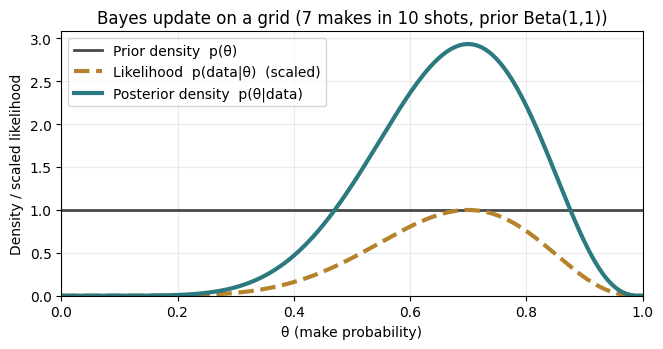

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.plot(theta_grid, prior_pdf, label="Prior density  p(θ)",
        color=CNET5442_COLORS[-1], lw=2)
ax.plot(theta_grid, likelihood_scaled, linestyle="--",
        label="Likelihood  p(data|θ)  (scaled)", color=CNET5442_COLORS[1], lw=3)
ax.plot(theta_grid, posterior_pdf_grid, label="Posterior density  p(θ|data)", 
        color=CNET5442_COLORS[2], lw=3)

ax.set_title('Bayes update on a grid (7 makes in 10 shots, prior Beta(1,1))')
ax.set_xlabel('θ (make probability)')
ax.set_ylabel('Density / scaled likelihood')
ax.set_xlim(0,1)
ax.set_ylim(0)
ax.grid(True, alpha=0.25)

ax.legend()
plt.show()

### Conjugate updating: Beta prior + Binomial likelihood ⇒ Beta posterior

For Bernoulli/Binomial data, a Beta prior is especially convenient:

$$
\theta \sim \text{Beta}(a,b).
$$

- $a>0$ and $b>0$ are shape parameters.
- A helpful interpretation is **pseudo-counts**:
  $a-1$ prior successes and $b-1$ prior failures.

Now suppose we observe $n$ shots with $s$ makes.

The Binomial likelihood (viewed as a function of $\theta$) is:

$$
p(s\mid \theta, n) = \binom{n}{s} \theta^s (1-\theta)^{n-s}.
$$

Where
- $n$ = number of trials (shots)
- $s$ = number of successes (makes)
- $\theta$ = success probability
- $\binom{n}{s}$ = the number of ways to place $s$ successes among $n$ trials

Some things:

- $\theta^s$ multiplies the probability of each of the $s$ successes.
- $(1-\theta)^{n-s}$ multiplies the probability of each of the $n-s$ failures.
- $\binom{n}{s}$ counts how many sequences have the same number of successes (order ignored).

**Conjugacy** means: multiplying the Beta prior by the Binomial likelihood produces another Beta distribution.

The posterior is:

$$
\theta \mid s,n \sim \text{Beta}(a+s,\; b+n-s).
$$

We will use this exact update later when we compare make rates "after a hit" vs "after a miss."

In [117]:
def beta_posterior_params(a, b, s, n):
    """Posterior Beta parameters for a Bernoulli/Binomial rate.

    Prior:
        theta ~ Beta(a, b)

    Data:
        s successes out of n independent Bernoulli trials

    Posterior:
        theta | data ~ Beta(a + s, b + (n - s))

    Parameters
    ----------
    a, b : float
        Prior Beta shape parameters (must be > 0).
    s : int
        Number of successes.
    n : int
        Number of trials (must satisfy 0 <= s <= n).

    Returns
    -------
    a_post, b_post : float
        Posterior Beta shape parameters.
    """
    assert a > 0 and b > 0, "Beta parameters a,b must be positive"
    assert 0 <= s <= n, "Must have 0 <= s <= n"

    a_post = a + s
    b_post = b + (n - s)

    return a_post, b_post

In [118]:
a_post, b_post = beta_posterior_params(a_prior, b_prior, s_obs, n_obs)

# Closed-form posterior mean for a Beta(a_post, b_post)
posterior_mean_closed = a_post / (a_post + b_post)

In [119]:
print(f"Posterior is Beta(a_post={a_post}, b_post={b_post})")
print(f"Closed-form posterior mean E[theta|data] = {posterior_mean_closed:.3f}")
print()
# Grid posterior mean should be close to closed-form mean
print(f"Absolute difference (grid vs closed-form mean) = {abs(posterior_mean_grid - posterior_mean_closed):.6f}")

Posterior is Beta(a_post=8, b_post=4)
Closed-form posterior mean E[theta|data] = 0.667

Absolute difference (grid vs closed-form mean) = 0.000000


Max |grid - closed-form| on the grid = 0.000000


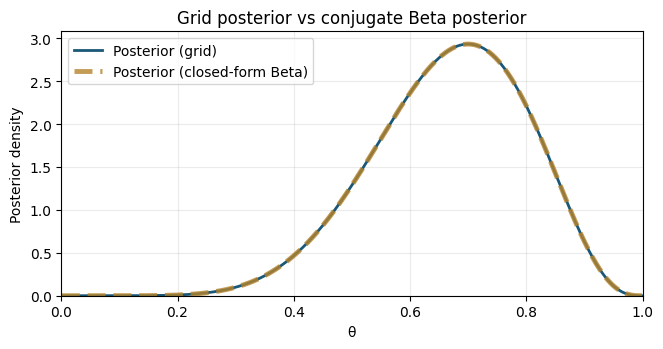

In [120]:
# Overlay the grid posterior and the closed-form Beta posterior (they should match)

posterior_pdf_closed = stats.beta.pdf(theta_grid, a_post, b_post)

# Normalize the closed-form density on the same grid (small numerical mismatch can occur at the edges)
delta = theta_grid[1] - theta_grid[0]
posterior_pdf_closed = posterior_pdf_closed / (np.sum(posterior_pdf_closed) * delta)

max_abs_diff = np.max(np.abs(posterior_pdf_grid - posterior_pdf_closed))
print(f"Max |grid - closed-form| on the grid = {max_abs_diff:.6f}")

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.plot(theta_grid, posterior_pdf_grid, label="Posterior (grid)",
        color=CNET5442_COLORS[0], lw=2)
ax.plot(theta_grid, posterior_pdf_closed, linestyle="--", label="Posterior (closed-form Beta)",
        color=CNET5442_COLORS[1], lw=3.5, alpha=0.8)

ax.set_title('Grid posterior vs conjugate Beta posterior')
ax.set_xlabel('θ')
ax.set_ylabel('Posterior density')
ax.grid(True, alpha=0.25)
ax.set_xlim(0,1)
ax.set_ylim(0)

ax.legend()
plt.show()

### Posterior summaries you'll may use

A posterior is a full distribution, but you often want a few interpretable numbers:

1. **Posterior mean**: a point estimate that averages over uncertainty.
2. **Posterior credible interval**: a range that contains, say, 95% of posterior mass.
3. **Posterior probability of a hypothesis**: e.g., $P(\theta > 0.5 \mid \text{data})$.


For a Beta posterior $\text{Beta}(a',b')$:

- Posterior mean is
  $$
  E[\theta \mid \text{data}] = \frac{a'}{a'+b'}.
  $$

- A 95% equal-tailed credible interval is given by Beta quantiles:
  $$
  \left[Q_{0.025},\; Q_{0.975}\right],
  $$
  where $Q_q$ is the $q$-quantile of the Beta distribution.

Some details:

- $a'$ acts like "success count + 1," $b'$ acts like "failure count + 1."
- The mean is "success pseudo-count divided by total pseudo-count."

Let's compute these quantities for our running example ($s=7$ makes out of $n=10$) under the uniform prior Beta(1,1).

In [121]:
# Posterior summaries: mean, credible interval, and P(theta > threshold)

alpha = 0.05  # 95% credible interval

post_mean = a_post / (a_post + b_post)
ci_low, ci_high = stats.beta.ppf([alpha/2, 1 - alpha/2], a_post, b_post)

# A posterior probability statement: P(theta > 0.5 | data)
p_theta_gt_half = 1 - stats.beta.cdf(0.5, a_post, b_post)

In [122]:
print(f"Posterior mean = {post_mean:.3f}")
print(f"95% credible interval = [{ci_low:.3f}, {ci_high:.3f}]")
print(f"P(theta > 0.5 | data) = {p_theta_gt_half:.3f}")

Posterior mean = 0.667
95% credible interval = [0.390, 0.891]
P(theta > 0.5 | data) = 0.887


### Posterior predictive: "what do we expect on the next shot?"

In the hot-hand context, the question is rarely "what is $\theta$ exactly?" It's usually: "what should we predict next?"

The **posterior predictive probability** of a make on the next shot is:

$$
P(\tilde Y = 1 \mid y) = \int_0^1 P(\tilde Y=1 \mid \theta)\,p(\theta\mid y)\,d\theta.
$$

Where 
- $\tilde Y$ is a future outcome (next shot), with $\tilde Y\in\{0,1\}$.
- $P(\tilde Y=1\mid \theta)=\theta$ for a Bernoulli model.
- $p(\theta\mid y)$ is the posterior from Bayes' rule.

For a Bernoulli model, this integral simplifies nicely:

$$
P(\tilde Y=1\mid y) = E[\theta \mid y].
$$

So for Beta-Bernoulli, "predicting the next shot" is literally just the posterior mean. We can also predict *multiple* future shots. If we plan to watch the next $m$ shots, the number of makes $K$ has a **Beta-Binomial** posterior predictive distribution.

In [123]:
# Posterior predictive probability for the next shot:
# For Bernoulli outcomes, this equals the posterior mean.

p_next_make = post_mean
print(f"Posterior predictive P(next shot is a make | data) = {p_next_make:.3f}")

# Optional: predictive distribution for K makes in the next m shots (Beta-Binomial)
m_future = 10
k_vals = np.arange(m_future + 1)
pmf_k = stats.betabinom.pmf(k_vals, m_future, a_post, b_post)

Posterior predictive P(next shot is a make | data) = 0.667


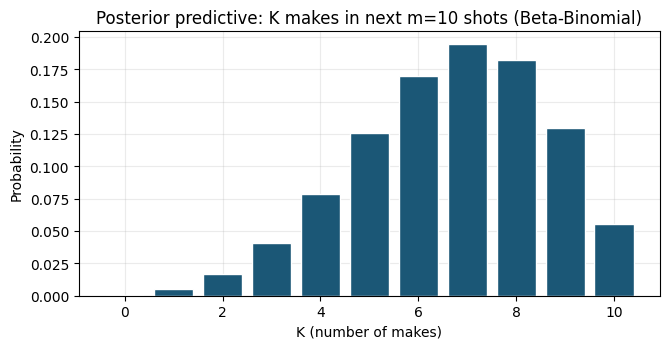

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.bar(k_vals, pmf_k, edgecolor="white", color=CNET5442_COLORS[0])
ax.set_title(f'Posterior predictive: K makes in next m={m_future} shots (Beta-Binomial)')
ax.set_xlabel('K (number of makes)')
ax.set_ylabel('Probability')
ax.grid(True, alpha=0.25)

plt.show()

________

### Frequentist vs Bayesian: a quick practical contrast

There are many philosophical differences, but for this notebook we'll focus on *practical workflow*.


**Frequentist view (typical):**
- $\theta$ is a fixed but unknown constant.
- Probability statements refer to the behavior of an estimator over repeated samples.
- A 95% confidence interval is a procedure that contains the true $\theta$ in 95% of repeated experiments (under model assumptions).

**Bayesian view (typical):**
- $\theta$ is unknown, and we represent uncertainty about it with a distribution.
- A 95% credible interval literally means:
  "given the model + prior + observed data, there is 95% posterior probability that $\theta$ lies in this interval."


**Why Bayesian tools are often helpful for hot-hand questions:**
- Conditioning on streaks can create *small sample sizes* fast (e.g., "shots after 3 straight makes" might be only a handful of shots).
- With small samples, raw proportions $s/n$ can look extreme and misleading.
- A Beta prior acts like a gentle regularizer ("shrinkage") and makes uncertainty explicit.


Below is a quick simulation: we repeatedly observe only $n=10$ shots from a player with true $\theta=0.35$, and compare:

- the raw proportion $\hat\theta = s/n$ (frequentist MLE for Bernoulli),
- the Bayesian posterior mean with a mild prior Beta(1,1),
- the Bayesian posterior mean with a stronger "skeptical" prior Beta(20,20) (centered at 0.5 with more pseudo-counts).

This isn't a proof that Bayes is always better, just a small illustration of how priors affect small-sample behavior

In [125]:
rng_primer = np.random.default_rng(5442)  # local RNG so we don't disturb the notebook's global seed

theta_true = 0.35
n_small = 10
R = 5000

# Priors to compare
priors = [
    ("Beta(1,1)  (uniform)", 1, 1),
    ("Beta(20,20)  (skeptical)", 20, 20),
]

# Simulate repeated experiments
sims_s = rng_primer.binomial(n_small, theta_true, size=R)
mle = sims_s / n_small

post_means = {}
for name, a0, b0 in priors:
    a_post_sim = a0 + sims_s
    b_post_sim = b0 + (n_small - sims_s)
    post_means[name] = a_post_sim / (a_post_sim + b_post_sim)

In [126]:
print("Means across repeated experiments:")
print(f"  True θ = {theta_true:.3f}")
print(f"  Mean MLE = {mle.mean():.3f}")
for name in post_means:
    print(f"  Mean posterior mean ({name}) = {post_means[name].mean():.3f}")

Means across repeated experiments:
  True θ = 0.350
  Mean MLE = 0.348
  Mean posterior mean (Beta(1,1)  (uniform)) = 0.373
  Mean posterior mean (Beta(20,20)  (skeptical)) = 0.470


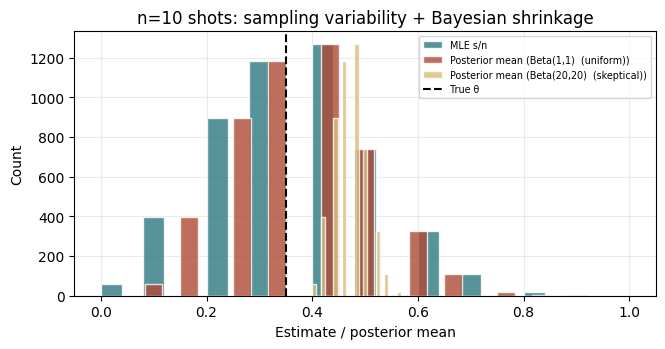

In [127]:
# Plot distributions
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(mle, bins=25, alpha=0.8, edgecolor="white", label="MLE s/n",
        color=CNET5442_COLORS[2])

for ix,name in enumerate(post_means):
    ax.hist(post_means[name], bins=25, alpha=0.8, edgecolor="white",
            label=f"Posterior mean ({name})", color=CNET5442_COLORS[ix+3])

ax.axvline(theta_true, linestyle="--", label="True θ", color='k')

ax.set_title(f'n={n_small} shots: sampling variability + Bayesian shrinkage')
ax.set_xlabel('Estimate / posterior mean')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

ax.legend(fontsize='x-small')

plt.show()

### Confidence interval vs credible interval: one concrete example

Let's use a tiny dataset where the difference in interpretation matters.

Suppose we watch $n=5$ shots and see $s=0$ makes.
The MLE is $\hat\theta=0$, but we probably don't believe the player's true make probability is exactly zero.

We'll compute:

- A **frequentist** 95% *Clopper-Pearson* confidence interval for $\theta$ (exact for Binomial).
- A **Bayesian** 95% credible interval for $\theta$ under a Beta(1,1) prior.

Both intervals are easy to compute using Beta distribution quantiles, but they answer different questions.


In [128]:
# Confidence interval (Clopper-Pearson) vs Bayesian credible interval for the same data

def clopper_pearson_interval(s, n, alpha=0.05):
    """Exact (Clopper-Pearson) confidence interval for a Binomial proportion.

    This returns an interval [L, U] such that, under repeated sampling with true theta,
    the procedure covers the true theta with probability at least 1 - alpha.

    Implementation detail:
    The endpoints can be expressed using Beta distribution quantiles.

    Parameters
    ----------
    s, n : int
        Successes and trials (0 <= s <= n).
    alpha : float
        Significance level. alpha=0.05 corresponds to a 95% CI.

    Returns
    -------
    (L, U) : tuple of floats
        Lower and upper bounds in [0, 1].
    """
    assert 0 <= s <= n

    if s == 0:
        L = 0.0
    else:
        L = stats.beta.ppf(alpha / 2, s, n - s + 1)

    if s == n:
        U = 1.0
    else:
        U = stats.beta.ppf(1 - alpha / 2, s + 1, n - s)

    return L, U


def beta_credible_interval(a, b, alpha=0.05):
    """Equal-tailed credible interval for theta ~ Beta(a,b)."""
    return stats.beta.ppf([alpha/2, 1 - alpha/2], a, b)

In [129]:
n_tiny, s_tiny = 5, 0

# Frequentist CI for theta
ci_freq = clopper_pearson_interval(s_tiny, n_tiny, alpha=0.05)

# Bayesian posterior with Beta(1,1) prior
a0, b0 = 1, 1
a_post_tiny, b_post_tiny = beta_posterior_params(a0, b0, s_tiny, n_tiny)
ci_bayes = beta_credible_interval(a_post_tiny, b_post_tiny, alpha=0.05)

print(f"Data: s={s_tiny} makes out of n={n_tiny} shots")
print()
print(f"Frequentist 95% CI (Clopper-Pearson): [{ci_freq[0]:.3f}, {ci_freq[1]:.3f}]")
print(f"Bayesian 95% credible interval (Beta(1,1) prior): [{ci_bayes[0]:.3f}, {ci_bayes[1]:.3f}]")
print(f"Posterior mean under Beta(1,1): {a_post_tiny / (a_post_tiny + b_post_tiny):.3f}")

Data: s=0 makes out of n=5 shots

Frequentist 95% CI (Clopper-Pearson): [0.000, 0.522]
Bayesian 95% credible interval (Beta(1,1) prior): [0.004, 0.459]
Posterior mean under Beta(1,1): 0.143


#### Exercise 1: Turn a belief into a Beta prior

A Beta prior can be interpreted as pseudo-counts.
Suppose before watching today's game, you believe a player is roughly a 40% shooter,
and you want that belief to have about the same weight as **20 previous shots**.

- What Beta($a,b$) prior would represent that belief?
- After you observe $s=6$ makes in $n=10$ shots, what is the posterior mean and a 95% credible interval?

#### Exercise 2: Posterior probability statements

Using the posterior from Exercise 1, compute:

- $P(\theta > 0.5 \mid \text{data})$ (probability the player is "above 50%")

Run the cell below to check your work.


In [130]:
# Try the exercises here (then run the next cell for one possible solution)

# Exercise 1: "20 pseudo-shots at 40%"
prior_weight = 20
prior_mean = 0.40

# Fill these in (your answers should make the prior mean ~0.40 and total pseudo-count ~20)
a_ex = None
b_ex = None

# Data update
s_new = 6
n_new = 10

# Once you've set a_ex and b_ex, compute posterior mean + 95% credible interval
# (Hint: use beta_posterior_params and stats.beta.ppf)


In [131]:
# One possible solution (exercise answers)

prior_weight = 20
prior_mean = 0.40

# A simple way to match mean + "weight" is:
#   a + b = prior_weight
#   a / (a + b) = prior_mean
# Solve: a = prior_mean * prior_weight, b = (1 - prior_mean) * prior_weight
#
# Note: This matches the mean, but the "pseudo-count" interpretation is approximate.
# In many texts, Beta(a,b) corresponds to (a-1) pseudo successes and (b-1) pseudo failures.
# Here we're using a convenient parameterization that gives the right mean and overall concentration.

a_ex = prior_mean * prior_weight
b_ex = (1 - prior_mean) * prior_weight

s_new = 6
n_new = 10

a_post_ex, b_post_ex = beta_posterior_params(a_ex, b_ex, s_new, n_new)

post_mean_ex = a_post_ex / (a_post_ex + b_post_ex)
ci_ex = stats.beta.ppf([0.025, 0.975], a_post_ex, b_post_ex)
p_gt_05 = 1 - stats.beta.cdf(0.5, a_post_ex, b_post_ex)

print(f"Chosen prior: Beta(a={a_ex:.1f}, b={b_ex:.1f})")
print(f"  Prior mean = {a_ex / (a_ex + b_ex):.3f}")

print()
print(f"After seeing s={s_new} of n={n_new}: posterior Beta(a'={a_post_ex:.1f}, b'={b_post_ex:.1f})")
print(f"  Posterior mean = {post_mean_ex:.3f}")
print(f"  95% credible interval = [{ci_ex[0]:.3f}, {ci_ex[1]:.3f}]")
print(f"  P(theta > 0.5 | data) = {p_gt_05:.3f}")


Chosen prior: Beta(a=8.0, b=12.0)
  Prior mean = 0.400

After seeing s=6 of n=10: posterior Beta(a'=14.0, b'=16.0)
  Posterior mean = 0.467
  95% credible interval = [0.294, 0.643]
  P(theta > 0.5 | data) = 0.356


### How this primer connects to the hot-hand problem

Later in this notebook we will create **two** different Bayesian objects:

1. **Conditional rates** like:
   - $\theta_{\text{after hit}}$ = make probability on the *next* shot given the previous shot was a make
   - $\theta_{\text{after miss}}$ = make probability on the next shot given the previous shot was a miss  
   We'll put Beta priors on these and update with counts.

2. A **latent-state model** (a two-state HMM):
   - the shooter is in an unobserved state $Z_t \in \{\text{cold},\text{hot}\}$
   - the state evolves over time, and changes the make probability  
   We'll use Bayes' rule "under the hood" to infer the state sequence.

If Bayesian language is new, this section is the reference point to come back to.


_______
## A Gelman-style Bayesian workflow for the hot-hand debate

Andrew Gelman has written about the hot-hand debate for years, and his perspective is helpful *even if you never read a single hot-hand paper*:

When a topic becomes a "controversy," it's often because we are trying to learn a **small, heterogeneous effect** from **noisy measurements**, using a statistic that doesn't line up perfectly with the question people actually care about.

So instead of asking "Does the hot hand exist?", we'll try to ask questions like:

- *How large* could any short-term predictability be (in percentage points)?
- *How variable* is it across players, games, or contexts?
- *What do we actually observe* (0/1 makes and misses) versus what we'd like to know (a moment-to-moment probability of making the shot)?
- *What kinds of models are consistent with the data*, and what model assumptions are doing the work?

This section is a conceptual bridge: it motivates why we'll eventually use **latent-state models** and **partial pooling** instead of relying on a single "after 3 makes" difference-in-proportions.


### Why smart people can look at the same evidence and disagree

Three reasons show up repeatedly in the hot-hand discussion:

1. **Different definitions.** Some people mean outcome dependence ("makes follow makes"), others mean a latent state ("in the zone"), and others mean strategy ("defense adjusts, shot selection changes"). These are different questions.

2. **Small signals in binary data.** Even if your underlying success probability moves, the realized sequence of 0/1 outcomes is *extremely noisy*. The data can support multiple stories unless the sample is large and the model is well-aligned with the estimand.

3. **Heterogeneity.** It's completely plausible that some players (or some contexts) have meaningful short-term predictability and others don't. If we average everyone together, we can easily dilute or even reverse patterns.

Gelman's recurring advice is: focus on **effect sizes** and **variation**, and treat hypothesis tests as a secondary summary rather than the goal.


### Gelman's recurring claims in the hot-hand posts

Across multiple posts (2012, 2014, 2017, 2020, 2024), the same ideas come back:

- **Effects are not exactly zero.** Real performance varies with fatigue, confidence, focus, health, and context. So the "point null" of perfect stationarity is rarely a scientifically satisfying endpoint.
- **Average effects can be small in percentage points.** Small effects are hard to see in binary sequences without lots of data and careful modeling.
- **Variation is the rule, not the exception.** The hot-hand effect can differ across players *and within the same player* across time and situations.
- **People can still overread streaks.** Even if a real effect exists, human intuition can exaggerate it and see it when it's not there.

This is why a Bayesian workflow (effect sizes + uncertainty + partial pooling + model checking) is a natural match for this topic.


### Key idea 1: "Previous make" is a noisy proxy for "being hot"

A common student reaction is:

> "Why not just regress `make_t` on `make_{t-1}` and be done?"

The problem is that `make_{t-1}` is not the thing we care about. If "hotness" is a latent state (unobserved), then a make is only a **noisy measurement** of that state.

That creates **attenuation** (error-in-variables): the regression you can run on the data is not the regression you *wish* you could run.

Let's see this with a concrete simulation.


In [132]:
def simulate_hot_cold_sequence(T, p_make_hot=0.60, p_make_cold=0.40, p_stay=0.90, rng=None):
    """
    Simulate a binary shooting sequence with a latent hot/cold state.

    Parameters
    ----------
    T : int
        Length of the sequence.
    p_make_hot : float
        Pr(make | state=hot).
    p_make_cold : float
        Pr(make | state=cold).
    p_stay : float
        Pr(state_t = state_{t-1}). Higher means longer hot/cold spells.
        (We use the same persistence for hot and cold to keep the demo simple.)
    rng : numpy.random.Generator or None
        Random generator for reproducibility.

    Returns
    -------
    states : ndarray, shape (T,)
        Latent states S_t in {0,1}.
    y : ndarray, shape (T,)
        Observed outcomes Y_t in {0,1}.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Latent state process
    states = np.zeros(T, dtype=int)
    states[0] = rng.integers(0, 2)  # start hot or cold with equal probability

    for t in range(1, T):
        # With probability p_stay we keep the same state; otherwise we flip.
        if rng.random() > p_stay:
            states[t] = 1 - states[t-1]
        else:
            states[t] = states[t-1]

    # Emissions: shot outcomes
    p = np.where(states == 1, p_make_hot, p_make_cold)
    y = rng.binomial(1, p)

    return states, y


def conditional_make_rate(y, lag_value):
    """
    Estimate Pr(Y_t=1 | Y_{t-1}=lag_value) from a binary sequence.

    This is the "outcome dependence" statistic many people compute first.
    """
    y_prev = y[:-1]
    y_next = y[1:]
    mask = (y_prev == lag_value)
    return y_next[mask].mean()

In [133]:
# --- Run the experiment for different state persistence values
T = 200_000
p_hot = 0.60
p_cold = 0.40

rows = []
for p_stay in [0.50, 0.70, 0.90, 0.97]:
    states, y = simulate_hot_cold_sequence(
        T=T, p_make_hot=p_hot, p_make_cold=p_cold, p_stay=p_stay
    )

    # What we *wish* we could condition on (the latent state)
    make_hot = y[states == 1].mean()
    make_cold = y[states == 0].mean()

    # What we often condition on in practice (the previous outcome)
    p_after_make = conditional_make_rate(y, lag_value=1)
    p_after_miss = conditional_make_rate(y, lag_value=0)

    rows.append({
        "p_stay": p_stay,
        "true_state_delta": make_hot - make_cold,
        "naive_outcome_delta": p_after_make - p_after_miss,
        "Pr(Y_t = Y_{t-1})": (y[1:] == y[:-1]).mean()
    })

demo = pd.DataFrame(rows)
demo

,p_stay,true_state_delta,naive_outcome_delta,Pr(Y_t = Y_{t-1})
0,0.50,0.198107,0.000122,0.500063
1,0.70,0.203495,0.017371,0.508688
2,0.90,0.199907,0.032669,0.516348
3,0.97,0.203060,0.040334,0.520168


### Interpreting the simulation

In this toy world the *latent* hot/cold difference is big: $0.60 - 0.40 = 0.20$ (a 20 percentage-point swing).

But the table shows that the naive "after a make vs after a miss" effect can be only a few percentage points—or even basically zero—depending on how persistent the latent state is.

Two takeaways:

- **Low serial correlation in outcomes does not imply "no hot hand."** It might just mean that outcomes are noisy measurements of a time-varying probability.
- **This is why latent-state models are attractive.** If the thing you care about is latent, try to model it as latent rather than using a single noisy proxy.

We will come back to this idea when we build a Bayesian hidden Markov model in Part 10.
_______

### Key idea 2: Expect heterogeneity and use partial pooling

Hot-hand effects (and even baseline shooting skill) almost certainly vary across players.

A non-Bayesian way to say this is: *there are many parameters*.

A Bayesian way to say the same thing is: *use a prior that links related parameters together*, so that players with little data borrow strength from the population.

This is the central idea of **multilevel modeling** (a.k.a. hierarchical modeling / partial pooling), and it is one of the main reasons Bayesian methods tend to be practical in sports settings.

Before we apply this to real shots, here's a small simulation that shows what partial pooling buys you.


In [134]:
# Partial pooling demo: player shooting percentages
#
# Setup:
#   - Each player i has a true make probability θ_i.
#   - We only see a finite number of shots, so the raw estimate (makes/shots) is noisy.
#   - A Beta prior shrinks extreme estimates back toward the league mean, especially for small n.

rng = np.random.default_rng(2026)

n_players = 40
# True population: mean around 0.45 with modest variability
alpha_true, beta_true = 18, 22

theta_true = rng.beta(alpha_true, beta_true, size=n_players)

# Each player takes a different number of shots
n_shots = rng.integers(15, 120, size=n_players)
makes = rng.binomial(n_shots, theta_true)

mle = makes / n_shots

# A simple (not fully hierarchical) partial pooling move:
# Choose a weakly-informative prior centered near typical NBA FG% (~0.45).
alpha0, beta0 = 9, 11  # prior mean = 9/(9+11)=0.45; prior "sample size" ≈ 20 shots

posterior_mean = (alpha0 + makes) / (alpha0 + beta0 + n_shots)

# # Sanity checks
# assert mle.shape == posterior_mean.shape == theta_true.shape
# assert np.all((mle >= 0) & (mle <= 1))


In [135]:
# Show a few players to make it concrete
demo_pool = pd.DataFrame({
    "player": np.arange(n_players),
    "shots": n_shots,
    "makes": makes,
    "mle_rate": mle,
    "posterior_mean": posterior_mean,
    "true_theta": theta_true
}).sort_values("shots").head(10)

demo_pool

,player,shots,makes,mle_rate,posterior_mean,true_theta
6,6,18,9,0.500000,0.473684,0.525507
24,24,18,11,0.611111,0.526316,0.396206
11,11,18,8,0.444444,0.447368,0.369990
7,7,19,8,0.421053,0.435897,0.437921
27,27,22,10,0.454545,0.452381,0.417658
13,13,27,8,0.296296,0.361702,0.362558
0,0,31,13,0.419355,0.431373,0.509714
31,31,32,16,0.500000,0.480769,0.500923
38,38,33,13,0.393939,0.415094,0.470899
18,18,33,15,0.454545,0.452830,0.497500


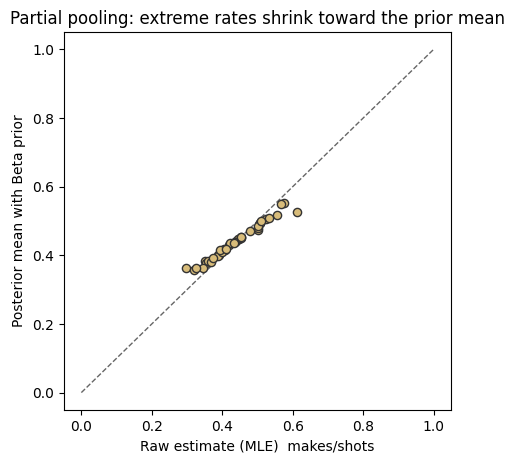

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

ax.scatter(mle, posterior_mean, s=35, ec='.2', color=CNET5442_COLORS[4])
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color='.4', zorder=0)
ax.set_xlabel("Raw estimate (MLE)  makes/shots")
ax.set_ylabel("Posterior mean with Beta prior")
ax.set_title("Partial pooling: extreme rates shrink toward the prior mean")

plt.show()

### What to notice in the partial-pooling demo

- Points on the diagonal would mean "Bayes does nothing" (posterior mean equals raw makes/shots).
- Instead, extreme raw rates (very high or very low) move **toward the prior mean**.
- Players with fewer shots shrink more, because their observed rate is noisier.

This is the same intuition we'll use later when we estimate **conditional shooting rates** like "after a hit" versus "after a miss."  
Those conditional groups can be small even when the total number of shots is large.

In short: partial pooling is a principled way to be skeptical of extreme streak-based estimates without declaring that *no* player ever gets hot.


_______
## Part 1 — What does "hot hand" mean statistically? (Extended!)

There is no single universal definition, but two families show up repeatedly in the literature:

### Definition A: Outcome dependence (makes follow makes)

A direct, intuitive statement is:

$$
P(Y_t=1 \mid Y_{t-1}=1) > P(Y_t=1 \mid Y_{t-1}=0).
$$

- $Y_t$ is the outcome at time $t$ (1=make, 0=miss).
- The left side is "make probability after a make."
- The right side is "make probability after a miss."

This is close to what fans often mean.

### Definition B: State dependence (a latent, time-varying skill)

Another view is that players have a latent "form" or "state" that changes:

- On some possessions they're effectively better (hot),
- on others worse (cold),
- and these states persist for a while.

In that case the *outcomes* may look only weakly dependent, even if the *underlying probability* is strongly dependent.

This distinction matters because shots are noisy.
Even if your make probability rises, you can still miss the next one.

In [137]:
def conditional_make_rate(y, k=1, on_success=True):
    """Estimate conditional make rate after a streak.

    We look for times t where the previous k outcomes are all 1 (if on_success=True)
    or all 0 (if on_success=False), and compute the proportion of Y_t = 1 on those times.

    Parameters
    ----------
    y : 1d array-like of 0/1
        Outcome sequence in time order.
    k : int
        Streak length to condition on.
    on_success : bool
        If True, condition on k prior successes; if False, on k prior failures.

    Returns
    -------
    rate : float
        Sample proportion of makes among the eligible times.
    n : int
        Number of eligible times (sample size of the conditional set).
    """
    y = np.asarray(y).astype(int)
    if len(y) <= k:
        return np.nan, 0

    target = 1 if on_success else 0
    eligible = []
    for t in range(k, len(y)):
        if np.all(y[t-k:t] == target):
            eligible.append(t)

    eligible = np.array(eligible, dtype=int)
    n = len(eligible)
    if n == 0:
        return np.nan, 0

    return y[eligible].mean(), n

In [138]:
# Micro example
toy = np.array([1,0,1,1,0,1,1,1,0])
rate_after_hit, n_after_hit = conditional_make_rate(toy, k=1, on_success=True)
rate_after_miss, n_after_miss = conditional_make_rate(toy, k=1, on_success=False)
(rate_after_hit, n_after_hit), (rate_after_miss, n_after_miss)

((0.5, 6), (1.0, 2))

In that toy sequence, you can compute:

- "After a make" rate: the proportion of makes on shots immediately following makes.
- "After a miss" rate: the same, but for shots following misses.

But there's a subtle trap: **even when the sequence is purely random, these conditional estimates can be biased** in finite samples.
That's the heart of the modern hot-hand controversy.

### A quick warning about aggregation (Simpson's paradox territory)

A tempting shortcut is to pool shot outcomes across many players and ask whether
"after a hit" shots are made more often than "after a miss" shots.

But pooling can be misleading because different players have different base rates.
Even if **every individual player** is i.i.d. Bernoulli (no hot hand),
the pooled data can create apparent effects purely from heterogeneity and weighting.

Gilovich, Vallone & Tversky (1985) explicitly warn about this issue for free throws:
good shooters contribute disproportionately to "after a hit" situations, which can bias pooled conditional rates.

Let's see the mechanism with a toy simulation.

In [139]:
def pooled_after_hit_minus_after_miss(seqs, k=1):
    """Compute pooled S(Y) across multiple sequences (e.g., multiple players or games).

    The pooled statistic is:
      S = (sum successes after k hits)/(sum opportunities after k hits)
        - (sum successes after k misses)/(sum opportunities after k misses)
    """
    s_hit = n_hit = s_miss = n_miss = 0

    for y in seqs:
        y = np.asarray(y).astype(int)
        if len(y) <= k:
            continue

        # convolution-based conditioning
        wsum = np.convolve(y, np.ones(k, dtype=int), mode='valid')  # length T-k+1
        wsum = wsum[:-1]  # windows that have a follow-up
        follow = y[k:]    # length T-k

        hit_mask = (wsum == k)
        miss_mask = (wsum == 0)

        n_hit += hit_mask.sum()
        s_hit += follow[hit_mask].sum()

        n_miss += miss_mask.sum()
        s_miss += follow[miss_mask].sum()

    if n_hit == 0 or n_miss == 0:
        return np.nan, dict(s_hit=s_hit, n_hit=n_hit, s_miss=s_miss, n_miss=n_miss)

    p_hit = s_hit / n_hit
    p_miss = s_miss / n_miss
    return p_hit - p_miss, dict(s_hit=s_hit, n_hit=n_hit, s_miss=s_miss, n_miss=n_miss)

In [140]:
# Two players with different (constant) skill, no hot hand
T = 200
y_good = simulate_iid_bernoulli(T=T, p=0.75)
y_bad  = simulate_iid_bernoulli(T=T, p=0.35)

# Within each player, the expected S should be ~0 under i.i.d.
s_good, _ = pooled_after_hit_minus_after_miss([y_good], k=1)
s_bad, _  = pooled_after_hit_minus_after_miss([y_bad],  k=1)

# Pooling them together changes the weighting
s_pool, details_pool = pooled_after_hit_minus_after_miss([y_good, y_bad], k=1)

s_good, s_bad, s_pool, details_pool

(0.07723900370959191,
 -0.021942110177404328,
 0.20313252401348303,
 {'s_hit': 132, 'n_hit': 211, 's_miss': 79, 'n_miss': 187})

In [141]:
# Repeat the toy experiment many times to see the distribution of the pooled effect
R = 400
vals = []
for _ in range(R):
    y_good = simulate_iid_bernoulli(T=200, p=0.75)
    y_bad  = simulate_iid_bernoulli(T=200, p=0.35)
    s_pool, _ = pooled_after_hit_minus_after_miss([y_good, y_bad], k=1)
    vals.append(s_pool)

vals = np.array(vals)

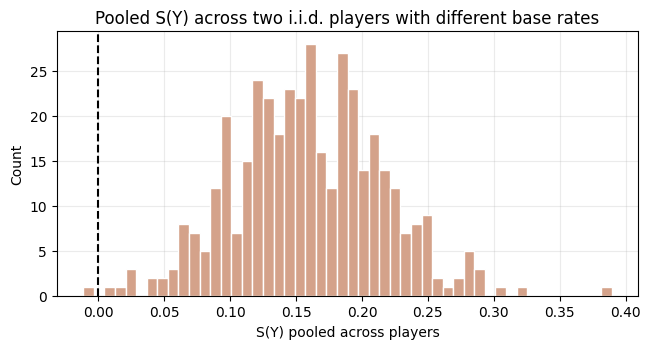

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(vals, bins=50, edgecolor='white', color=CNET5442_COLORS[7])
ax.axvline(0, linestyle='--', color='k')
ax.set_title('Pooled S(Y) across two i.i.d. players with different base rates')
ax.set_xlabel('S(Y) pooled across players')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

plt.show()

Even though each player is i.i.d. with a constant success probability,
the pooled statistic can drift away from zero because the conditioning set
("after a hit") weights the better shooter differently than the worse shooter.

**Lesson:** if you want player-level hot-hand conclusions,
compute statistics *within player* (and often within game), then pool carefully.

_______
## Part 2 — The "streak selection bias" (why naive hot-hand tests can be biased)

A common statistic in early hot-hand papers is the empirical conditional rate

$$
\hat p_{1\mid 1} =
\frac{\#\{t: Y_{t-1}=1,\ Y_t=1\}}
     {\#\{t: Y_{t-1}=1\}}.
$$

**Define the symbols:**

- $Y_t \in \{0,1\}$ is the outcome at time $t$.
- $\#\{\cdot\}$ counts how many times a condition happens in the sequence.
- The numerator counts "hit-hit" pairs.
- The denominator counts "times we had a prior hit and therefore recorded a follow-up outcome."

**Why this form makes sense:** it is just "successes / opportunities," but where the opportunities are restricted to times when the previous shot was a hit.

**What Miller & Sanjurjo (2018) prove:** in finite sequences, $\hat p_{1\mid 1}$ is generally **biased downward** under an i.i.d. Bernoulli null.
The bias shrinks with sequence length $T$, but can be substantial for small $T$ and for longer streak conditioning.  
(And analogues of this issue show up in other "conditioning on streaks" statistics.)

Let's see the core idea in the smallest nontrivial example: $T=3$ fair coin flips.

In [143]:
def expected_phat_after_hit_for_fixed_T(T=3, p=0.5):
    """Exact expectation of \hat p_{1|1} over all length-T Bernoulli sequences.

    Here \hat p_{1|1} is computed as:
      (# of hit-hit pairs) / (# of hits that have a following observation)

    For length T, the relevant pairs are (1,2), (2,3), ..., (T-1, T).
    The denominator counts hits among positions 1..T-1.

    If the denominator is 0 (no hits in positions 1..T-1), the statistic is undefined.
    We follow a common convention and exclude those sequences from the average.

    Returns
    -------
    float
        E[\hat p_{1|1} | denominator > 0] under i.i.d. Bernoulli(p).
    """
    # enumerate all 2^T sequences
    seqs = np.array(np.meshgrid(*[[0,1]]*T)).T.reshape(-1, T)
    probs = (p**seqs.sum(axis=1)) * ((1-p)**(T-seqs.sum(axis=1)))

    phats = []
    wts = []
    for s, w in zip(seqs, probs):
        denom = s[:-1].sum()  # hits with a follow-up
        if denom == 0:
            continue
        num = np.sum((s[:-1] == 1) & (s[1:] == 1))
        phats.append(num / denom)
        wts.append(w)

    phats = np.array(phats, dtype=float)
    wts = np.array(wts, dtype=float)
    return np.sum(phats * wts) / np.sum(wts)

In [144]:
expected_phat_after_hit_for_fixed_T(T=3, p=0.5)

0.4166666666666667

For $T=3$ and $p=0.5$, the expectation is $5/12 \approx 0.4167$ — **not** $0.5$.

That's startling at first, because in a fair coin model we know that
$P(Y_t=1 \mid Y_{t-1}=1)=0.5$ at the *data-generating* level.
The mismatch is coming from the statistic $\hat p_{1\mid 1}$ itself: it is a ratio of random variables whose denominator depends on the sequence.

Let's confirm the $5/12$ value directly and see how the bias shrinks as $T$ grows.

In [145]:
# Verify 5/12 exactly via enumeration for T=3
val = expected_phat_after_hit_for_fixed_T(T=3, p=0.5)
val, val - (5/12)

(0.4166666666666667, 0.0)

In [146]:
# Bias as a function of T
# Exact enumeration grows as 2^T, so we do exact for small T and simulation for larger T.
Ts_exact = np.arange(3, 13)
exact_vals = [expected_phat_after_hit_for_fixed_T(T=int(T), p=0.5) for T in Ts_exact]

Ts_sim = np.arange(13, 81, 4)
sim_vals = []
R_sim = 4000
for T in Ts_sim:
    phats = []
    for _ in range(R_sim):
        y = simulate_iid_bernoulli(T=int(T), p=0.5)
        # compute \hat p_{1|1} if defined
        denom = y[:-1].sum()
        if denom == 0:
            continue
        num = np.sum((y[:-1] == 1) & (y[1:] == 1))
        phats.append(num / denom)
    sim_vals.append(np.mean(phats))

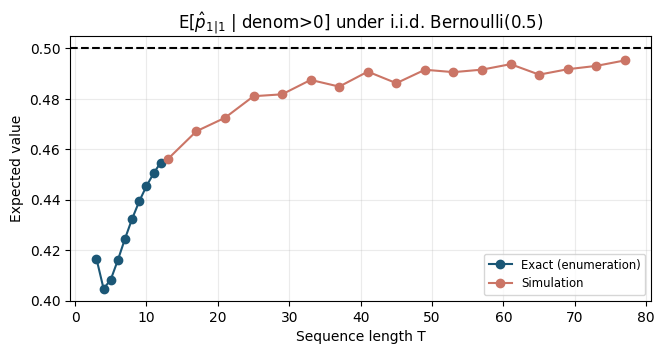

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.plot(Ts_exact, exact_vals, marker='o', label="Exact (enumeration)", color=CNET5442_COLORS[0])
ax.plot(Ts_sim, sim_vals, marker='o', label="Simulation", color=CNET5442_COLORS[9])
ax.axhline(0.5, linestyle='--', color='k')
ax.legend(fontsize='small')
ax.set_title('E[$\\hat p_{1|1}$ | denom>0] under i.i.d. Bernoulli(0.5)')
ax.set_xlabel('Sequence length T')
ax.set_ylabel('Expected value')
ax.grid(True, alpha=0.25)

plt.show()

**Interpretation:** when $T$ is short, selecting only "times after a hit" is not an innocent conditioning step.
It changes the combinatorics of what can follow.

This doesn't mean "conditioning is illegal."
It means we need to be careful about **how we calibrate** a hot-hand test.

A good fix is to compute "what would this statistic look like if the same sequence were randomly rearranged?"
That motivates permutation tests.

#### Optional: the "0.4 after a head" coin story is really about weighting

If you've read blog posts about the hot hand, you may have seen a claim like:

> "In a short fair-coin sequence, the observed fraction of heads following heads is about 0.4, not 0.5."

This is not magic. It comes from mixing up two different ways to average:

- **Unweighted (average-of-averages):** compute $\hat p_{1\mid 1}$ inside each sequence, then average those values across sequences.
- **Weighted (pooled):** pool all "head-followed-by-something" opportunities across sequences and compute one big ratio.

Both computations can be written down cleanly. They answer different questions.

Let's compute both for all $2^4=16$ sequences of four fair coin flips.


In [148]:
import itertools

def phat_after_head(seq):
    """
    Sequence-level estimate of Pr(head | previous head), i.e. p̂_{1|1}.

    We define it only when there is at least one 'opportunity' (a head in positions 1..T-1).
    """
    seq = np.array(seq, dtype=int)
    prev = seq[:-1]
    nxt = seq[1:]
    mask = (prev == 1)
    if mask.sum() == 0:
        return np.nan
    return nxt[mask].mean()

In [149]:
T = 4
seqs = list(itertools.product([0, 1], repeat=T))

# Unweighted: average p̂_{1|1} across sequences where it is defined
vals = np.array([phat_after_head(s) for s in seqs], dtype=float)
unweighted = np.nanmean(vals)

In [150]:
# Weighted (pooled): pool HH counts and H-opportunities across sequences
hh = 0
h_opps = 0
for s in seqs:
    s = np.array(s, dtype=int)
    prev = s[:-1]
    nxt = s[1:]
    mask = (prev == 1)
    h_opps += mask.sum()
    hh += (nxt[mask] == 1).sum()

pooled = hh / h_opps

unweighted, pooled

(0.4047619047619047, 0.5)

You should see:

- the **unweighted** average is below 0.5 (about 0.40),
- the **pooled** estimate is exactly 0.5.

Why mention this?

Because early hot-hand analyses often computed a per-player statistic and then averaged across players **without weighting by how many streak opportunities each player had**. That is analogous to the unweighted average above. It can introduce bias in finite samples.

But also notice the bigger moral: the same data can yield different numbers depending on which estimand your averaging scheme targets. That's why we keep returning to "define the quantity you want" before arguing about the answer.


_______
## Part 3 — A clean calibration tool: permutation (randomization) tests

Suppose you pick a hot-hand statistic $S(Y)$ computed from a sequence $Y=(Y_1,\dots,Y_T)$.
For example, for streak length $k=1$:

$$
S(Y) = \hat p_{1\mid 1} - \hat p_{1\mid 0}.
$$

**Define the symbols:**

- $\hat p_{1\mid 1}$ is the empirical make rate after a make (as above).
- $\hat p_{1\mid 0}$ is the empirical make rate after a miss (defined analogously).
- $S(Y)$ is the observed "advantage after makes" in the sample.

**Why this form makes sense:** if being "hot" means makes tend to follow makes, then $S(Y)$ should be positive.


### The permutation idea

Under a simple null hypothesis of **no time dependence** (exchangeability),
the order of the outcomes shouldn't matter.
So we:

1. Compute $S(Y)$ on the observed order.
2. Randomly permute the sequence many times to get $Y^{(1)},\dots,Y^{(B)}$.
3. Compute $S(Y^{(b)})$ each time.
4. Compare the observed $S(Y)$ to the permutation distribution.

This avoids the small-sample calibration problems we just saw,
because the permutation distribution automatically reflects
the finite length $T$ and the exact number of makes/misses in the sample.

In [151]:
def hot_hand_statistic(y, k=1):
    """Hot-hand statistic S(Y) = p_hat(after k hits) - p_hat(after k misses).

    Returns
    -------
    stat : float
        Difference in conditional make rates. NaN if one side has zero opportunities.
    details : dict
        Contains counts and component rates.
    """
    y = np.asarray(y).astype(int)

    p_hit, n_hit = conditional_make_rate(y, k=k, on_success=True)
    p_miss, n_miss = conditional_make_rate(y, k=k, on_success=False)

    if n_hit == 0 or n_miss == 0:
        return np.nan, dict(p_hit=p_hit, n_hit=n_hit, p_miss=p_miss, n_miss=n_miss)

    return (p_hit - p_miss), dict(p_hit=p_hit, n_hit=n_hit, p_miss=p_miss, n_miss=n_miss)

def permutation_test_hot_hand(y, k=1, B=800):
    """Permutation test for hot-hand statistic S(Y).

    Parameters
    ----------
    y : 1d array-like of 0/1
        Observed sequence in time order.
    k : int
        Streak length for the statistic.
    B : int
        Number of random permutations.

    Returns
    -------
    out : dict
        Contains observed statistic, permutation statistics, and a two-sided p-value.
    """
    y = np.asarray(y).astype(int)
    obs, details = hot_hand_statistic(y, k=k)

    if np.isnan(obs):
        return dict(obs=np.nan, p_value=np.nan, perm_stats=None, details=details)

    perm_stats = np.empty(B)
    for b in range(B):
        yp = np.random.permutation(y)
        s, _ = hot_hand_statistic(yp, k=k)
        perm_stats[b] = s

    # Two-sided p-value with +1 smoothing (classic randomization test practice)
    p_value = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (B + 1)

    return dict(obs=obs, p_value=p_value, perm_stats=perm_stats, details=details)

In [152]:
# Micro example on a tiny sequence
toy = np.array([1,1,1,0,0,1,1,0,1,1,1,1,0])
out = permutation_test_hot_hand(toy, k=1, B=800)
out['obs'], out['p_value'], out['details']

(0.0,
 1.0,
 {'p_hit': 0.6666666666666666,
  'n_hit': 9,
  'p_miss': 0.6666666666666666,
  'n_miss': 3})

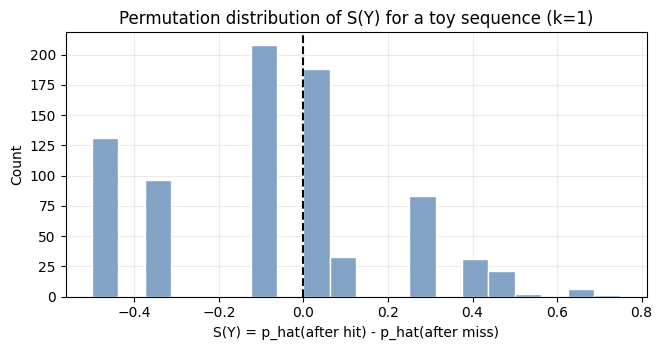

In [153]:
# Visualize the permutation distribution for the toy example
perm_stats = out['perm_stats']

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(perm_stats, bins=20, edgecolor='white', color=CNET5442_COLORS[10])
ax.axvline(out['obs'], linestyle='--', color='k')
ax.set_title('Permutation distribution of S(Y) for a toy sequence (k=1)')
ax.set_xlabel('S(Y) = p_hat(after hit) - p_hat(after miss)')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

plt.show()

### Important nuance

A permutation test answers a very specific question:

> *If the outcomes had no time structure at all, how unusual would our observed streakiness statistic be?*

It does **not** automatically tell you what mechanism generated the dependence.
In real basketball, dependence can come from many places:
fatigue, confidence, defensive adjustments, shot selection, etc.

But as a calibration tool, permutation tests are extremely useful.

_______
## Part 4 — Simulation lab: when there *is* a hot hand, can we detect it?

Before touching real NBA data, we want a controlled environment where we know the truth.

### A simple "latent hot/cold" generator (two-state HMM)

We'll simulate:

- A latent state $Z_t \in \{0,1\}$ where 0=cold and 1=hot.
- A transition matrix $A$ where $A_{ij}=P(Z_t=j\mid Z_{t-1}=i)$.
- Emissions: $Y_t \mid (Z_t=j) \sim \text{Bernoulli}(\theta_j)$.

**Symbols:**

- $\theta_0$ is the make probability in the cold state.
- $\theta_1$ is the make probability in the hot state.
- If $A_{11}$ is large, "hot" tends to persist; similarly for $A_{00}$.

This is one concrete way to formalize "form" or "momentum" as a latent variable.
(Otting et al. (2020) do something related with a continuous latent form process for darts.)

In [154]:
def simulate_two_state_hmm(T, theta_cold=0.4, theta_hot=0.6,
                           p_hot_to_hot=0.85, p_cold_to_cold=0.85, z0=0):
    """Simulate a two-state HMM with Bernoulli emissions.

    Parameters
    ----------
    T : int
        Sequence length.
    theta_cold, theta_hot : float
        Emission probabilities for y=1 in cold/hot states.
    p_hot_to_hot, p_cold_to_cold : float
        State persistence probabilities.
    z0 : int
        Initial state (0=cold, 1=hot).

    Returns
    -------
    y : ndarray, shape (T,)
        Observed outcomes (0/1).
    z : ndarray, shape (T,)
        Latent states (0/1).
    """
    A = np.array([
        [p_cold_to_cold, 1 - p_cold_to_cold],
        [1 - p_hot_to_hot, p_hot_to_hot]
    ])
    theta = np.array([theta_cold, theta_hot])

    z = np.zeros(T, dtype=int)
    y = np.zeros(T, dtype=int)

    z[0] = z0
    y[0] = (np.random.rand() < theta[z[0]])

    for t in range(1, T):
        z[t] = np.random.choice([0, 1], p=A[z[t-1]])
        y[t] = (np.random.rand() < theta[z[t]])

    return y, z

In [155]:
# Micro example
y, z = simulate_two_state_hmm(T=30, theta_cold=0.35, theta_hot=0.70, p_hot_to_hot=0.9, p_cold_to_cold=0.9, z0=0)
y[:10], z[:10], y.mean()

(array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0.4)

In [156]:
# Compare null vs hot-hand generator via permutation p-values
def simulate_p_values(model, R=300, T=60, k=1, B=1000):
    """Simulate permutation-test p-values under a given model."""
    pvals = []
    stats_obs = []
    for _ in range(R):
        if model == "null":
            y = simulate_iid_bernoulli(T=T, p=0.5)
        elif model == "hot":
            y, _ = simulate_two_state_hmm(T=T, theta_cold=0.40, theta_hot=0.65,
                                         p_hot_to_hot=0.85, p_cold_to_cold=0.85, z0=0)
        else:
            raise ValueError("model must be 'null' or 'hot'")

        out = permutation_test_hot_hand(y, k=k, B=B)
        pvals.append(out['p_value'])
        stats_obs.append(out['obs'])

    return np.array(pvals), np.array(stats_obs)

In [157]:
pvals_null, stats_null = simulate_p_values("null", R=80, T=60, k=1, B=150)
pvals_hot, stats_hot = simulate_p_values("hot",  R=80, T=60, k=1, B=150)

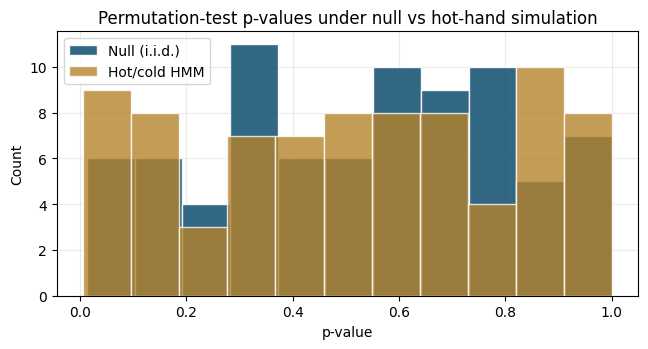

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(pvals_null, bins=11, alpha=0.9, label="Null (i.i.d.)", edgecolor='white', 
        color=CNET5442_COLORS[0])
ax.hist(pvals_hot,  bins=11, alpha=0.8, label="Hot/cold HMM", edgecolor='white', 
        color=CNET5442_COLORS[1])
ax.legend()
ax.set_title('Permutation-test p-values under null vs hot-hand simulation')
ax.set_xlabel('p-value')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

plt.show()

Under the null (i.i.d.), p-values should look roughly uniform.
Under a true hot/cold process, p-values tend to pile up near 0 more often.

This simulation is a sanity check:
the permutation test has **power** when there is real dependence.

Now we'll turn to real data, where the dependence (if any) is small and the confounds are huge.

_______
## Part 3c (Optional) — Classic "runs tests" and why power matters

Early hot-hand work often used **runs tests** (Wald-Wolfowitz) as a way to detect clustering of hits and misses (Gilovich, Vallone & Tversky, 1985; reviewed in Bar-Eli, Avugos & Raab, 2006).

A **run** is a maximal streak of identical outcomes. For example, the sequence

- $1,1,0,0,0,1,0$ has runs: $11$, $000$, $1$, $0$ → 4 runs.

Fewer runs than expected can indicate clustering (streakiness). More runs than expected can indicate alternation.

The important lesson is not that the runs test is "bad," but that many standard tests can have low power against subtle alternatives.

In [159]:
def runs_test_wald_wolfowitz(y):
    """Wald-Wolfowitz runs test for a binary sequence.

    Returns
    -------
    out : dict
        Contains number of runs R, expected runs E[R], variance Var[R], and z score.
    """
    y = np.asarray(y).astype(int)
    if len(y) == 0:
        return dict(R=np.nan, ER=np.nan, VarR=np.nan, z=np.nan)

    n1 = int(y.sum())
    n0 = int(len(y) - n1)
    if n0 == 0 or n1 == 0:
        # all same outcome -> exactly 1 run
        return dict(R=1, ER=np.nan, VarR=np.nan, z=np.nan, n0=n0, n1=n1)

    # count runs
    R = 1
    for t in range(1, len(y)):
        if y[t] != y[t-1]:
            R += 1

    # expected runs and variance under randomness conditional on n0, n1
    ER = 1 + (2 * n0 * n1) / (n0 + n1)
    VarR = (2 * n0 * n1 * (2 * n0 * n1 - n0 - n1)) / (((n0 + n1) ** 2) * (n0 + n1 - 1))

    z = (R - ER) / np.sqrt(VarR)
    return dict(R=R, ER=ER, VarR=VarR, z=z, n0=n0, n1=n1)

In [160]:
# Micro check on a toy sequence
runs_test_wald_wolfowitz([1,1,0,0,0,1,0])

{'R': 4,
 'ER': 4.428571428571429,
 'VarR': 1.3877551020408163,
 'z': -0.3638034375544997,
 'n0': 4,
 'n1': 3}

In [161]:
# Compare runs-test z-scores under null vs hot/cold HMM (simulation)
R = 200
zs_null = []
zs_hot = []

for _ in range(R):
    y0 = simulate_iid_bernoulli(T=80, p=0.5)
    z0 = runs_test_wald_wolfowitz(y0)['z']
    if not np.isnan(z0):
        zs_null.append(z0)

    y1, _ = simulate_two_state_hmm(T=80, theta_cold=0.40, theta_hot=0.65, p_hot_to_hot=0.85, p_cold_to_cold=0.85)
    z1 = runs_test_wald_wolfowitz(y1)['z']
    if not np.isnan(z1):
        zs_hot.append(z1)

zs_null = np.array(zs_null)
zs_hot = np.array(zs_hot)

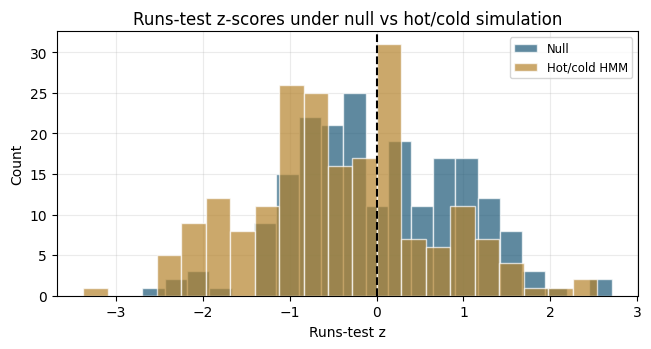

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(zs_null, bins=21, alpha=0.7, label="Null", edgecolor='white',
        color=CNET5442_COLORS[0])
ax.hist(zs_hot,  bins=21, alpha=0.7, label="Hot/cold HMM", edgecolor='white',
        color=CNET5442_COLORS[1])
ax.axvline(0, linestyle='--', color='k')
ax.legend(fontsize='small')
ax.set_title('Runs-test z-scores under null vs hot/cold simulation')
ax.set_xlabel('Runs-test z')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

plt.show()

The overlap is a reminder: with realistic sequence lengths, even a real effect can be hard to detect.
That's why calibration (permutation) and modeling (Bayes / HMM) are useful complements to classic tests.

_______
## Part 5 — Real data: NBA shot logs

We'll use the provided file `NBA_2025_Shots.csv`.
Each row is a shot attempt with:

- player and team identifiers,
- shot location and distance,
- shot type (2PT vs 3PT),
- game clock information,
- and whether the shot was made.

We'll start by loading the data and defining a **time order** for shots within each game.

In [163]:
# Load the NBA shots dataset
path = "data/bball/NBA_2025_Shots.csv"
shots = pd.read_csv(path)

shots.shape, shots.columns

((219527, 24),
 Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
        'PLAYER_NAME', 'GAME_DATE', 'GAME_ID', 'HOME_TEAM', 'AWAY_TEAM',
        'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE',
        'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y',
        'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
       dtype='object'))

In [164]:
# Quick look
shots.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2025,2024-25,1610612737,Atlanta Hawks,1642258,Zaccharie Risacher,11-12-2024,22400001,BOS,ATL,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,16.8,25.75,26,1,11,43
1,2025,2024-25,1610612737,Atlanta Hawks,1630552,Jalen Johnson,11-12-2024,22400001,BOS,ATL,Missed Shot,False,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Left Side,L,8-16 ft.,13.6,5.15,13,1,11,38
2,2025,2024-25,1610612737,Atlanta Hawks,1630552,Jalen Johnson,11-12-2024,22400001,BOS,ATL,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-15.7,25.55,25,1,10,50
3,2025,2024-25,1610612737,Atlanta Hawks,1630811,Keaton Wallace,11-12-2024,22400001,BOS,ATL,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,17.6,23.65,25,1,9,47
4,2025,2024-25,1610612737,Atlanta Hawks,203991,Clint Capela,11-12-2024,22400001,BOS,ATL,Made Shot,True,Putback Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,2.5,6.05,2,1,9,44


In [165]:
# Basic data checks
assert set(shots['SHOT_MADE'].unique()) <= {True, False, 0, 1}
shots['SHOT_MADE'] = shots['SHOT_MADE'].astype(int)

# No missing clock fields?
shots[['QUARTER','MINS_LEFT','SECS_LEFT']].isna().sum()

QUARTER      0
MINS_LEFT    0
SECS_LEFT    0
dtype: int64

### Defining an order for shots

Within a game:

- Quarters increase over time: 1, 2, 3, 4 (and possibly overtime, if present).
- Within a quarter, time counts down: larger `MINS_LEFT` / `SECS_LEFT` means earlier.

So chronological order is:

- `QUARTER` ascending,
- `MINS_LEFT` descending,
- `SECS_LEFT` descending.

We will use this order to construct each player's within-game shot sequence.

In [166]:
def add_shot_order(df):
    """Add a per-player, per-game shot index in chronological order."""
    df = df.copy()
    df = df.sort_values(
        ['GAME_ID', 'PLAYER_ID', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
        ascending=[True, True, True, False, False]
    )
    df['SHOT_INDEX_PLAYER_GAME'] = df.groupby(['GAME_ID','PLAYER_ID']).cumcount()
    return df

In [167]:

shots_ord = add_shot_order(shots)

# Sanity check: indexes start at 0 within each player-game
tmp = shots_ord.groupby(['GAME_ID','PLAYER_ID'])['SHOT_INDEX_PLAYER_GAME'].min().value_counts().sort_index()
tmp

SHOT_INDEX_PLAYER_GAME
0    24835
Name: count, dtype: int64

In [168]:
# How many shots per player-game?
pg_counts = shots_ord.groupby(['GAME_ID','PLAYER_NAME'])['SHOT_MADE'].size().rename('n_shots').reset_index()
pg_counts['n_shots'].describe()

count    24835.000000
mean         8.839420
std          5.835624
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         39.000000
Name: n_shots, dtype: float64

For hot-hand testing, the within-game sample sizes are often *small*.
That's one reason the debate has lasted so long: even in pro sports, the signal can be tiny relative to noise.

_______
## Part 6 — Exploratory: shot difficulty and base rates

Before we talk about streaks, we need a sense of the baseline environment.

Two obvious drivers of make probability are:

- **Shot type:** 3PT shots are harder than 2PT shots, on average.
- **Distance:** farther shots are harder, on average.

We'll visualize these relationships.

In [169]:
# League-wide make rate by shot type
rate_by_type = shots_ord.groupby('SHOT_TYPE')['SHOT_MADE'].mean().sort_values()
rate_by_type

SHOT_TYPE
3PT Field Goal    0.360222
2PT Field Goal    0.545057
Name: SHOT_MADE, dtype: float64

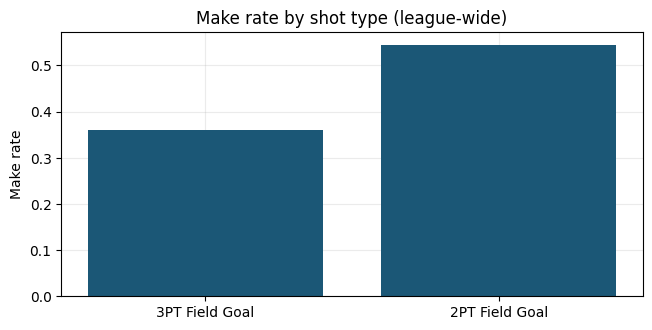

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

vals = rate_by_type.values
ax.bar(rate_by_type.index.astype(str), vals, color=CNET5442_COLORS[0])
ax.set_title('Make rate by shot type (league-wide)')
ax.set_ylabel('Make rate')
ax.grid(True, alpha=0.25)

plt.show()

In [171]:
# Make rate vs distance (binned)
bins = np.arange(0, shots_ord['SHOT_DISTANCE'].max() + 2, 2)
shots_ord['DIST_BIN'] = pd.cut(shots_ord['SHOT_DISTANCE'], bins=bins, right=False)

dist_summary = shots_ord.groupby('DIST_BIN')['SHOT_MADE'].agg(['mean','count']).reset_index()
dist_summary['dist_mid'] = dist_summary['DIST_BIN'].apply(lambda x: x.left + 1)
dist_summary.head()

,DIST_BIN,mean,count,dist_mid
0,"[0, 2)",0.741644,33868,1
1,"[2, 4)",0.566759,27322,3
2,"[4, 6)",0.447841,15146,5
3,"[6, 8)",0.427709,11592,7
4,"[8, 10)",0.445768,8731,9


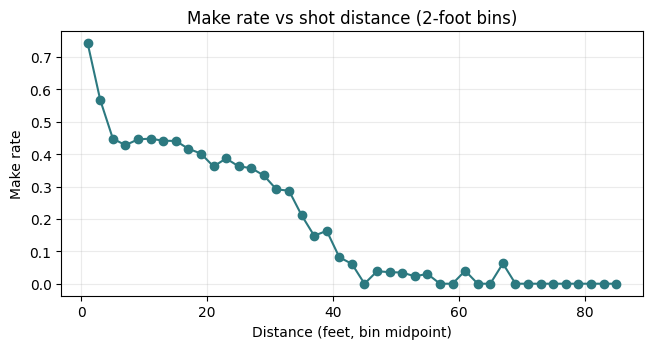

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.plot(dist_summary['dist_mid'], dist_summary['mean'], marker='o', color=CNET5442_COLORS[2])
ax.set_title('Make rate vs shot distance (2-foot bins)')
ax.set_xlabel('Distance (feet, bin midpoint)')
ax.set_ylabel('Make rate')
ax.grid(True, alpha=0.25)

plt.show()

These plots are a reminder: a raw make/miss sequence mixes together easier and harder attempts.
So any "hot hand" analysis that ignores shot difficulty is going to be hard to interpret.

We'll still start with the simple sequence-only analysis — but we'll come back and adjust for difficulty later.

_______
## Part 7 — Sequence-only hot hand tests on real NBA shooting

We'll pick an example player with a lot of attempts in the dataset.
Then we'll examine, game by game:

- the observed statistic $S(Y)$ (for $k=1$ by default),
- and a permutation-test p-value.

Why game by game?

- Within a game, the notion of "hot" is most meaningful (minutes, not weeks).
- Permuting within a game preserves that game's sample size and make rate.

(We'll later discuss what changes if we model across games.)

In [173]:
# Choose a high-volume player (most shot attempts in the dataset)
player_counts = shots_ord.groupby('PLAYER_NAME')['SHOT_MADE'].size().sort_values(ascending=False)
example_player = player_counts.index[0]
player_counts.head(10), example_player, int(player_counts.iloc[0])

(PLAYER_NAME
 Shai Gilgeous-Alexander    1656
 Anthony Edwards            1612
 Jayson Tatum               1465
 Cade Cunningham            1457
 Jalen Green                1437
 Devin Booker               1420
 Tyler Herro                1378
 Trae Young                 1376
 Nikola Jokić               1364
 Donovan Mitchell           1320
 Name: SHOT_MADE, dtype: int64,
 'Shai Gilgeous-Alexander',
 1656)

In [174]:
def player_game_sequences(df, player_name):
    """Return a dict mapping GAME_ID -> sequence of outcomes for a player."""
    sub = df[df['PLAYER_NAME'] == player_name].copy()
    seqs = {}
    for gid, gdf in sub.groupby('GAME_ID'):
        gdf = gdf.sort_values('SHOT_INDEX_PLAYER_GAME')
        seqs[gid] = gdf['SHOT_MADE'].to_numpy().astype(int)
    return seqs

In [175]:
seqs = player_game_sequences(shots_ord, example_player)
len(seqs), list(seqs.items())[:1][0][0], len(list(seqs.values())[0])

(76, 22400018, 25)

In [176]:
# Compute per-game hot-hand stats and permutation p-values (k=1)
# To keep runtime reasonable, we only run the permutation test for games with at least 10 shots.
rows = []
for gid, y in seqs.items():
    stat, details = hot_hand_statistic(y, k=1)

    pval = np.nan
    if len(y) >= 10 and (details['n_hit'] > 0) and (details['n_miss'] > 0):
        out = permutation_test_hot_hand(y, k=1, B=300)
        pval = out['p_value']

    rows.append({
        'GAME_ID': gid,
        'n_shots': len(y),
        'make_rate': y.mean(),
        'S_k1': stat,
        'p_value_k1': pval,
        'n_after_hit': details['n_hit'],
        'n_after_miss': details['n_miss'],
    })

In [177]:
res_pg = pd.DataFrame(rows).sort_values('n_shots', ascending=False).reset_index(drop=True)
res_pg.head(10)

,GAME_ID,n_shots,make_rate,S_k1,p_value_k1,n_after_hit,n_after_miss
0,22400618,35,0.485714,-0.352941,0.066445,17,17
1,22400920,32,0.468750,0.029412,0.946844,14,17
2,22400879,30,0.600000,0.147059,0.508306,17,12
3,22401036,29,0.241379,-0.142857,0.498339,7,21
4,22400673,29,0.551724,0.061538,0.867110,15,13
5,22400724,29,0.620690,0.251337,0.229236,17,11
6,22400299,28,0.464286,-0.200000,0.368771,12,15
7,22400048,28,0.464286,0.032967,1.000000,13,14
8,22400509,27,0.481481,0.076923,0.840532,13,13
9,22400982,27,0.407407,-0.300000,0.176080,10,16


In [178]:
# How often do we have enough 'after hit' and 'after miss' opportunities?
res_pg[['n_after_hit','n_after_miss']].describe()

,n_after_hit,n_after_miss
count,76.000000,76.000000
mean,10.815789,9.973684
std,3.005375,3.762884
min,5.000000,2.000000
25%,9.000000,7.000000
50%,11.000000,10.000000
75%,13.000000,12.000000
max,17.000000,21.000000


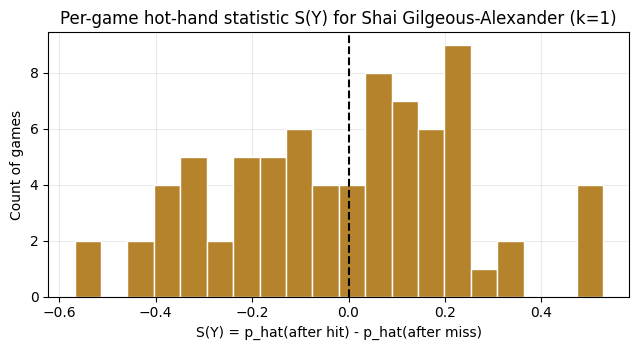

In [179]:
# Visualize S(Y) across games (k=1), weighting each game equally

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

vals = res_pg['S_k1'].dropna()
ax.hist(vals, bins=20, edgecolor='white', color=CNET5442_COLORS[1])
ax.axvline(0, linestyle='--', color='k')

ax.set_title(f'Per-game hot-hand statistic S(Y) for {example_player} (k=1)')
ax.set_xlabel('S(Y) = p_hat(after hit) - p_hat(after miss)')
ax.set_ylabel('Count of games')
ax.grid(True, alpha=0.25)

plt.show()

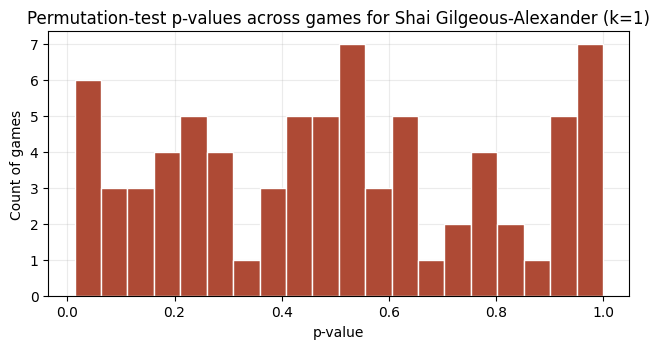

In [180]:
# P-values across games (k=1)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

pvals = res_pg['p_value_k1'].dropna()
ax.hist(pvals, bins=20, edgecolor='white', color=CNET5442_COLORS[3])

ax.set_title(f'Permutation-test p-values across games for {example_player} (k=1)')
ax.set_xlabel('p-value')
ax.set_ylabel('Count of games')
ax.grid(True, alpha=0.25)

plt.show()

A few points to keep grounded:

- Most games have only a handful of shot attempts for any single player.
- That means the "after a hit" and "after a miss" sample sizes can be tiny.
- Tiny sample sizes mean huge variance — and that is true no matter what inference method you use.

If we want a player-level statement, we usually need to **pool** information somehow.
Bayesian methods shine here: they make pooling explicit and interpretable.

_______
## Part 7b (Optional) — A player-level permutation test pooled across games

Game-by-game results are noisy.
A natural next question is:

> For this player, across the whole season, do we see a consistent "after a hit" advantage?

We'll define a pooled statistic across games:

$$
S_\text{pooled} =
\frac{\sum_i s^{(i)}_{\text{hit}}}{\sum_i n^{(i)}_{\text{hit}}}
-
\frac{\sum_i s^{(i)}_{\text{miss}}}{\sum_i n^{(i)}_{\text{miss}}},
$$

where in game $i$:

- $n^{(i)}_{\text{hit}}$ is the number of shots taken after $k$ hits,
- $s^{(i)}_{\text{hit}}$ is the number of makes among those shots,
and similarly for "miss."

**Calibration:** we permute the shot outcomes *within each game*,
recompute $S_\text{pooled}$, and compare to the observed value.

This respects:
- each game's sample size,
- each game's overall make rate,
- and finite-sample quirks of conditioning on streaks.

In [181]:
def pooled_stat_one_sequence(y, k=1):
    """Return conditional counts and pooled S for a single sequence."""
    y = np.asarray(y).astype(int)
    if len(y) <= k:
        return dict(s_hit=0, n_hit=0, s_miss=0, n_miss=0)

    wsum = np.convolve(y, np.ones(k, dtype=int), mode='valid')
    wsum = wsum[:-1]
    follow = y[k:]

    hit_mask = (wsum == k)
    miss_mask = (wsum == 0)

    return dict(
        s_hit=int(follow[hit_mask].sum()),
        n_hit=int(hit_mask.sum()),
        s_miss=int(follow[miss_mask].sum()),
        n_miss=int(miss_mask.sum())
    )

def pooled_stat_across_sequences(seqs, k=1):
    """Compute pooled S and counts across a list of sequences."""
    s_hit = n_hit = s_miss = n_miss = 0
    for y in seqs:
        c = pooled_stat_one_sequence(y, k=k)
        s_hit += c['s_hit']; n_hit += c['n_hit']
        s_miss += c['s_miss']; n_miss += c['n_miss']

    if n_hit == 0 or n_miss == 0:
        return np.nan, dict(s_hit=s_hit, n_hit=n_hit, s_miss=s_miss, n_miss=n_miss)

    p_hit = s_hit / n_hit
    p_miss = s_miss / n_miss
    return p_hit - p_miss, dict(s_hit=s_hit, n_hit=n_hit, s_miss=s_miss, n_miss=n_miss)

def pooled_permutation_test_over_games(seqs, k=1, B=600):
    """Permutation test for pooled S across games.

    Permute outcomes within each game, recompute pooled S.
    """
    obs, details = pooled_stat_across_sequences(seqs, k=k)
    if np.isnan(obs):
        return dict(obs=np.nan, p_value=np.nan, perm_stats=None, details=details)

    perm_stats = np.empty(B)
    for b in range(B):
        perm_seqs = [np.random.permutation(y) for y in seqs]
        s, _ = pooled_stat_across_sequences(perm_seqs, k=k)
        perm_stats[b] = s

    p_value = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (B + 1)
    return dict(obs=obs, p_value=p_value, perm_stats=perm_stats, details=details)

In [182]:
# Example player, pooled across games
seqs_example = [seqs[gid] for gid in sorted(seqs.keys())]
out_pool = pooled_permutation_test_over_games(seqs_example, k=1, B=600)

out_pool['obs'], out_pool['p_value'], out_pool['details']

(0.03750746297401919,
 0.11647254575707154,
 {'s_hit': 444, 'n_hit': 822, 's_miss': 381, 'n_miss': 758})

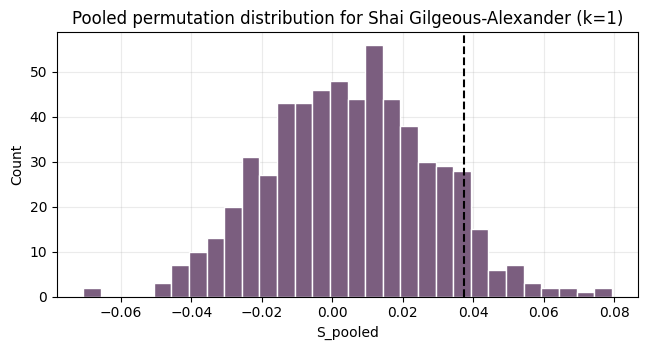

In [183]:
# Visualize pooled permutation distribution
perm_stats = out_pool['perm_stats']

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(perm_stats, bins=30, edgecolor='white', color=CNET5442_COLORS[5])
ax.axvline(out_pool['obs'], linestyle='--', color='k')

ax.set_title(f'Pooled permutation distribution for {example_player} (k=1)')
ax.set_xlabel('S_pooled')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.25)

plt.show()

### A league-wide scan (lightweight)

As an exploratory exercise, we can run the pooled permutation test for a small set of high-volume players.
This is not meant to be a final scientific claim — it's a way to see how noisy these estimates can be.

In [184]:
# Pick a set of high-volume players to keep runtime reasonable
top_players = player_counts.head(10).index.tolist()
scan_rows = []
B_scan = 200  # fewer permutations for a quick scan

for pname in top_players:
    seqs_p = player_game_sequences(shots_ord, pname)
    seqs_list = [seqs_p[gid] for gid in sorted(seqs_p.keys())]
    out = pooled_permutation_test_over_games(seqs_list, k=1, B=B_scan)

    scan_rows.append({
        'PLAYER_NAME': pname,
        'n_shots': int(player_counts.loc[pname]),
        'S_pooled_k1': out['obs'],
        'p_value_k1': out['p_value'],
        'n_after_hit': out['details']['n_hit'],
        'n_after_miss': out['details']['n_miss'],
    })

scan = pd.DataFrame(scan_rows).sort_values('n_shots', ascending=False).reset_index(drop=True)
scan

,PLAYER_NAME,n_shots,S_pooled_k1,p_value_k1,n_after_hit,n_after_miss
0,Shai Gilgeous-Alexander,1656,0.037507,0.074627,822,758
1,Anthony Edwards,1612,-0.005580,0.815920,690,843
2,Jayson Tatum,1465,-0.039480,0.169154,635,758
3,Cade Cunningham,1457,-0.001082,0.980100,655,732
4,Jalen Green,1437,-0.059715,0.054726,582,773
5,Devin Booker,1420,-0.010201,0.706468,629,716
6,Tyler Herro,1378,-0.054225,0.069652,621,680
7,Trae Young,1376,-0.021832,0.582090,540,760
8,Nikola Jokić,1364,0.003899,0.825871,746,548
9,Donovan Mitchell,1320,0.004875,0.910448,560,689


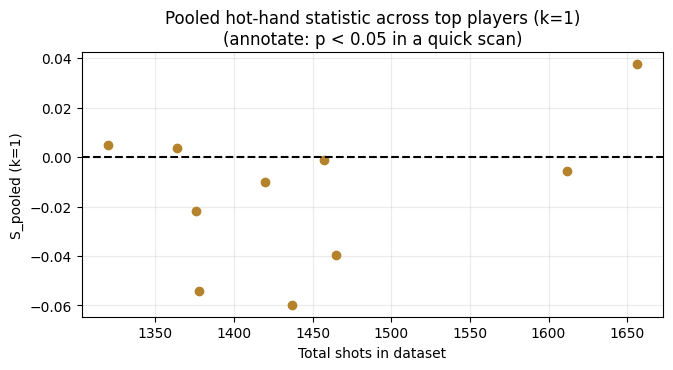

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

x = scan['n_shots'].to_numpy()
y = scan['S_pooled_k1'].to_numpy()
ax.scatter(x, y, color=CNET5442_COLORS[1])

for _, row in scan.iterrows():
    if row['p_value_k1'] < 0.05:
        ax.annotate(row['PLAYER_NAME'].split()[-1], (row['n_shots'], row['S_pooled_k1']),
                    fontsize=8, xytext=(3,3), textcoords='offset points')

ax.axhline(0, linestyle='--', color='k')
ax.set_title('Pooled hot-hand statistic across top players (k=1)\n(annotate: p < 0.05 in a quick scan)')
ax.set_xlabel('Total shots in dataset')
ax.set_ylabel('S_pooled (k=1)')

ax.grid(True, alpha=0.25)

plt.show()

If you see a few "significant" results in a scan like this, don't over-interpret them:
- there is multiple testing,
- shot difficulty and context differ across players,
- and $p<0.05$ in a quick scan is not a publication standard.

What the scan is good for is building intuition:
in real data, effects are small and uncertainty is large.

_______
## Part 8 — A Bayesian view of conditional shooting rates

If Bayes' rule, priors/likelihoods/posteriors, or Beta updates are new to you, see **Part 0.5** above for a hands-on crash course.

A Bernoulli model is the simplest probabilistic model for a binary outcome:

$$
Y \sim \text{Bernoulli}(\theta),
$$

meaning:

- $P(Y=1 \mid \theta)=\theta$,
- $P(Y=0 \mid \theta)=1-\theta$,
- where $\theta \in (0,1)$ is the success probability.


A convenient prior for $\theta$ is the **Beta** distribution:

$$
\theta \sim \text{Beta}(a,b).
$$

- $a>0$ and $b>0$ are prior "pseudo-counts."  
  A common intuition is that $a-1$ behaves like prior successes and $b-1$ behaves like prior failures.

If we observe $n$ Bernoulli trials with $s$ successes, the likelihood is Binomial-like, and the Beta prior is conjugate:

$$
\theta \mid \text{data} \sim \text{Beta}(a+s,\ b+n-s).
$$

We'll use this update repeatedly, so we'll compute it in code and sanity-check it on toy inputs.


### Why is this useful for the hot-hand question?

For a fixed streak definition (say "after a make"), we can treat those follow-up shots as Bernoulli trials:

- $\theta_{\text{after hit}}$ = make probability *given* we are in the "after hit" situation,
- $\theta_{\text{after miss}}$ = analogous for "after miss."

Then we care about a difference:

$$
\Delta = \theta_{\text{after hit}} - \theta_{\text{after miss}}.
$$

A Bayesian workflow is:

1. Count $s_1/n_1$ for after-hit opportunities and outcomes.
2. Count $s_0/n_0$ for after-miss opportunities and outcomes.
3. Update posteriors for $\theta_{\text{after hit}}$ and $\theta_{\text{after miss}}$.
4. Sample from the posteriors to learn about $\Delta$ (probability it's positive, credible interval, etc.).

We'll do this for our example player, pooling across their games.


In [186]:
def collect_conditional_counts_for_player(df, player_name, k=1):
    """Collect pooled counts for a player's shots across games.

    We pool across games by summing:
      - number of eligible follow-up shots after k hits
      - number of makes among those follow-up shots
      - number of eligible follow-up shots after k misses
      - number of makes among those follow-up shots
    """
    seqs = player_game_sequences(df, player_name)

    s_hit = 0
    n_hit = 0
    s_miss = 0
    n_miss = 0

    for y in seqs.values():
        # after k hits
        p, n = conditional_make_rate(y, k=k, on_success=True)
        if n > 0:
            # extract the actual follow-up outcomes
            y = np.asarray(y).astype(int)
            eligible = [t for t in range(k, len(y)) if np.all(y[t-k:t] == 1)]
            eligible = np.array(eligible, dtype=int)
            s_hit += y[eligible].sum()
            n_hit += len(eligible)

        # after k misses
        p, n = conditional_make_rate(y, k=k, on_success=False)
        if n > 0:
            y = np.asarray(y).astype(int)
            eligible = [t for t in range(k, len(y)) if np.all(y[t-k:t] == 0)]
            eligible = np.array(eligible, dtype=int)
            s_miss += y[eligible].sum()
            n_miss += len(eligible)

    return dict(s_hit=s_hit, n_hit=n_hit, s_miss=s_miss, n_miss=n_miss)

In [187]:
counts_k1 = collect_conditional_counts_for_player(shots_ord, example_player, k=1)
counts_k1

{'s_hit': 444, 'n_hit': 822, 's_miss': 381, 'n_miss': 758}

In [188]:
def beta_posterior_samples(s, n, a=1.0, b=1.0, size=20000):
    """Draw samples from a Beta posterior for a Bernoulli rate."""
    return np.random.beta(a + s, b + (n - s), size=size)

def summarize_delta_from_counts(counts, a=1.0, b=1.0, size=20000):
    """Posterior for Delta = theta_after_hit - theta_after_miss."""
    th_hit = beta_posterior_samples(counts['s_hit'], counts['n_hit'], a=a, b=b, size=size)
    th_miss = beta_posterior_samples(counts['s_miss'], counts['n_miss'], a=a, b=b, size=size)
    delta = th_hit - th_miss
    return dict(theta_hit=th_hit, theta_miss=th_miss, delta=delta)

In [189]:
post = summarize_delta_from_counts(counts_k1, a=1, b=1, size=20000)
np.mean(post['delta'] > 0), np.quantile(post['delta'], [0.025, 0.5, 0.975])

(0.9315, array([-0.01217112,  0.03723327,  0.08636928]))

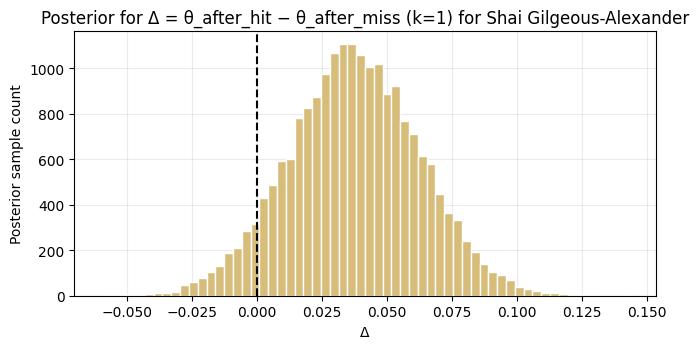

In [190]:
# Visualize posterior for Delta (k=1)
delta = post['delta']

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(delta, bins=60, edgecolor='white', color=CNET5442_COLORS[4])

ax.axvline(0, linestyle='--', color='k')

ax.set_title(f'Posterior for Δ = θ_after_hit − θ_after_miss (k=1) for {example_player}')
ax.set_xlabel('Δ')
ax.set_ylabel('Posterior sample count')
ax.grid(True, alpha=0.25)

plt.show()

### How to read this plot

- If most posterior mass is above 0, then the data support "better after makes" for this player, *within this conditioning scheme*.
- If most mass is below 0, it suggests worse after makes.
- If it's centered near 0 with wide spread, the data are basically inconclusive.

This is a **within-sample** Bayesian update on conditional rates.
It does not, by itself, address shot difficulty or the selection-bias calibration issue.
So next we'll do two things:

1. Try $k=2$ and $k=3$ to see what happens as we condition on longer streaks.
2. Build a model that explicitly includes a latent hot/cold state (an HMM).

In [191]:
# Repeat for k=1,2,3 (pooled across games)
for k in [1,2,3]:
    counts = collect_conditional_counts_for_player(shots_ord, example_player, k=k)
    post = summarize_delta_from_counts(counts, a=1, b=1, size=30000)
    prob_pos = np.mean(post['delta'] > 0)
    ci = np.quantile(post['delta'], [0.025, 0.5, 0.975])
    print(f"k={k}: n_hit={counts['n_hit']}, n_miss={counts['n_miss']},  P(Δ>0|data)={prob_pos:.3f},  CI={ci}")

k=1: n_hit=822, n_miss=758,  P(Δ>0|data)=0.930,  CI=[-0.01195685  0.03728244  0.08692364]
k=2: n_hit=425, n_miss=363,  P(Δ>0|data)=0.925,  CI=[-0.0187126   0.05094618  0.11967878]
k=3: n_hit=226, n_miss=173,  P(Δ>0|data)=0.918,  CI=[-0.02922019  0.06975751  0.16843187]


_______
## Part 9 — Adjusting for shot difficulty: "hot after controlling for what you took?"

A big interpretability problem in hot-hand analysis is **shot selection**:

- After making a few, players may take tougher shots (more contested, longer, off-balance, etc.).
- Defenses may also adjust and force tougher attempts.

If we just compare raw make rates after streaks, we might confuse:
- "hotter shooting" with
- "harder shot diet."

A pragmatic approach is:

1. Fit a baseline model for make probability using shot context (distance, 2PT/3PT, zone, …).
2. For a set of shots (e.g., "shots taken after 2 makes"), compare:
   - observed make rate vs
   - predicted make rate from the baseline model.

The difference is an **excess make rate** relative to baseline shot difficulty.

This is not perfect — shot logs don't capture every contextual feature — but it's a meaningful step.

In [192]:
# Build a simple baseline shot-quality model (logistic regression)
# Features: SHOT_DISTANCE (numeric), SHOT_TYPE and BASIC_ZONE (categorical)

feature_cols = ['SHOT_DISTANCE', 'SHOT_TYPE', 'BASIC_ZONE']
target_col = 'SHOT_MADE'

df_model = shots_ord[feature_cols + [target_col]].dropna().copy()

X = pd.get_dummies(df_model[feature_cols], drop_first=False)
y = df_model[target_col].astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5442)

clf = LogisticRegression(max_iter=500, solver='lbfgs')
clf.fit(X_train, y_train)

p_test = clf.predict_proba(X_test)[:, 1]
print("Test log loss:", log_loss(y_test, p_test))

Test log loss: 0.6584894522977367


In [193]:
# Add predicted make probability back to the full dataset
X_full = pd.get_dummies(shots_ord[feature_cols], drop_first=False)

# Align columns (train-time columns define the feature space)
X_full = X_full.reindex(columns=X.columns, fill_value=0)

shots_ord['PRED_MAKE'] = clf.predict_proba(X_full)[:, 1]

shots_ord[['SHOT_DISTANCE','SHOT_TYPE','BASIC_ZONE','SHOT_MADE','PRED_MAKE']].head()

,SHOT_DISTANCE,SHOT_TYPE,BASIC_ZONE,SHOT_MADE,PRED_MAKE
7562,26,3PT Field Goal,Above the Break 3,1,0.350440
7564,29,3PT Field Goal,Above the Break 3,1,0.322221
7571,24,3PT Field Goal,Above the Break 3,0,0.369867
7574,26,3PT Field Goal,Above the Break 3,0,0.350440
7576,1,2PT Field Goal,Restricted Area,1,0.668576


In [194]:
def excess_make_after_streak(df, player_name, k=1, on_success=True):
    """Compute observed minus predicted make rate for follow-up shots after a streak."""
    sub = df[df['PLAYER_NAME'] == player_name].copy()
    excesses = []
    weights = []
    for gid, gdf in sub.groupby('GAME_ID'):
        gdf = gdf.sort_values('SHOT_INDEX_PLAYER_GAME')
        y = gdf['SHOT_MADE'].to_numpy().astype(int)
        p = gdf['PRED_MAKE'].to_numpy().astype(float)

        target = 1 if on_success else 0
        idx = [t for t in range(k, len(y)) if np.all(y[t-k:t] == target)]
        if len(idx) == 0:
            continue

        idx = np.array(idx, dtype=int)
        obs = y[idx].mean()
        pred = p[idx].mean()
        excesses.append(obs - pred)
        weights.append(len(idx))

    # Return game-level excesses (unweighted) and weighted pooled excess
    excesses = np.array(excesses, dtype=float)
    weights = np.array(weights, dtype=int)

    pooled = np.average(excesses, weights=weights) if len(excesses) > 0 else np.nan

    return dict(excess_by_game=excesses, weights=weights, pooled_excess=pooled)

In [195]:
ex_after_hit = excess_make_after_streak(shots_ord, example_player, k=1, on_success=True)
ex_after_miss = excess_make_after_streak(shots_ord, example_player, k=1, on_success=False)

ex_after_hit['pooled_excess'], ex_after_miss['pooled_excess']

(0.06413740658496533, 0.042106796092419296)

In [196]:
# Compare excess after hit vs excess after miss for k=1,2,3
for k in [1,2,3]:
    ex_hit = excess_make_after_streak(shots_ord, example_player, k=k, on_success=True)['pooled_excess']
    ex_miss = excess_make_after_streak(shots_ord, example_player, k=k, on_success=False)['pooled_excess']
    print(f"k={k}: pooled excess after hit = {ex_hit:+.4f},  after miss = {ex_miss:+.4f},  difference = {(ex_hit-ex_miss):+.4f}")

k=1: pooled excess after hit = +0.0641,  after miss = +0.0421,  difference = +0.0220
k=2: pooled excess after hit = +0.0706,  after miss = +0.0400,  difference = +0.0306
k=3: pooled excess after hit = +0.0762,  after miss = +0.0316,  difference = +0.0446


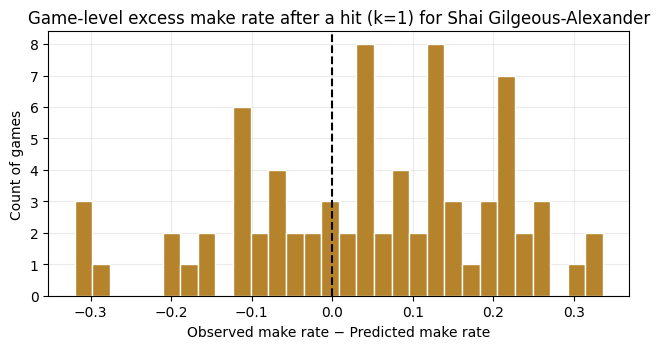

In [197]:
# Visualize game-level excesses (k=1)
excesses = ex_after_hit['excess_by_game']

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(excesses, bins=30, edgecolor='white', color=CNET5442_COLORS[1])
ax.axvline(0, linestyle='--', color='k')

ax.set_title(f'Game-level excess make rate after a hit (k=1) for {example_player}')
ax.set_xlabel('Observed make rate − Predicted make rate')
ax.set_ylabel('Count of games')
ax.grid(True, alpha=0.25)

plt.show()

**Interpretation:**

- An excess of +0.03 means "3 percentage points better than the baseline model expected," on that subset of shots.
- If the raw after-hit rate goes down but the predicted rate goes down *more*, excess can still be positive.
  That's exactly what shot-selection confounding can hide.

This style of adjustment is a bridge between:
- purely sequence-based hot-hand tests, and
- full causal or mechanistic models of decision-making and defense.

Now we'll shift to a more explicitly Bayesian "latent state" model that can represent hot/cold periods directly.

_______
## Part 10 — A Bayesian hot/cold model: a two-state hidden Markov model

A latent-state model makes the "hot hand" idea explicit:

- There is an unobserved state $Z_t \in \{0,1\}$ at each shot $t$.
- The state evolves with Markov persistence (hot tends to stay hot; cold tends to stay cold).
- The observed outcome $Y_t$ is a Bernoulli draw whose probability depends on the current state.

This section builds an HMM from scratch and then fits it to real shot sequences with a simple Gibbs sampler.


### Model specification: Markov transitions

We assume the latent state changes over time with a Markov transition matrix $A$:

$$
P(Z_t=j \mid Z_{t-1}=i) = A_{ij}.
$$

Where:

- $t$ indexes the shot attempt in time order.
- $Z_t \in \{0,1\}$ is the latent state at shot $t$ (think: 0=cold, 1=hot).
- $i$ and $j$ are possible previous/current states in $\{0,1\}$.
- $A$ is a $2\times 2$ matrix of transition probabilities.
- Each row of $A$ sums to 1: $A_{i0}+A_{i1}=1$ for each $i$.

Tiny numeric example:

If

$$
A = \begin{pmatrix}
0.90 & 0.10 \\
0.20 & 0.80
\end{pmatrix},
$$

then:

- from cold ($i=0$), you stay cold with probability $0.90$ and switch hot with probability $0.10$,
- from hot ($i=1$), you stay hot with probability $0.80$ and switch cold with probability $0.20$.

In code, we will store this as a NumPy array called `A`.

### Model specification: emissions

Conditional on the latent state, the observed make/miss outcome is Bernoulli:

$$
Y_t \mid (Z_t=j,\ \theta_j) \sim \text{Bernoulli}(\theta_j).
$$

Where:

- $Y_t \in \{0,1\}$ is the observed outcome at shot $t$ (0=miss, 1=make).
- $\theta_j \in (0,1)$ is the make probability in state $j$.

Tiny numeric example:

If $\theta_0=0.40$ and $\theta_1=0.60$, then:

- in the cold state you make about 40% of shots,
- in the hot state you make about 60% of shots.

In code, we will store emission probabilities as a length-2 array `theta = [theta_cold, theta_hot]`.


### Model specification: priors

To make Bayesian inference straightforward, we use conjugate priors:

- Emissions: $\theta_j \sim \text{Beta}(a,b)$ independently for $j\in\{0,1\}$.
- Transitions: each row $A_{i\cdot} \sim \text{Dirichlet}(\alpha_{i0},\alpha_{i1})$.

Tiny numeric examples:

- $\text{Beta}(1,1)$ is uniform on $(0,1)$ (a weak prior for a probability).
- $\text{Dirichlet}(1,1)$ is uniform over all 2-element probability vectors $(p,1-p)$.

Symbol-to-code map:

- $a,b$ correspond to `a, b` in the Gibbs sampler.
- $(\alpha_{i0},\alpha_{i1})$ correspond to `alpha_row` (we use the same prior for both rows to keep things simple).


### Why this model makes sense

A hot hand is not "you will definitely make the next shot."

It's "your underlying make probability is temporarily higher."

A hidden Markov model captures **temporary regimes** with persistence, which is a concrete mathematical version of "in the zone."

Next: we'll implement Bayesian inference for this HMM with a simple Gibbs sampler and fit it to real sequences.

In [198]:
def forward_filter_backward_sample(y, A, theta, pi=None):
    """Sample a state path z_{1:T} from P(z | y, A, theta) via FFBS.

    Parameters
    ----------
    y : array, shape (T,)
        Observations (0/1).
    A : array, shape (2,2)
        Transition matrix, rows sum to 1.
    theta : array, shape (2,)
        Emission probabilities P(y=1 | z=j).
    pi : array, shape (2,), optional
        Initial state distribution. If None, use uniform.

    Returns
    -------
    z : array, shape (T,)
        Sampled latent states (0/1).
    """
    y = np.asarray(y).astype(int)
    T = len(y)

    if pi is None:
        pi = np.array([0.5, 0.5], dtype=float)
    pi = np.asarray(pi, dtype=float)

    # Emission likelihoods: P(y_t | z_t=j)
    # For y_t in {0,1}: lik = theta_j^y (1-theta_j)^(1-y)
    emiss = np.vstack([
        (theta[j] ** y) * ((1 - theta[j]) ** (1 - y))
        for j in [0, 1]
    ]).T  # shape (T,2)

    # Forward messages alpha[t,j] proportional to P(y_1..y_t, z_t=j)
    alpha = np.zeros((T, 2), dtype=float)

    alpha[0] = pi * emiss[0]
    alpha[0] = alpha[0] / alpha[0].sum()

    for t in range(1, T):
        alpha[t] = emiss[t] * (alpha[t-1] @ A)
        s = alpha[t].sum()
        if s == 0:
            # If underflow occurs, renormalize with a tiny floor
            alpha[t] = np.maximum(alpha[t], 1e-300)
            s = alpha[t].sum()
        alpha[t] = alpha[t] / s

    # Backward sampling
    z = np.zeros(T, dtype=int)
    z[T-1] = np.random.choice([0, 1], p=alpha[T-1])

    for t in range(T-2, -1, -1):
        probs = alpha[t] * A[:, z[t+1]]
        probs = probs / probs.sum()
        z[t] = np.random.choice([0, 1], p=probs)

    return z

def gibbs_hmm_bernoulli(y, n_iter=4000, burn=1000,
                        a=1.0, b=1.0,
                        alpha_row=(1.0, 1.0),
                        enforce_hot_gt_cold=True):
    """Gibbs sampler for a 2-state Bernoulli HMM.

    Model:
      z_t | z_{t-1} ~ Markov(A)
      y_t | z_t=j ~ Bernoulli(theta_j)

    Priors:
      theta_j ~ Beta(a, b) independently
      A_row_i ~ Dirichlet(alpha_row) independently for i in {0,1}

    Returns
    -------
    draws : dict
        Samples of theta, A, and z after burn-in.
    """
    y = np.asarray(y).astype(int)
    T = len(y)

    # Initialize parameters
    theta = np.array([0.45, 0.55], dtype=float)
    A = np.array([[0.85, 0.15],
                  [0.15, 0.85]], dtype=float)

    # Storage
    theta_draws = []
    A_draws = []
    z_draws = []

    # Initialize z
    z = np.random.choice([0,1], size=T)

    alpha_row = np.array(alpha_row, dtype=float)

    for it in range(n_iter):
        # 1) sample z | y, theta, A
        z = forward_filter_backward_sample(y, A, theta, pi=np.array([0.5,0.5]))

        # 2) sample theta | y, z  (Beta conjugacy)
        for j in [0, 1]:
            idx = (z == j)
            s = y[idx].sum()
            n = idx.sum()
            theta[j] = np.random.beta(a + s, b + (n - s)) if n > 0 else np.random.beta(a, b)

        # 3) sample A | z  (Dirichlet conjugacy on each row)
        counts = np.zeros((2,2), dtype=int)
        for t in range(1, T):
            counts[z[t-1], z[t]] += 1

        for i in [0, 1]:
            A[i] = np.random.dirichlet(alpha_row + counts[i])

        # Optional identifiability: enforce theta_hot > theta_cold by relabeling
        if enforce_hot_gt_cold and theta[1] < theta[0]:
            # swap labels 0 and 1
            theta = theta[::-1]
            A = A[::-1, ::-1]
            z = 1 - z

        # Save after burn-in
        if it >= burn:
            theta_draws.append(theta.copy())
            A_draws.append(A.copy())
            z_draws.append(z.copy())

    return dict(theta=np.array(theta_draws),
                A=np.array(A_draws),
                z=np.array(z_draws))

In [199]:
def gibbs_hmm_multiple_sequences(seqs_list, n_iter=3000, burn=1000,
                                a=1.0, b=1.0,
                                alpha_row=(1.0, 1.0),
                                enforce_hot_gt_cold=True):
    """Gibbs sampler for a shared-parameter 2-state Bernoulli HMM across multiple sequences.

    This is a simple (teachable) way to pool information across many short sequences,
    e.g. many games for the same player.

    Model for each sequence m:
      z_{m,t} | z_{m,t-1} ~ Markov(A)
      y_{m,t} | z_{m,t}=j ~ Bernoulli(theta_j)

    Shared parameters across sequences:
      theta = (theta_cold, theta_hot)
      A     = 2x2 transition matrix

    Priors (conjugate):
      theta_j ~ Beta(a, b) independently
      A_row_i ~ Dirichlet(alpha_row) independently for i in {0,1}

    Parameters
    ----------
    seqs_list : list
        List of 1d sequences, each containing only 0/1 values.
    n_iter : int
        Total Gibbs iterations (including burn-in).
    burn : int
        Burn-in iterations to discard.
    a, b : float
        Beta prior parameters for theta.
    alpha_row : tuple(float, float)
        Dirichlet prior parameters for each row of A.
    enforce_hot_gt_cold : bool
        If True, relabel the states so that theta_hot >= theta_cold in every saved draw.

    Returns
    -------
    draws : dict
        theta    : array, shape (n_keep, 2)
        A        : array, shape (n_keep, 2, 2)
        hot_frac : array, shape (n_keep, M)
            Fraction of time spent in the hot state for each sequence.
    """
    if not isinstance(seqs_list, (list, tuple)):
        raise TypeError("seqs_list must be a list (or tuple) of 1d 0/1 sequences.")

    # Clean and validate the sequences
    seqs = []
    for s in seqs_list:
        y = np.asarray(s).astype(int)
        if y.ndim != 1:
            raise ValueError("Each sequence must be 1-dimensional.")
        if y.size == 0:
            # Skip empty sequences rather than failing
            continue
        if not np.isin(y, [0, 1]).all():
            raise ValueError("Sequences must contain only 0/1 values.")
        seqs.append(y)

    M = len(seqs)
    if M == 0:
        raise ValueError("No non-empty 0/1 sequences provided.")

    if burn >= n_iter:
        raise ValueError("burn must be < n_iter.")

    # Initialize shared parameters
    theta = np.array([0.45, 0.55], dtype=float)
    A = np.array([[0.85, 0.15],
                  [0.15, 0.85]], dtype=float)

    alpha_row = np.array(alpha_row, dtype=float)

    # Initialize latent states for each sequence
    z_list = [np.random.choice([0, 1], size=len(y)) for y in seqs]

    # Storage (after burn-in)
    theta_draws = []
    A_draws = []
    hot_frac_draws = []

    for it in range(n_iter):

        # 1) Sample each latent path z_m | y_m, theta, A
        for m in range(M):
            z_list[m] = forward_filter_backward_sample(
                seqs[m], A, theta, pi=np.array([0.5, 0.5])
            )

        # 2) Sample theta | all sequences, all z   (Beta conjugacy)
        for j in [0, 1]:
            s_j = 0  # number of successes assigned to state j
            n_j = 0  # number of trials assigned to state j
            for m in range(M):
                idx = (z_list[m] == j)
                n_j += int(idx.sum())
                s_j += int(seqs[m][idx].sum())
            theta[j] = np.random.beta(a + s_j, b + (n_j - s_j)) if n_j > 0 else np.random.beta(a, b)

        # 3) Sample A | all sequences, all z   (Dirichlet conjugacy)
        counts = np.zeros((2, 2), dtype=int)
        for m in range(M):
            z = z_list[m]
            for t in range(1, len(z)):
                counts[z[t-1], z[t]] += 1

        for i in [0, 1]:
            A[i] = np.random.dirichlet(alpha_row + counts[i])

        # 4) Identifiability: enforce theta_hot >= theta_cold by relabeling
        if enforce_hot_gt_cold and theta[1] < theta[0]:
            theta = theta[::-1]
            A = A[::-1, ::-1]
            z_list = [1 - z for z in z_list]

        # Save after burn-in
        if it >= burn:
            theta_draws.append(theta.copy())
            A_draws.append(A.copy())
            hot_frac_draws.append(np.array([z.mean() for z in z_list], dtype=float))

    return dict(theta=np.array(theta_draws),
                A=np.array(A_draws),
                hot_frac=np.array(hot_frac_draws))

In [200]:
# Quick smoke test on simulated data
y_sim, z_sim = simulate_two_state_hmm(T=80, theta_cold=0.35, theta_hot=0.70, p_hot_to_hot=0.9, p_cold_to_cold=0.9)
draws = gibbs_hmm_bernoulli(y_sim, n_iter=1200, burn=400, a=1, b=1, alpha_row=(1,1))

draws['theta'].shape, draws['A'].shape, draws['z'].shape

((800, 2), (800, 2, 2), (800, 80))

In [201]:
# Posterior summaries on the simulated example
theta_post = draws['theta']
A_post = draws['A']

theta_cold_mean, theta_hot_mean = theta_post.mean(axis=0)
A_mean = A_post.mean(axis=0)

theta_cold_mean, theta_hot_mean, A_mean

(0.2807774295433509,
 0.5865435092342195,
 array([[0.54661521, 0.45338479],
        [0.44342159, 0.55657841]]))

### Expected streak length in a Markov state

If a state has persistence $P(Z_{t}=j \mid Z_{t-1}=j) = A_{jj}$,
then the sojourn length (consecutive time spent in that state) is geometric with mean

$$
\mathbb{E}[L_j] = \frac{1}{1 - A_{jj}}.
$$

- If $A_{jj}=0.9$, the mean run length in state $j$ is $1/(1-0.9)=10$ shots.
- If $A_{jj}=0.6$, the mean run length is $1/(1-0.6)=2.5$ shots.

We'll compute this from the posterior on real data later.

In [202]:
# Tiny numeric example for the sojourn-length formula
for ajj in [0.6, 0.8, 0.9]:
    print(ajj, round(1/(1-ajj),2))

0.6 2.5
0.8 5.0
0.9 10.0


_______
## Part 11 — Fitting the Bayesian HMM to a real player-game sequence

We'll pick one game for our example player with a relatively large number of shot attempts.
Then we'll fit the two-state HMM and interpret:

- $\theta_{\text{cold}}$ vs $\theta_{\text{hot}}$,
- the transition matrix $A$,
- and the posterior probability of being in the hot state over time.

**Important caveat:** this model treats shots as exchangeable given the latent state.
It does not directly include shot difficulty, defense, or fatigue.
So we should read it as a stylized "regime" model, not as a causal explanation.

In [203]:
# Pick a player-game with many attempts
pg = shots_ord[shots_ord['PLAYER_NAME'] == example_player].groupby('GAME_ID')['SHOT_MADE'].size().sort_values(ascending=False)
game_id = pg.index[0]
n_attempts = int(pg.iloc[0])
game_id, n_attempts

(22400618, 35)

In [204]:
gdf = shots_ord[(shots_ord['PLAYER_NAME'] == example_player) & (shots_ord['GAME_ID'] == game_id)].copy()
gdf = gdf.sort_values('SHOT_INDEX_PLAYER_GAME')
y_real = gdf['SHOT_MADE'].to_numpy().astype(int)

# Show the sequence as 1/0
y_real

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

In [205]:
# Fit the HMM via Gibbs sampling
draws_real = gibbs_hmm_bernoulli(y_real, n_iter=2000, burn=700, a=1, b=1, alpha_row=(1,1))

theta_post = draws_real['theta']
A_post = draws_real['A']
z_post = draws_real['z']

theta_post.shape, A_post.shape, z_post.shape

((1300, 2), (1300, 2, 2), (1300, 35))

In [206]:
# Posterior summaries
theta_mean = theta_post.mean(axis=0)
theta_ci = np.quantile(theta_post, [0.025, 0.5, 0.975], axis=0)

A_mean = A_post.mean(axis=0)
A_ci = np.quantile(A_post, [0.025, 0.5, 0.975], axis=0)

theta_mean, theta_ci, A_mean

(array([0.25332357, 0.72497347]),
 array([[0.01539615, 0.44260476],
        [0.23743934, 0.73636323],
        [0.55147657, 0.97542688]]),
 array([[0.35246909, 0.64753091],
        [0.64760384, 0.35239616]]))

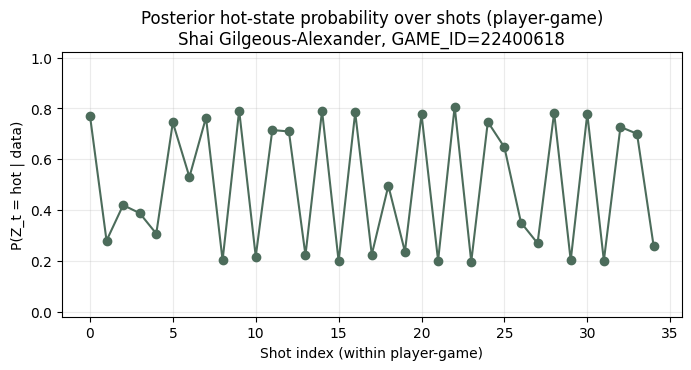

In [207]:
# Posterior hot-state probability over time: P(Z_t=1 | data) ≈ mean of sampled z_t
p_hot_t = z_post.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=100)

ax.plot(p_hot_t, marker='o', color=CNET5442_COLORS[6])

ax.set_ylim(-0.02, 1.02)
ax.set_title(f'Posterior hot-state probability over shots (player-game)\n{example_player}, GAME_ID={game_id}')
ax.set_xlabel('Shot index (within player-game)')
ax.set_ylabel('P(Z_t = hot | data)')
ax.grid(True, alpha=0.25)

plt.show()

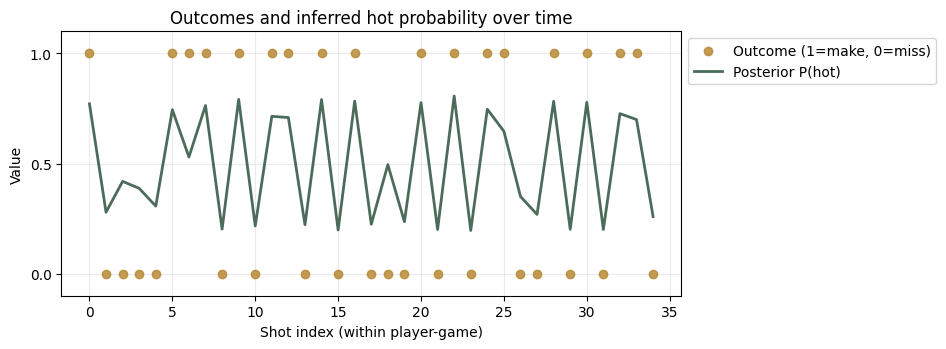

In [208]:
# Overlay outcomes (made/miss) with posterior hot probability
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=100)

t = np.arange(len(y_real))
ax.scatter(t, y_real, label="Outcome (1=make, 0=miss)", alpha=0.8, color=CNET5442_COLORS[1])
ax.plot(t, p_hot_t, label="Posterior P(hot)", linewidth=2, color=CNET5442_COLORS[6])

ax.set_yticks([0, 0.5, 1.0])
ax.set_ylim(-0.1, 1.1)
ax.legend(loc=2, bbox_to_anchor=[1,1])
ax.set_title('Outcomes and inferred hot probability over time')
ax.set_xlabel('Shot index (within player-game)')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.25)

plt.show()

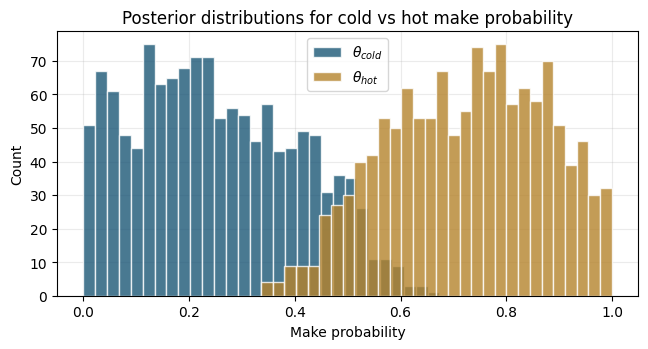

In [209]:
# Posterior distributions for theta_cold and theta_hot
fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)

ax.hist(theta_post[:,0], bins=30, alpha=0.8, label=r"$\theta_{cold}$", edgecolor='white', color=CNET5442_COLORS[0])
ax.hist(theta_post[:,1], bins=30, alpha=0.8, label=r"$\theta_{hot}$", edgecolor='white', color=CNET5442_COLORS[1])

ax.legend()
ax.set_title('Posterior distributions for cold vs hot make probability')
ax.set_xlabel('Make probability')
ax.set_ylabel('Count')

ax.grid(True, alpha=0.25)

plt.show()

In [210]:
# Posterior mean sojourn lengths in cold and hot states
A_mean = A_post.mean(axis=0)
mean_run_cold = 1 / (1 - A_mean[0,0])
mean_run_hot  = 1 / (1 - A_mean[1,1])

mean_run_cold, mean_run_hot

(1.544327828265734, 1.5441538999783706)

### What to take from this

- If $\theta_{\text{hot}}$ is meaningfully larger than $\theta_{\text{cold}}$, the model is allocating some outcomes to a "better" regime.
- If $A_{11}$ is large, the inferred hot regime is persistent (once hot, tends to remain hot).
- The time series $P(Z_t=\text{hot}\mid \text{data})$ is a *posterior belief*, not a hard classification.

This kind of model is especially useful pedagogically because it separates:
- "underlying probability" (latent state and $\theta$'s),
from
- "observed randomness" (makes and misses).

In the next optional section, we'll see how this model can be stressed and extended.

_______
## Part 12 — Pooling across games with a shared hot/cold process

A single game is a tiny dataset.
If we want stable inference, we can pool information across games while still keeping each game's shot order.

One simple pooling assumption is:

- Each game $i$ provides a sequence $Y^{(i)} = (Y^{(i)}_1,\dots,Y^{(i)}_{T_i})$.
- Conditional on shared parameters $(A,\theta)$, the games are independent:
  each game has its own latent path $Z^{(i)}$, but the same transition/emission behavior.

This is conceptually similar to treating games as "replicate time series,"
which is also how some Bayesian hot-hand HMM papers structure the data at the team level.

We'll implement this pooled model for our example player.

In [211]:
# Build the per-game sequences for the example player (sorted by within-game shot index)
seqs_list = [seqs[gid] for gid in sorted(seqs.keys())]

draws_pool = gibbs_hmm_multiple_sequences(seqs_list, n_iter=1500, burn=500, a=1, b=1, alpha_row=(1,1))

draws_pool['theta'].shape, draws_pool['A'].shape, draws_pool['hot_frac'].shape

((1000, 2), (1000, 2, 2), (1000, 76))

In [212]:
# Posterior on shared parameters
theta_mean = draws_pool['theta'].mean(axis=0)
theta_ci = np.quantile(draws_pool['theta'], [0.025, 0.5, 0.975], axis=0)

A_mean = draws_pool['A'].mean(axis=0)
A_ci = np.quantile(draws_pool['A'], [0.025, 0.5, 0.975], axis=0)

theta_mean, theta_ci, A_mean

(array([0.35155755, 0.66559689]),
 array([[0.03350277, 0.5272848 ],
        [0.38015323, 0.6595547 ],
        [0.51210305, 0.8230164 ]]),
 array([[0.68786343, 0.31213657],
        [0.28688879, 0.71311121]]))

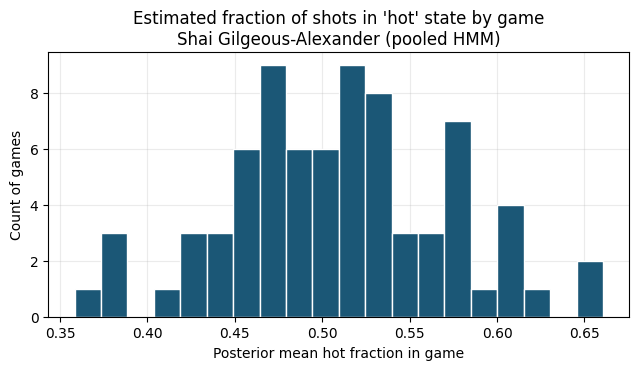

In [213]:
# Distribution of hot fractions across games
hot_frac_mean_by_game = np.nanmean(draws_pool['hot_frac'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 3.5), dpi=100)
ax.hist(hot_frac_mean_by_game, bins=20, edgecolor='white', color=CNET5442_COLORS[0])
ax.set_title(f"Estimated fraction of shots in 'hot' state by game\n{example_player} (pooled HMM)")
ax.set_xlabel('Posterior mean hot fraction in game')
ax.set_ylabel('Count of games')

ax.grid(True, alpha=0.25)

plt.show()

Pooling across games often stabilizes the estimate of $\theta_{\text{hot}}$ vs $\theta_{\text{cold}}$.
But it also makes a stronger assumption: that the player's hot/cold dynamics are similar from game to game.

That's not obviously true.
A next step (beyond this notebook) would be to allow game-to-game variation,
for example with hierarchical priors or random effects, as in richer Bayesian HMM approaches.

_______
## Part 13 — So… is the hot hand real?

By now you should be suspicious of any one-sentence answer.

The best you can do is: specify an estimand, choose a model (or test) that targets it, and then report an **effect size with uncertainty**.

A fair summary of the back-and-forth is something like this:

Gilovich, Vallone, and Tversky (1985) analyzed several basketball settings (field goals, free throws, and a controlled shooting task) and reported little evidence of positive dependence in outcomes. They connected that negative result to a broader psychological claim: people often misperceive randomness and overinterpret clusters and runs.

Later work emphasized that some "classic" hot-hand estimators are **not centered at zero under a no-hot-hand null** when the sequences are short. Miller & Sanjurjo (2018) show that conditioning on streaks can create a finite-sample bias that pushes naive estimates downward, and that correcting for this can change conclusions.

Modern work tends to avoid "one statistic to rule them all." Instead it asks what kind of dependence structure is plausible and what the data can identify—often using richer models (and sometimes richer data):

- Reviews in sports psychology emphasize that definitions and test statistics differ across studies (Bar‑Eli, Avugos & Raab, 2006).
- Some analyses use settings like professional darts to study performance with minimal strategic confounding (Ötting et al., 2020).
- Some analyses use NBA tracking-era data to explore hot-hand patterns while accounting for changing shot selection and context (Pelechrinis & Winston, 2022).
- Some analyses build Bayesian latent-state models directly for basketball sequences (Calvo, Armero & Spezia, 2025).


### A Gelman-style way to end the debate

Gelman's writing on the topic is useful precisely because it refuses to treat "hot hand" as a binary yes/no claim.

The recurring points are:

- The "point null" of perfectly constant performance is rarely realistic in sports. Real performance varies.
- That variation can be *small in outcome space* (percentage points), and therefore hard to detect with naive streak stats.
- Outcomes are noisy measurements of latent states, so regressions of outcome-on-outcome can be attenuated even when latent hotness exists.
- Heterogeneity is expected: averaging can dilute real effects, and some players (or contexts) can behave differently.

In other words: the hot-hand controversy is an excellent case study in **model alignment** and **measurement**.


### Practical takeaway for analysts

If you want to make an evidence-based hot-hand claim from real game data, you usually need:

1. A definition of the effect that matches your scientific question (outcome dependence, latent state, decision-making, or something else).
2. A calibration strategy that respects finite samples (e.g., a permutation test that conditions on total makes).
3. A plan for confounding (shot difficulty, defensive adjustment, fatigue, game context).
4. A way to represent uncertainty and heterogeneity (posterior intervals, partial pooling, player-level variation).
5. A model-checking habit (at least one posterior predictive check or diagnostic that asks "does my model reproduce the streakiness I see?").

That's not pessimism—it's what makes the hot-hand problem a great applied-statistics lesson.


_______
## Appendix A (Optional) — A deeper intuition for the streak selection bias

In Part 2 we saw that even for a fair coin, the sample statistic $\hat p_{1\mid 1}$ can have expectation below 0.5 for short sequences.

A useful mental model is:

- When you condition on "previous shot was a hit," you are selecting positions that already consumed some of the hits in the sequence.
- In very short sequences, the *availability* of hits to appear as "the next outcome after a hit" is constrained.

Enumeration (as we did for $T=3$) makes this concrete.
For longer $T$, simulation is usually the easiest way to build intuition.

If you want the formal treatment and general results, see Miller & Sanjurjo (2018).

_______
## Appendix B (Optional) — What exactly is the null hypothesis?

It's worth distinguishing two nulls:

1. **Exchangeability / no time structure:** the order of outcomes is irrelevant (permutation null).
2. **i.i.d. Bernoulli:** outcomes are independent and identically distributed with a constant success probability $p$.

A permutation test is calibrated to (1).
It is often a good approximation to (2), but they are not identical statements.

Why might (2) fail in real sports even without a hot hand?

- Shot difficulty varies over time (fatigue, defense, location, shot type).
- The player's role changes (on-ball vs off-ball, end-of-quarter heaves, etc.).
- Game strategy changes (playing from ahead vs behind).

That's why it's helpful to treat permutation tests as a *calibration* tool, not as the whole story.

_______
## Appendix C (Optional) — Extensions and alternative perspectives

Here are three directions that often come up:

### C.1 Higher-order dependence

Instead of a 2-state HMM, you can model $Y_t$ as a $k$-th order Markov chain:
$P(Y_t \mid Y_{t-1},\dots,Y_{t-k})$.

Chang (2019) studies Bayesian model selection for multistep Markov chains and applies it to free throw sequences.

### C.2 Continuous latent "form"

In some sports settings, actions are extremely repeatable (darts is a great example).
Ötting et al. (2020) analyze professional darts with a latent form process that evolves over time.

### C.3 Rich Bayesian HMMs for basketball

Calvo, Armero & Spezia (2025) propose a Bayesian hidden Markov approach for team shot sequences,
including covariates and game-level random effects.

These models are more realistic, but they also require more assumptions and more computation.

_______
## Appendix D (Optional) — Possible datasets to try next

If you want to apply these ideas beyond this NBA shot log, here are dataset types that work well:

- **Free throw sequences** (cleaner repeated action; less shot-selection confounding).
- **Three-point contest / skills contest data** (more controlled shot conditions).
- **Darts / bowling / golf putting** sequences (high repeatability; often strong structure).
- **Tennis point-by-point data** (many points per match; dependence can be subtle but detectable).
- **Soccer penalties** (rare but highly controlled repeated action).

A good dataset for hot-hand learning has:
- many repeated trials per "actor" (player),
- reasonably consistent trial difficulty,
- and accurate time ordering.

_______
## Appendix E — Data requirements for deeper replications

A theme in Gelman-style discussions of the hot hand is that **the answer depends on what you control for**.

If you only observe "make/miss," you can test certain kinds of dependence—but you cannot disentangle:

- changing shot difficulty,
- defensive adjustment,
- fatigue and substitution patterns,
- and deliberate behavior ("feed the hot hand").

So it helps to be explicit about what data you'd need to replicate or extend the kinds of analyses we sketched.


### What you need depends on the question

| Question you want to answer | Minimum data you need | Helpful extra data |
|---|---|---|
| Are outcomes dependent *within a fixed sequence*? | time-ordered makes/misses for each sequence (player-game, player-session, etc.) | number of attempts per sequence; a consistent definition of "attempt" |
| Is there evidence of a latent hot/cold state? | same as above | finer time stamps; information about breaks/rest; possession context |
| Is any predictability just shot selection? | time-ordered makes/misses + a proxy for shot difficulty | distance, shot type, location; shot-clock time; defender distance; "catch-and-shoot" indicators |
| Do defenders/teams adjust to streaks? | sequence + who guarded + defensive scheme measures | tracking data (player positions); matchup data; play type |
| Does the effect vary across players? | many players + many sequences per player | player attributes; role/usage; minutes played; fatigue proxies |


### Concrete examples of datasets that support this

- **Basketball, play-by-play + shot location:** You can do a lot with shot-by-shot logs that include player, game, time, shot type, and make/miss. This supports permutation tests, conditional rates, and basic regressions.

- **Basketball, tracking-era "shot quality" variables:** To separate "hot hand" from "harder shots while feeling hot," you want defender distance, dribble count, catch-and-shoot, and related features. (This is where proprietary tracking vendors become useful.)

- **Free throws:** A clean setting with fixed location and minimal strategic confounding. You still need ordering and player IDs, but "shot difficulty" is much more stable.

- **Darts, bowling, billiards, archery:** Repeated skill tasks where the environment is relatively constant. These are excellent for latent-state models because strategy confounding is limited.

- **Controlled shooting experiments:** Practice sessions where shot type is fixed (or randomized) and the experimental design ensures comparable difficulty across time.

If you want to build "replication-quality" Gelman-style examples, the single biggest upgrade is moving from raw outcomes to **outcomes + difficulty + context**, while preserving the correct time ordering.


_______
## References

Primary and review sources (available in the course materials):
- Gilovich, T., Vallone, R., & Tversky, A. (1985). *The hot hand in basketball: On the misperception of random sequences.* Cognitive Psychology.
- Bar‑Eli, M., Avugos, S., & Raab, M. (2006). *Twenty years of "hot hand" research: Review and critique.* Psychology of Sport and Exercise.
- Miller, J. B., & Sanjurjo, A. (2018). *Surprised by the hot hand fallacy? A truth in the law of small numbers.* Econometrica.
- Chang, S. (2019). *Predictive Bayesian selection of multistep Markov chains applied to the detection of the hot hand.* Royal Society Open Science.
- Ötting, M., Langrock, R., Deutscher, C., and Leos-Barajas, V. (2020). *The hot hand in professional darts*. **Journal of the Royal Statistical Society: Series A**, 183(2), 565-580. doi: 10.1111/rssa.12527
- Pelechrinis, K., & Winston, W. (2022). *The hot hand in the wild.* PLOS ONE.
- Calvo, G., Armero, C., & Spezia, L. (2025). *Can the hot hand phenomenon be modelled? A Bayesian hidden Markov approach.* Computational Statistics.
- Page, L. (2023). *The Hot Hand Fallacy.* Substack essay (course PDF).

Gelman blog posts and related commentary (online):
- Gelman, A. (2012-03-16). *Hot hand debate is warming up.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2012/03/16/hot-hand-debate-is-warming-up/
- Gelman, A. (2014-08-12). *Understanding the hot hand myth: hot hand time.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2014/08/12/understanding-hot-hand-myth-hot-hand-time/
- Gelman, A. (2015-07-09). *Hey, guess what. There really is a hot hand.* Statistical Modeling, Causal Inference, and Social Science.
  https://statmodeling.stat.columbia.edu/2015/07/09/hey-guess-what-there-really-is-a-hot-hand/
- Gelman, A. (2015-09-30). *Hot hand explanation again.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2015/09/30/hot-hand-explanation-again/
- Gelman, A. (2017-11-06). *More hot hand.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2017/11/06/more-hot-hand/
- Gelman, A. (2018-09-18). *Hot hand darts.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2018/09/18/hot-hand-darts/
- Gelman, A. (2020-11-25). *A new hot hand paradox.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2020/11/25/a-new-hot-hand-paradox/
- Gelman, A. (2024-03-15). *Hot hand: the controversy that shouldn't be, and thinking more about what makes something into a controversy.* Statistical Modeling, Causal Inference, and Social Science.  
  https://statmodeling.stat.columbia.edu/2024/03/15/hot-hand-the-controversy-that-shouldnt-be-and-thinking-more-about-what-makes-something-into-a-controversy/
- Drew's Views (Albert Bridge Capital). (2020-09-07). *The hot hand fallacy fallacy fallacy.*  
  https://www.albertbridgecapital.com/post/the-hot-hand-fallacy-fallacy-fallacy

General Bayesian modeling references:
- McElreath, R. *Statistical Rethinking: A Bayesian Course with Examples in R and Stan.*
- Gelman, A., Hill, J., & Vehtari, A. *Regression and Other Stories.*
- Gelman, A., Carlin, J., Stern, H., Dunson, D., Vehtari, A., & Rubin, D. *Bayesian Data Analysis.*
- Murphy, K. P. *Machine Learning: A Probabilistic Perspective.* (Chapters on HMMs and state-space models)